In [1]:
#from time import time

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd

from my_fun import read_brain_feature
from my_fun import run_model
from my_fun import summary_result
from my_fun import plot_result_mergecv

brain_feature_list, subject_id = read_brain_feature()

# read subject_info:
pnc_subject_info = pd.read_csv("data/pnc_subject_info.csv", delimiter = ",")
print(pnc_subject_info.shape)

subject_info_merge = subject_id.merge(pnc_subject_info, how = "left", left_on = "names", right_on = "SUBJID")
print(subject_info_merge.shape)

# head_motion_subjects = pd.read_csv("data/head_motion_subject_delete.txt", delimiter = "\t", header = None)
# #print(head_motion_subjects)
# head_motion_sublist = head_motion_subjects.iloc[:,0].tolist()
# subject_info_merge = subject_info_merge[~subject_info_merge.SUBJID.isin(head_motion_sublist)]

# remove samples with Med_rating higher than 1:
subject_info_merge["Med_Rating"] = subject_info_merge["Med_Rating"].apply(pd.to_numeric, errors='coerce')
subject_info_merge = subject_info_merge.loc[subject_info_merge["Med_Rating"]<2,:]
subject_info_merge['Sex'] = subject_info_merge['Sex'].apply({'F':0, 'M':1}.get)
      
print(subject_info_merge.head())
subject_info_columns = ['SUBJID', 'Sex', 'age_at_cnb']


cat_vbm:
(856, 143)
label fa:
(856, 50)
tract fa:
(856, 20)
tract md:
(856, 20)
label md:
(856, 50)
alff
(856, 246)
falff
(856, 246)
reho
(856, 246)
(8719, 6)
(856, 7)
          names        SUBJID        Race  Sex  Med_birth_year  Med_Rating  \
0  600009963128  6.000100e+11          EA    0          2001.0         1.0   
1  600018902293  6.000189e+11          EA    0          1996.0         1.0   
3  600038720566  6.000387e+11      EA, AA    0          1999.0         1.0   
4  600039015048  6.000390e+11  EA, AA, HI    1          1999.0         1.0   
5  600039665619  6.000397e+11          EA    1          2001.0         1.0   

   age_at_cnb  
0         9.0  
1        15.0  
3        11.0  
4        11.0  
5         9.0  


In [2]:
print("participants:")
print("number of subjects: %d" % subject_info_merge.shape[0])
print("meam  and std of age: %.2f %.2f" % (subject_info_merge["age_at_cnb"].mean(),\
                                           subject_info_merge["age_at_cnb"].std()))
print("range of age: %d - %d" % (subject_info_merge["age_at_cnb"].max(),\
                                 subject_info_merge["age_at_cnb"].min()))

print("number of females: %d" % subject_info_merge.loc[subject_info_merge['Sex']==0,:].shape[0])
print("number of males: %d" % subject_info_merge.loc[subject_info_merge['Sex']==1,:].shape[0])



participants:
number of subjects: 605
meam  and std of age: 14.20 3.29
range of age: 21 - 8
number of females: 331
number of males: 274


In [3]:
from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold

subject_info_hc = subject_info_merge

#subject_info_hc = subject_info_merge.loc[subject_info_merge["ptsd"]==0]
# subject_info_ptsd = subject_info_merge.loc[subject_info_merge["ptsd"]==2]
# subject_info_trauma = subject_info_merge.loc[subject_info_merge["ptsd"]==1]

# count number of subjects in each group: (with brain imaging data:)
print(len(subject_info_hc.index))

# tune model in 3-fold CV:
# n fold CV on hc data:
nfold = 10
seed = 111
kf = KFold(n_splits=nfold, shuffle = True, random_state=seed)
# kf = StratifiedKFold(n_splits=nfold, shuffle = True, random_state=seed)


605


In [4]:
############################################# DNN (pytorch) #######################################
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# from skorch import NeuralNetClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from collections import OrderedDict

print(torch.__version__)
torch.manual_seed(999)    # reproducible
# https://discuss.pytorch.org/t/size-mismatch-beginner-troubles/16789
# model setup

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def weights_init(m):
    if isinstance(m, nn.Linear):
        print('initialize weight...')
        nn.init.xavier_uniform_(m.weight.data) 

def create_plot():
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.ion() #Turn the interactive mode on.
    fig.show()
    fig.canvas.draw()
    return(fig)
    
    
def update_plot(fig, plot_list, loss_info):
    
    ax = plt.gca()
    plt.ion() #Turn the interactive mode on.
    ax.clear()
    
    color = [['r--', 'b--'], ['g--', 'y--']]
    
    for i in range(len(plot_list)):
        i_list = plot_list[i]
        i_list_s = smooth(i_list, box_pts = 100)
        epoch = len(i_list)
        ax.plot(range(epoch), i_list, color[i][0], i_list_s, color[i][1])
    
    plt.ylim(0, 30) 
    plt.text(10, 30 , loss_info, fontsize=10)
    fig.canvas.draw()
    
def end_plot(fig, plot_list, loss_info, opt_loss_info, opt_epochs):
    plt.ion() #Turn the interactive mode on.
    ax = plt.gca()
    ax.clear()
    color = [['r--', 'b--'], ['g--', 'y--']]
    
    for i in range(len(plot_list)):
        i_list = plot_list[i]
        i_list_s = smooth(i_list, box_pts = 100)
        epoch = len(i_list)
        ax.plot(range(epoch), i_list, color[i][0], i_list_s, color[i][1])
        
    plt.ylim(0, 30) 
    plt.text(10, 30 , loss_info, fontsize=10)
    plt.text(10, 20 , opt_loss_info, fontsize=10)
    ax.axvline(opt_epochs)
    fig.canvas.draw()
    

def transform_variable(X, y):
    
    X_train_torch = Variable(torch.from_numpy(X))
    y_train_torch = Variable(torch.from_numpy(y))
    
    X_train_torch = X_train_torch.float()
    y_train_torch = y_train_torch.float()

    labels = y_train_torch.view(y.shape[0],1)
    
    return (X_train_torch, labels)


class Model(nn.Module): 
    
    def __init__(self, min_loss = .5, l_rate = .001, max_epochs = 10000):
        
        super(Model, self).__init__() 
        self.min_loss = min_loss
        self.l_rate = l_rate
        self.max_epochs = max_epochs
    
        
    def build_layer(self, input_dim):
        
        if input_dim<100:
            n_units = [input_dim, 60, 40, 20, 1]
        elif input_dim<200:
            #n_units = [input_dim, 100, 100, 50, 20, 1] 
            n_units = [input_dim, 100, 50, 30, 5, 1]
        elif input_dim<300:
            n_units = [input_dim, 200, 100, 50, 20, 1]      
        else:
            n_units = [input_dim, 400, 150, 50, 30, 5, 1]
        
        
        self.sigmoid = torch.nn.Sigmoid()
        self.n_layers = len(n_units)-1
        
        layers = OrderedDict()
        for i in range(self.n_layers):
            n_hidden = n_units[i]
            n_hidden2 = n_units[i+1]
            
            layers[str(i)] = nn.Linear(n_hidden, n_hidden2)
            
        self.layers = nn.Sequential(layers)  
        print("build layer:")
        print(self)
        
        self.optimizer = torch.optim.SGD(self.parameters(), 
                                    lr = self.l_rate, 
                                    weight_decay=1e-3, 
                                    momentum=0.9, 
                                    dampening = 0,
                                    nesterov=True) #Stochastic Gradient Descent 
        
        #self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=.8)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, 
                                                              milestones=[500, 1000, 1500, 3000, 6000], 
                                                              gamma=0.5)
        
#         optimizer = torch.optim.Adagrad(self.parameters(), 
#                                         lr = self.l_rate, 
#                                         lr_decay = 1e-9,
#                                         weight_decay=1e-9,
#                                        )

        self.criterion = nn.MSELoss()# Mean Squared Loss
    
    def forward (self, x, **kwargs):

        for i in range(self.n_layers):
            #layer = eval('self.layer' + str(i+1))
            layer = self.layers[i]
            
            if i==0:
                # the 1st layer:
                out = F.relu(layer(x))
                #out = self.dropout(out)
            elif i<self.n_layers-2:
                # the middle layers use sigmoid.
                out = self.sigmoid(layer(out))
                #out = self.dropout(out)
            elif i==self.n_layers-2:
                out = F.relu(layer(out))
                #out = self.dropout(out)
            else:
                y_pred = layer(out) # linear output
            
        return y_pred
    
    
    def grad_decent(self, X_train_torch, labels):
        self.scheduler.step()
        #clear grads 
        self.optimizer.zero_grad()
        #forward to get predicted values
        outputs = self(X_train_torch) # model predict,  outputs = net.forward(inputs)

        loss = self.criterion(outputs, labels)
        loss.backward()# back props
        self.optimizer.step()# update the parameters 
        self.loss = loss
    
    
    def fit (self, X, y, ):
        """
        Fit model with all the input samples. It is recommended to first use fit_cv to determined the 
        optimized value of min_loss.
        """
        min_loss = self.min_loss
        max_epochs = self.max_epochs
        
        #torch.manual_seed(999)    # reproducible
        self.build_layer(input_dim = X.shape[1])

        torch.manual_seed(999) 
        self.apply(weights_init)
        print('training with all training data:')
        opt_loss_mean = -9999

        X_train_torch, labels = transform_variable(X, y)

        loss_list = []
        epoch = 0
        fig = create_plot()
        while True:            
            #increase the number of epochs by 1 every time
            epoch +=1

            self.grad_decent(X_train_torch, labels)
            loss = self.loss.item()
            loss_list = np.append(loss_list, loss)

            if epoch % 100 == 0:
                loss_info = 'epoch %d, loss %.4f' % (epoch, loss)
                update_plot(fig, [loss_list], loss_info)
                fig.canvas.draw()

            # define the mean loss to prevent overfitting.
            if loss<min_loss or epoch>max_epochs:
                print('stop with loss', loss)
                break
    
    
    def fit_cv (self, X_train, y_train, X_test, y_test):
        """
        Use test data to compute validation accuracy.
        """
        
        min_loss = self.min_loss
        max_epochs = self.max_epochs
        
        #torch.manual_seed(999)    # reproducible
        self.build_layer(input_dim = X.shape[1])
        X_train_torch, labels = transform_variable(X_train, y_train)

        # Collect errors to evaluate performance
        loss_list = []
        corr_list = []

        torch.manual_seed(999)
        #self.apply(weights_init)

        epoch = 0
        fig = create_plot()
        while True:

            #increase the number of epochs by 1 every time
            epoch +=1

            self.grad_decent(X_train_torch, labels)
            loss = self.loss.item()

            y_prediction = self.predict(X_test)

            corr = np.corrcoef(y_prediction, y_test)[0,1]
            corr_list = np.append(corr_list, corr) 
            loss_list = np.append(loss_list, loss)

            max_corr = np.amax(corr_list)

            if epoch % 100 == 0:
                loss_info = 'epoch %d, loss %.4f, test cor %.4f' % (epoch, loss, corr)
                update_plot(fig, [loss_list, corr_list*10], loss_info)

            if epoch>max_epochs or loss< min_loss:
                break

        corr_list_s = smooth(corr_list, box_pts = 100)
        opt_epochs = corr_list_s.argmax()
        opt_loss = loss_list[opt_epochs]

        print('max coor at epochs: %d, loss %.4f, with test cor: %.4f' % 
              (opt_epochs, opt_loss, corr_list[opt_epochs]))

        loss_info = 'epoch %d, loss %.4f, test cor %.4f' % (epoch, loss, corr)

        opt_loss_info = 'opt_epoch %d, opt_loss %.4f, test cor %.4f' % \
            (opt_epochs, opt_loss, corr_list[opt_epochs])

        update_plot(fig, [loss_list, corr_list*10], loss_info)
        end_plot(fig, [loss_list, corr_list*10], loss_info, opt_loss_info, opt_epochs)

        
        return(opt_loss)

    
    def predict(self, X_test):
        
        X_test_torch = Variable(torch.from_numpy(X_test))
        X_test_torch = X_test_torch.float()
        
        y_prediction = self(X_test_torch)
        y_prediction = y_prediction.detach().numpy().flatten()
        
        return y_prediction

1.0.1


processing on: %s -------------------------- GMV
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


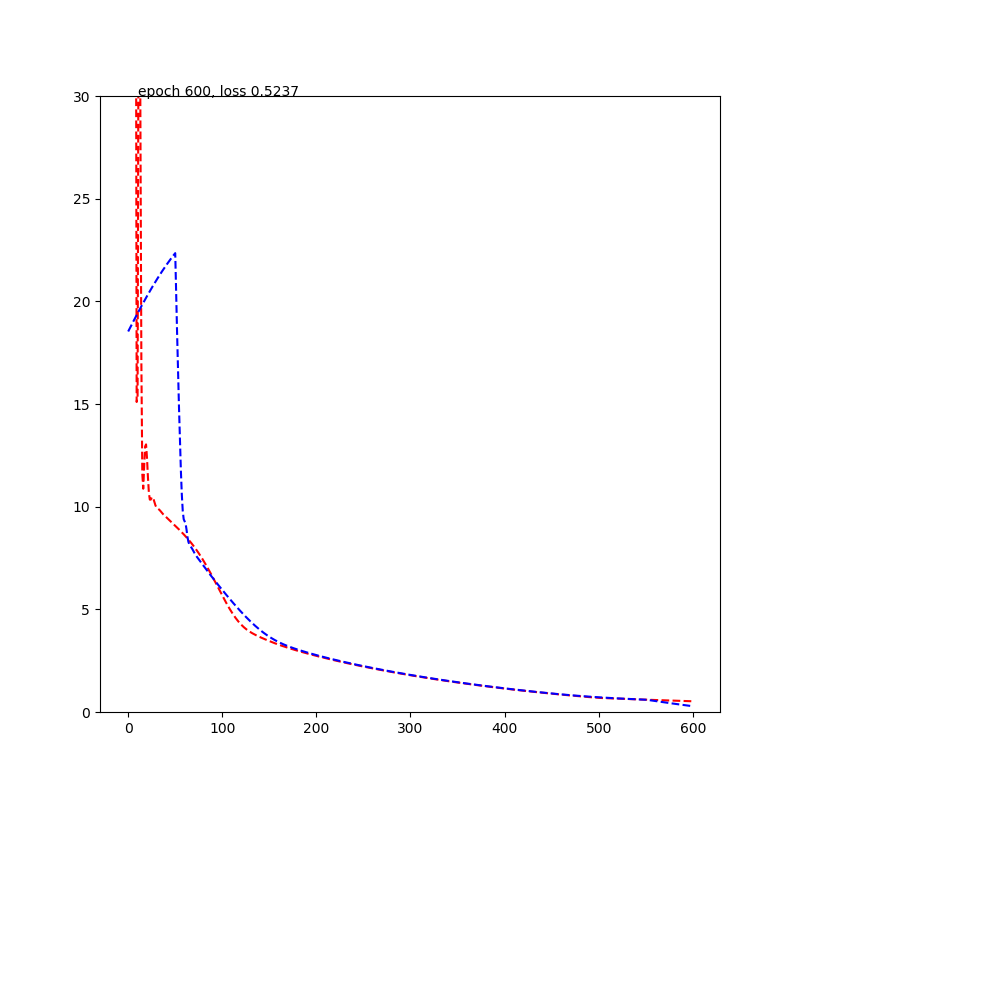

stop with loss 0.4992712736129761
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


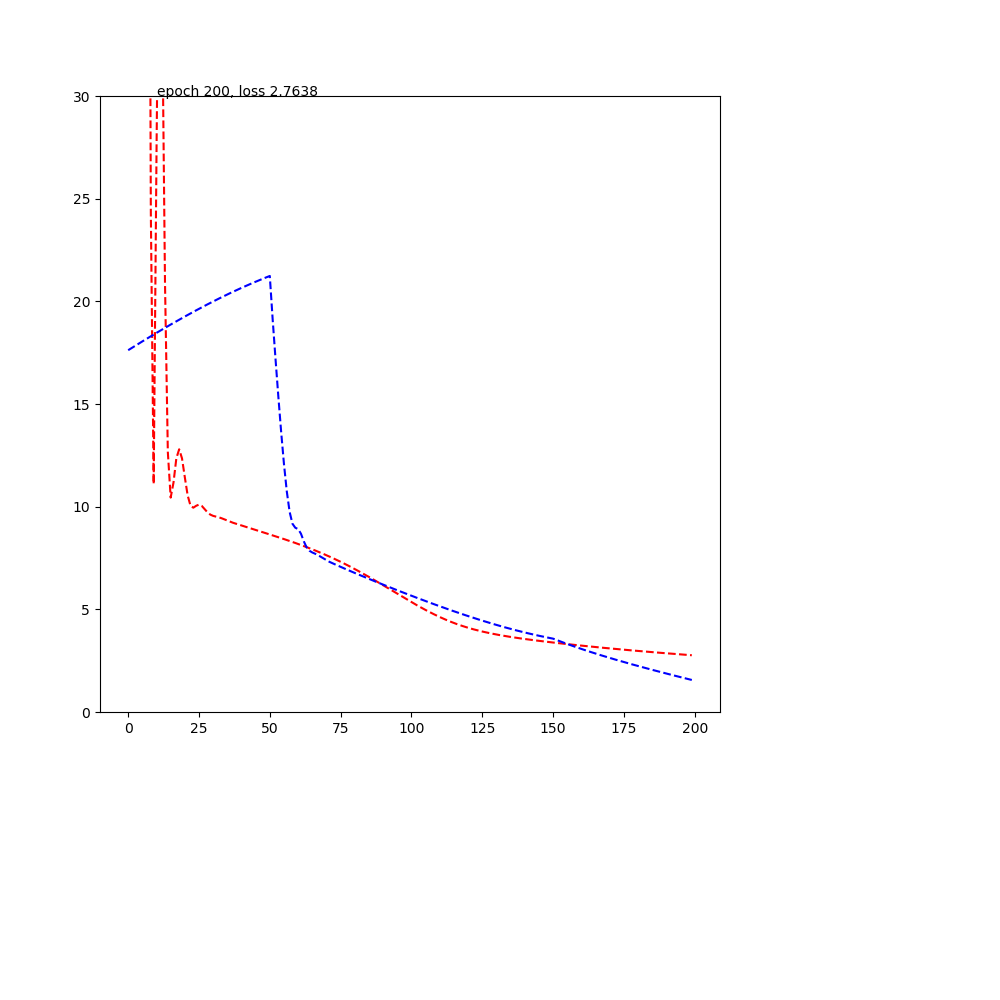

stop with loss 0.4987105131149292
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


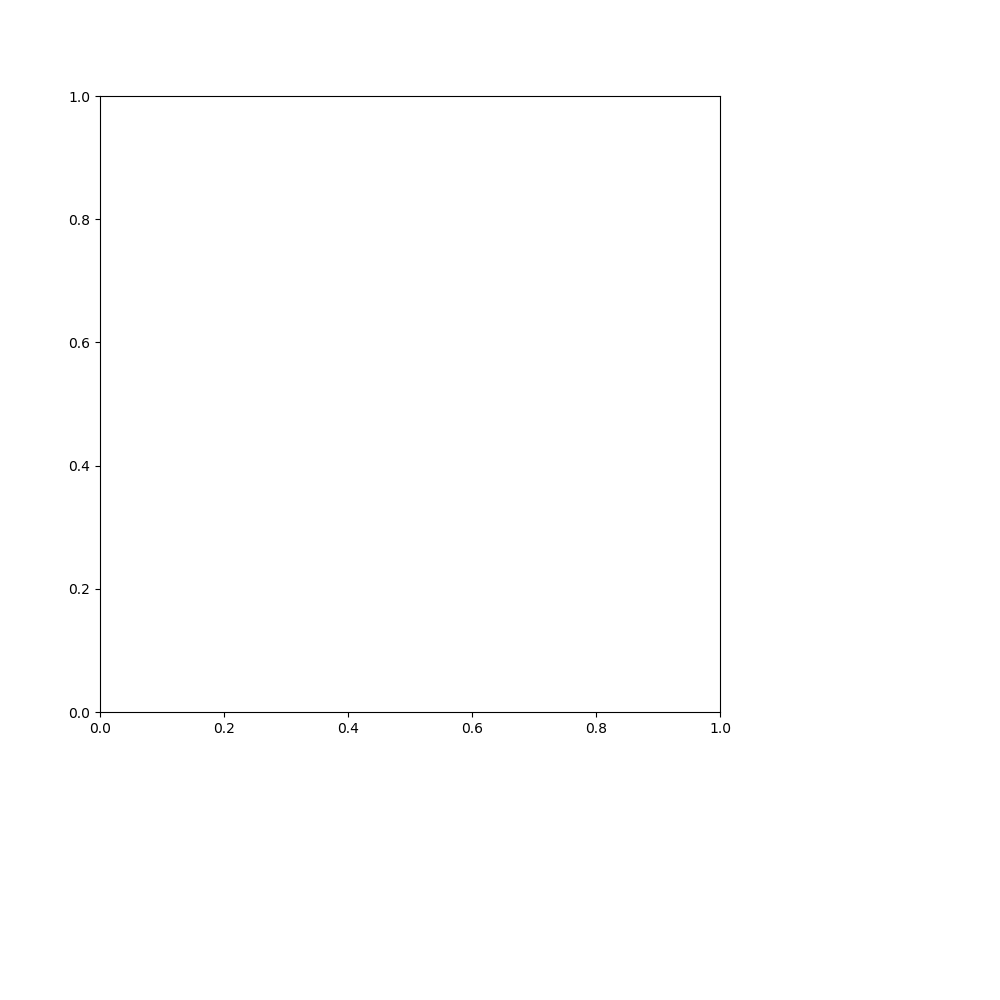

stop with loss 0.4986916780471802
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


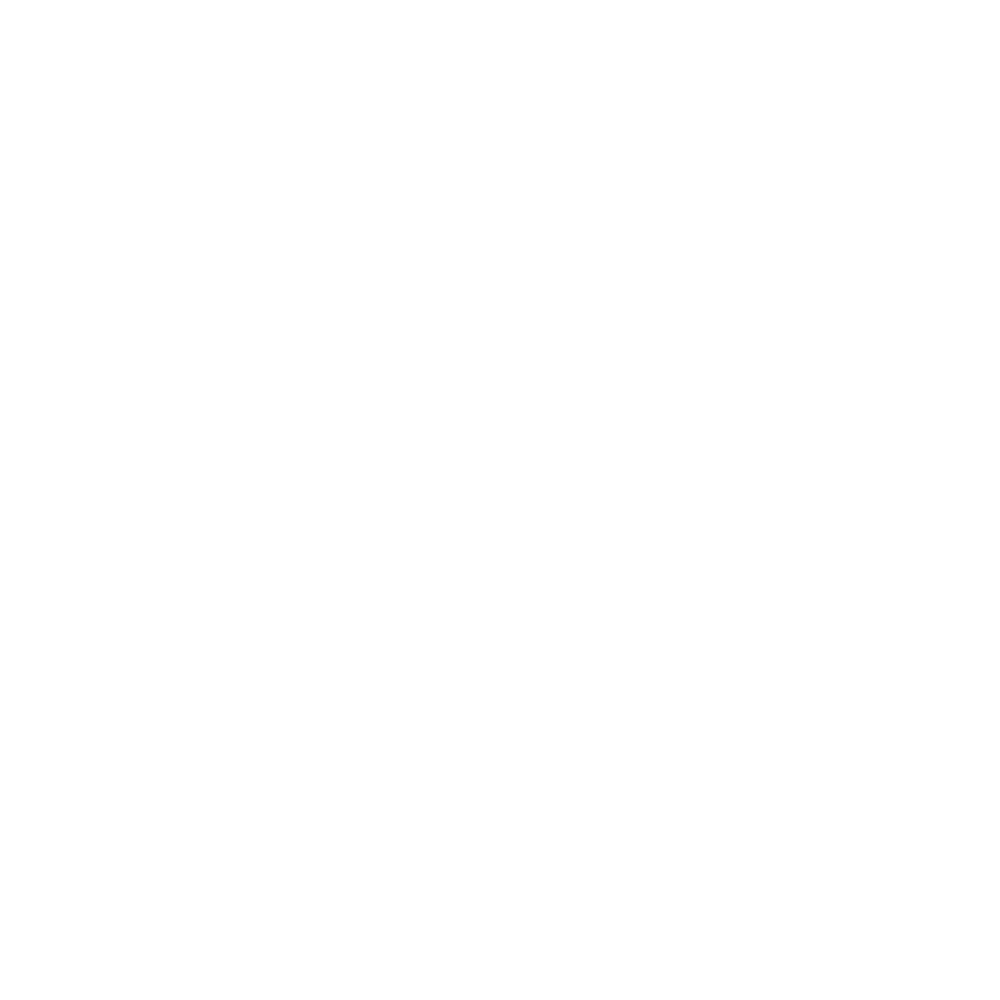

stop with loss 0.498731404542923
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


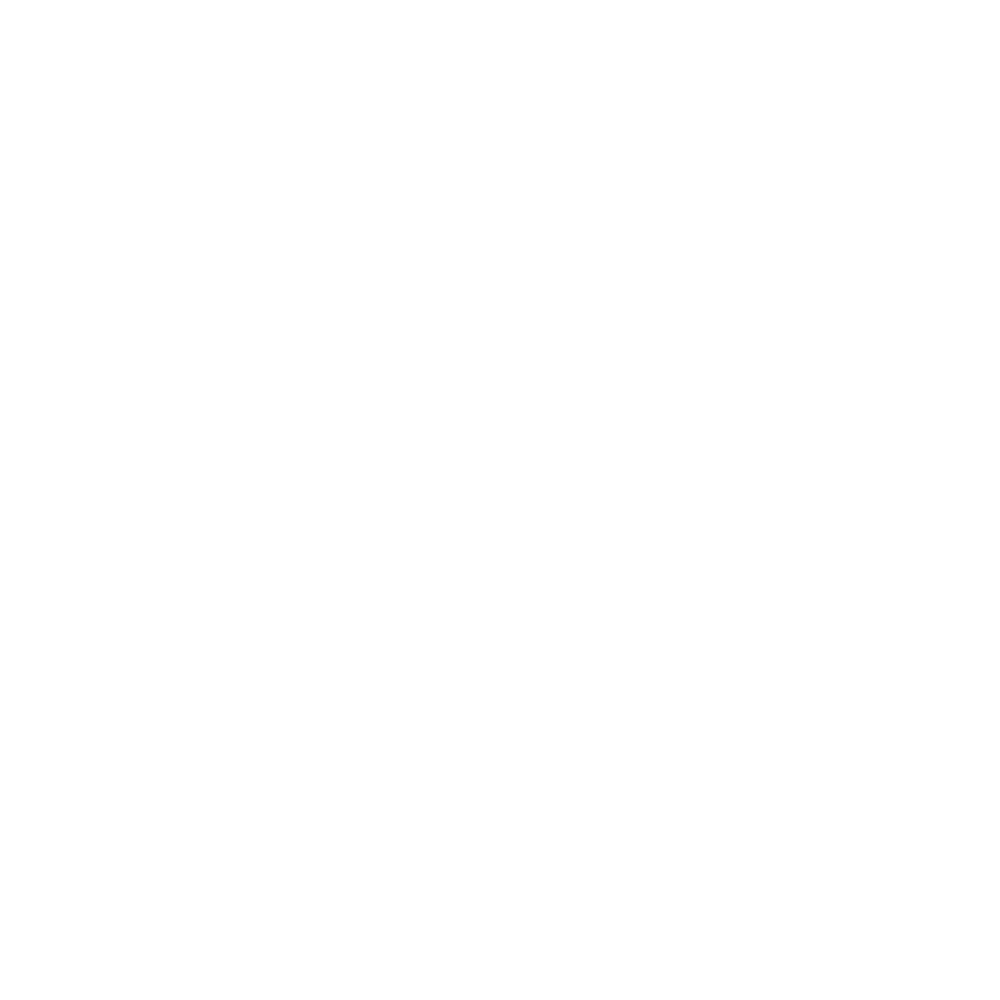

stop with loss 0.4990019202232361
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


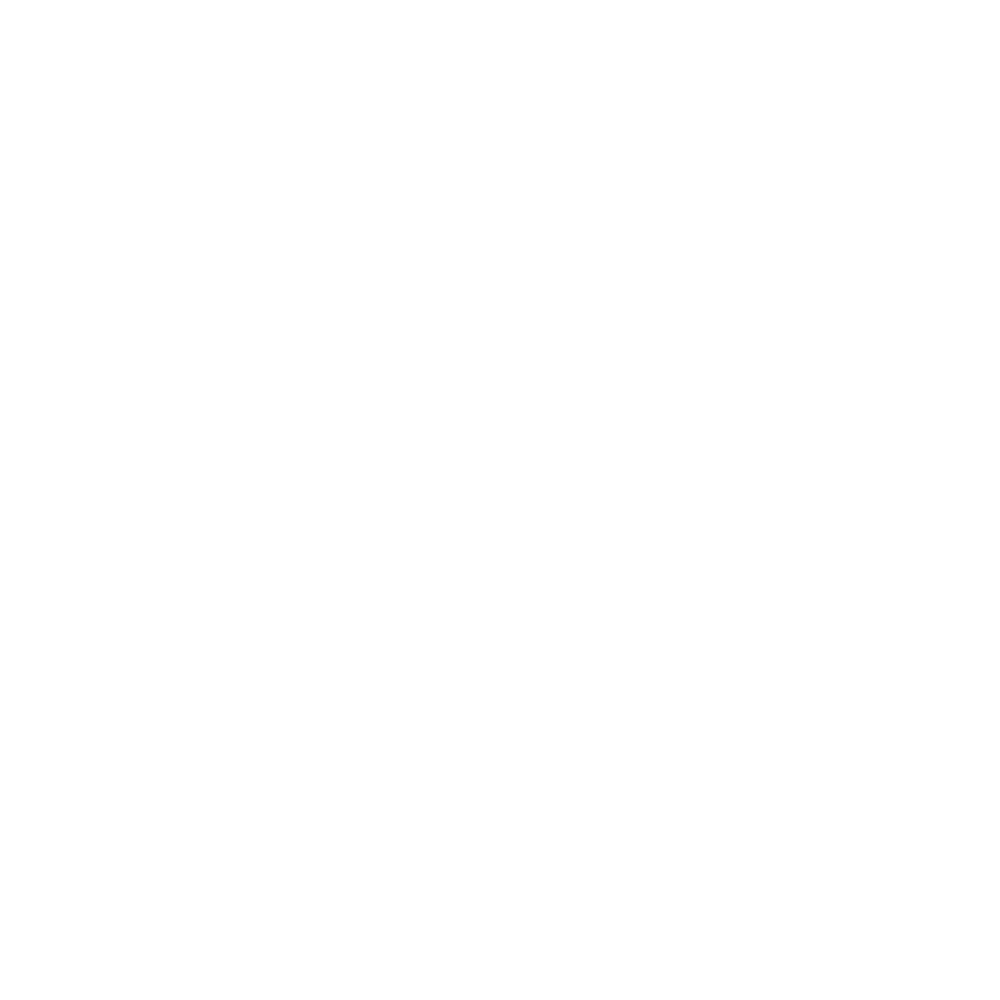

stop with loss 0.49853643774986267
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


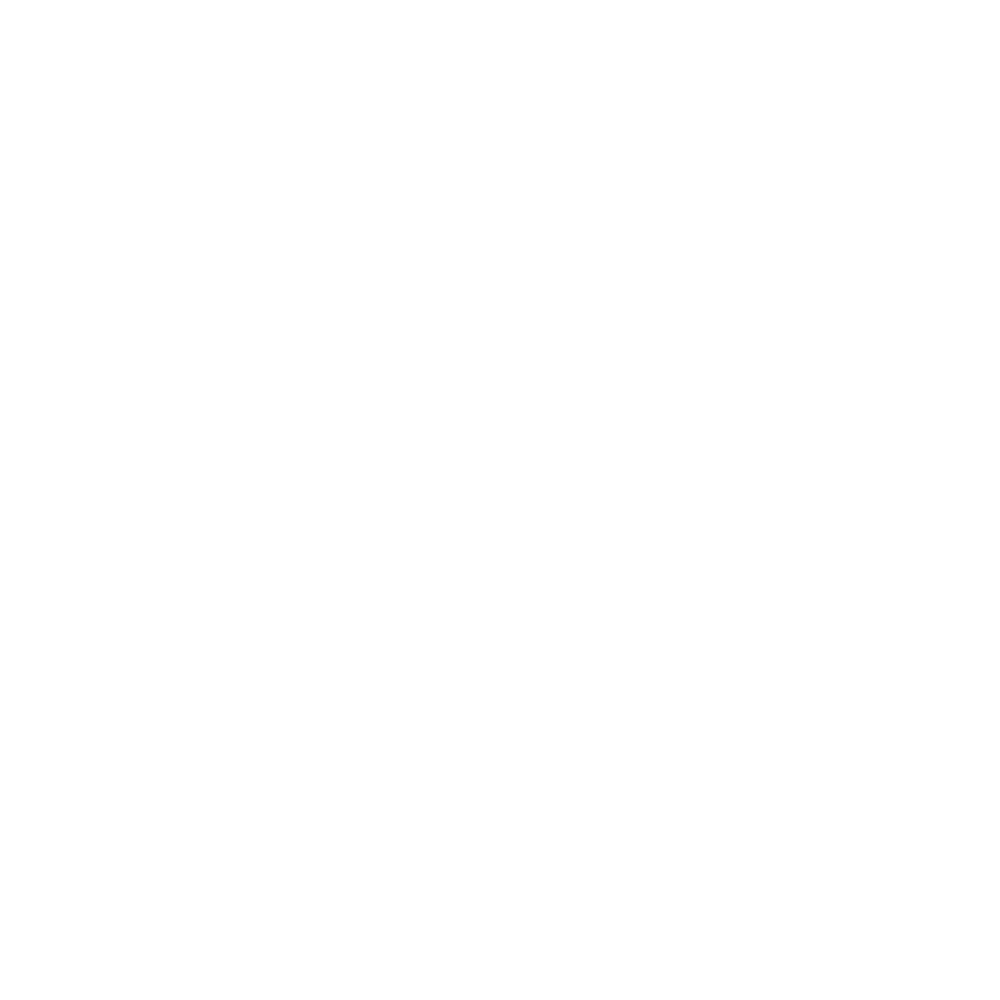

stop with loss 0.4999670386314392
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


<IPython.core.display.Javascript object>


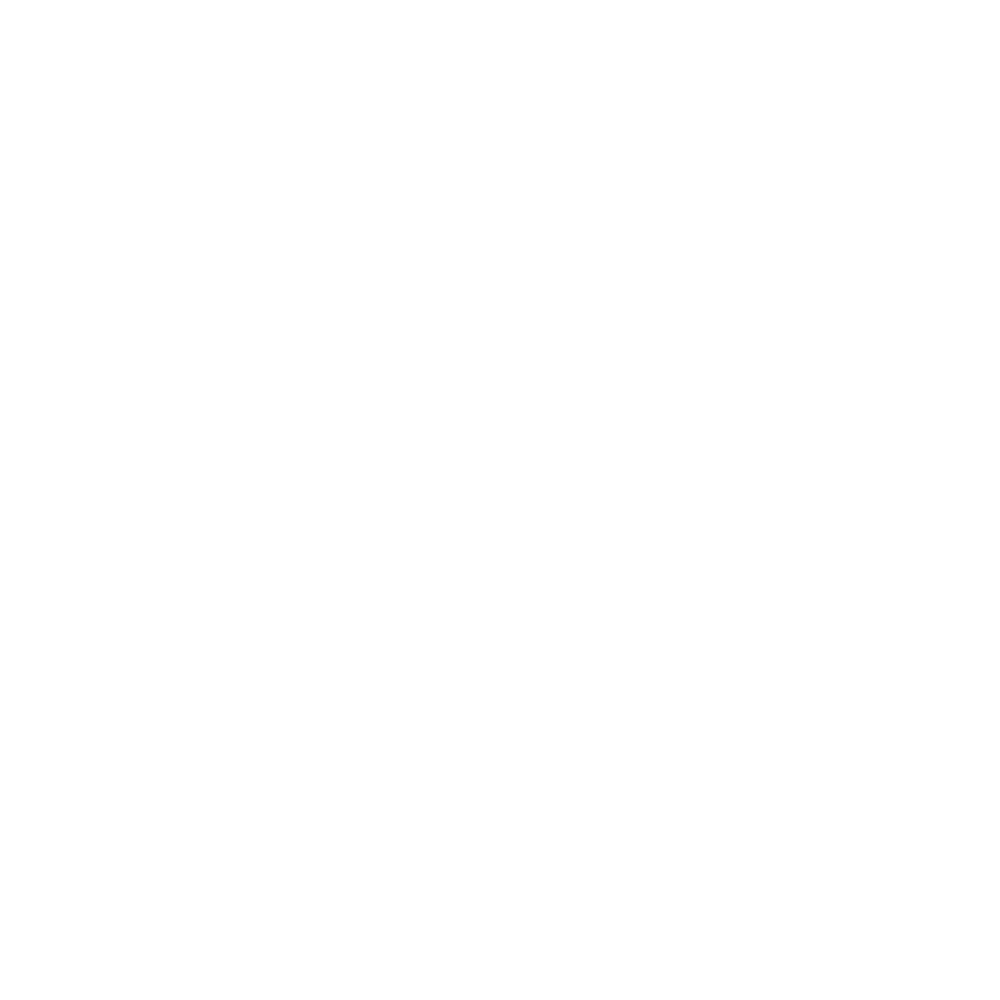

stop with loss 0.49929124116897583
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=140, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Linear(in_features=30, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:
stop with loss 0.4964371621608734
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=

C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


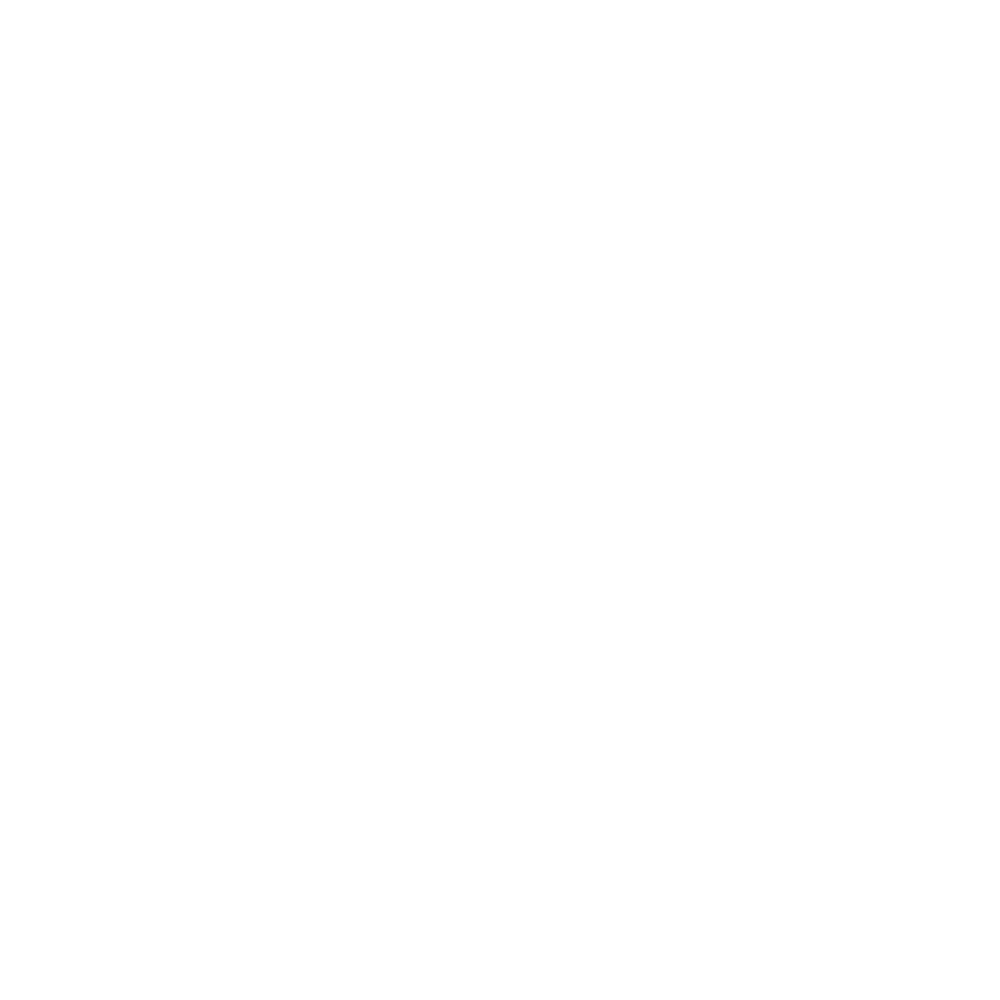

stop with loss 0.4949585795402527
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


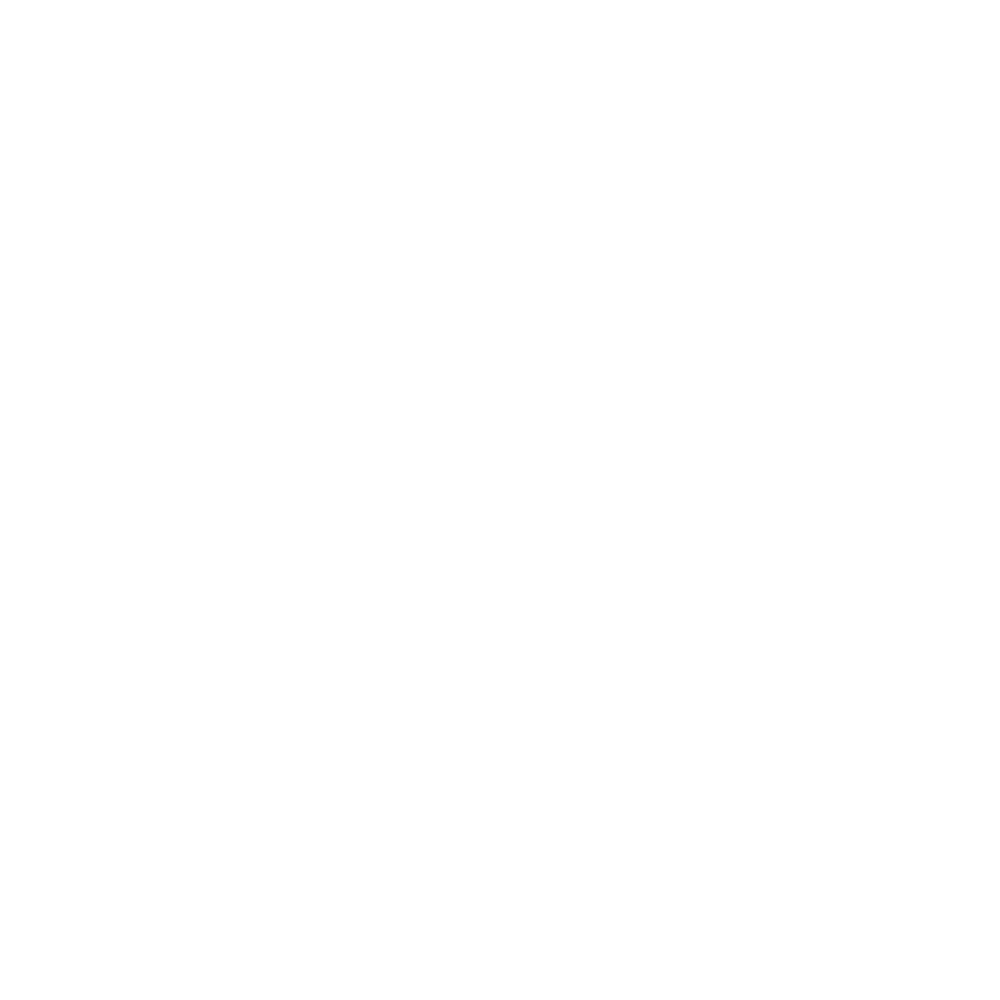

stop with loss 0.4976930618286133
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


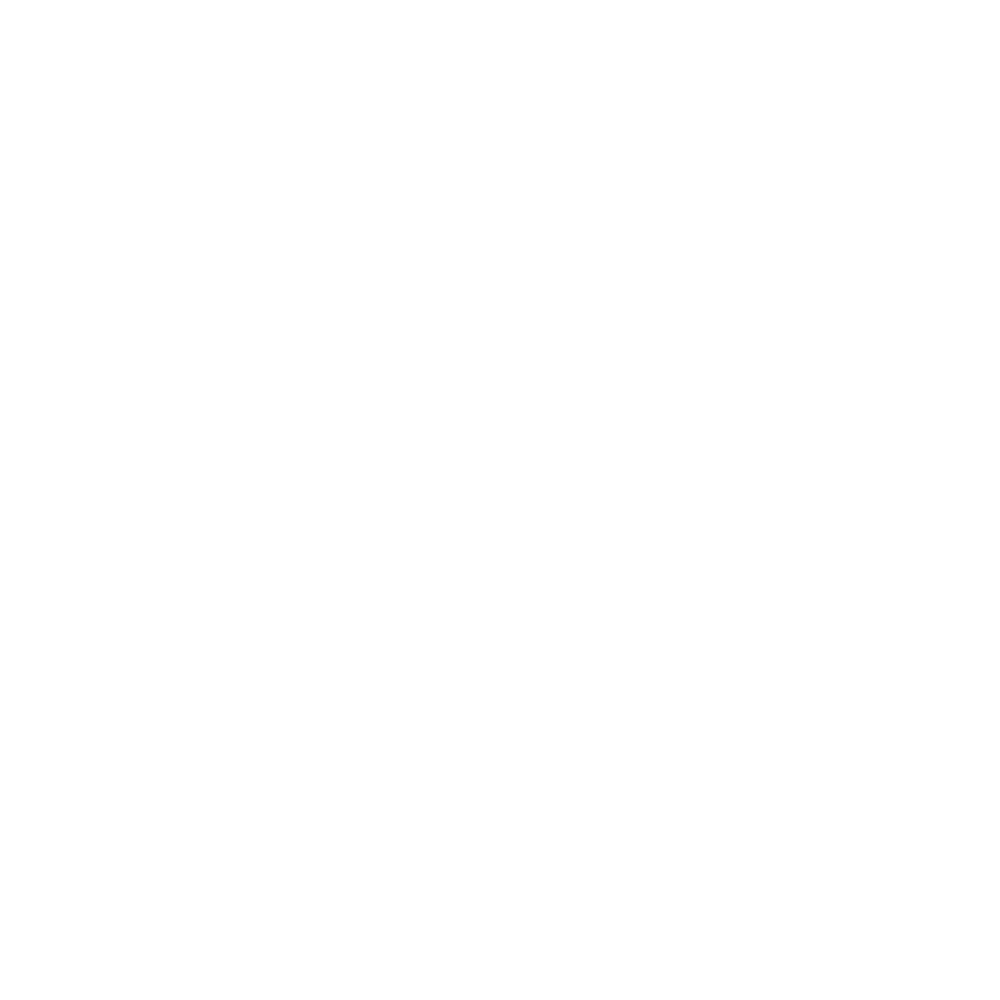

stop with loss 0.4988678991794586
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


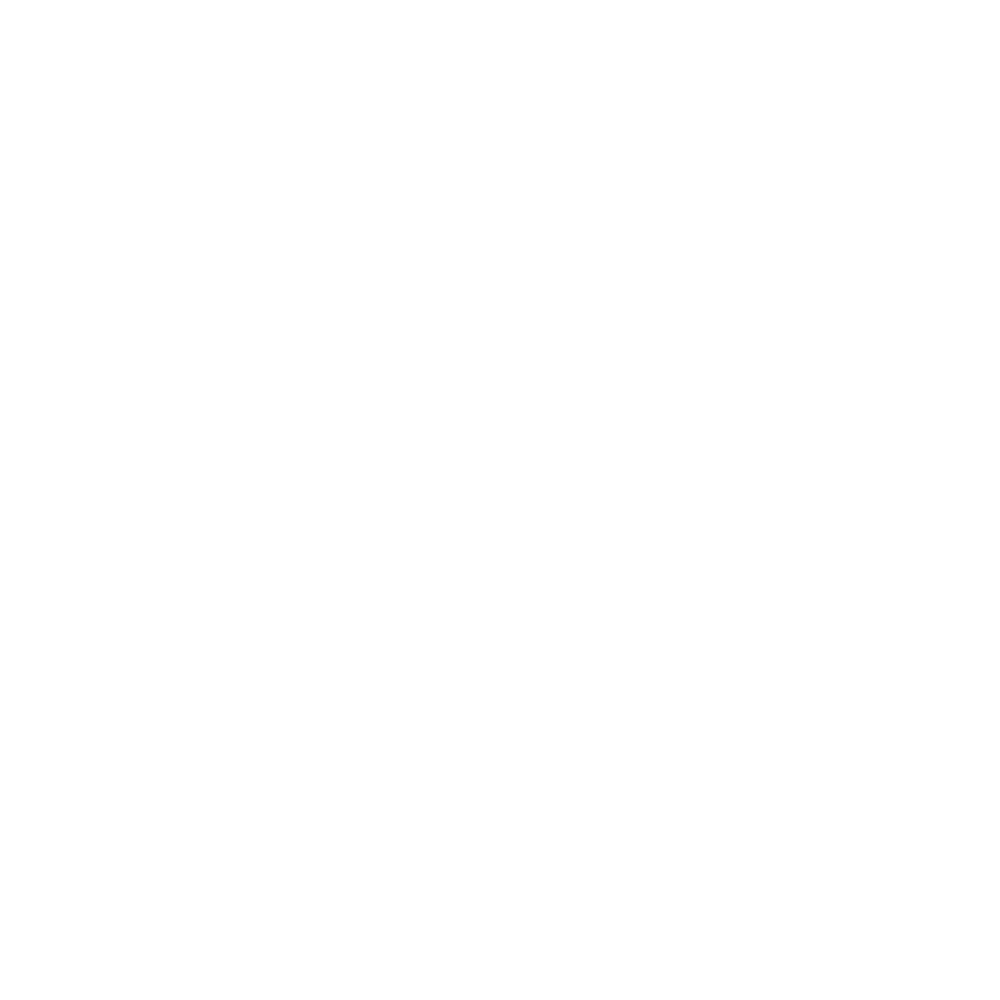

stop with loss 0.4975369870662689
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


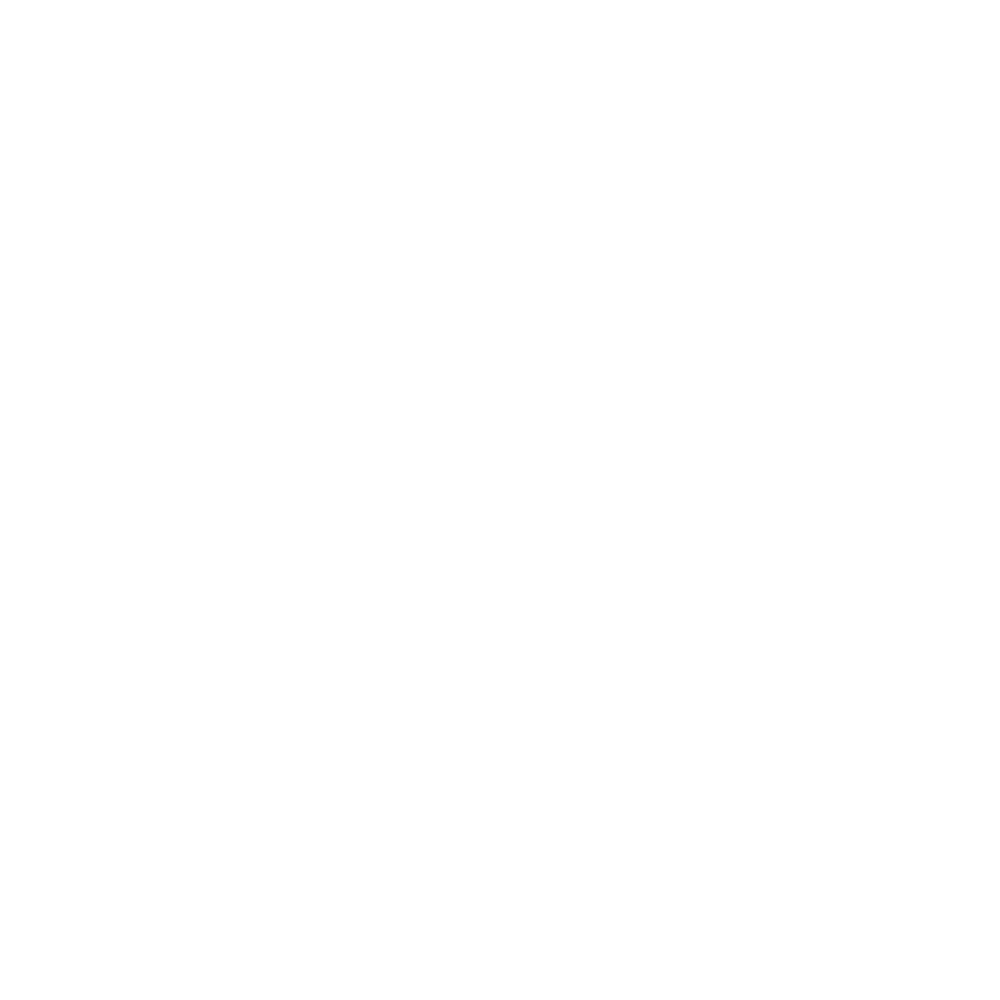

stop with loss 0.49862855672836304
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


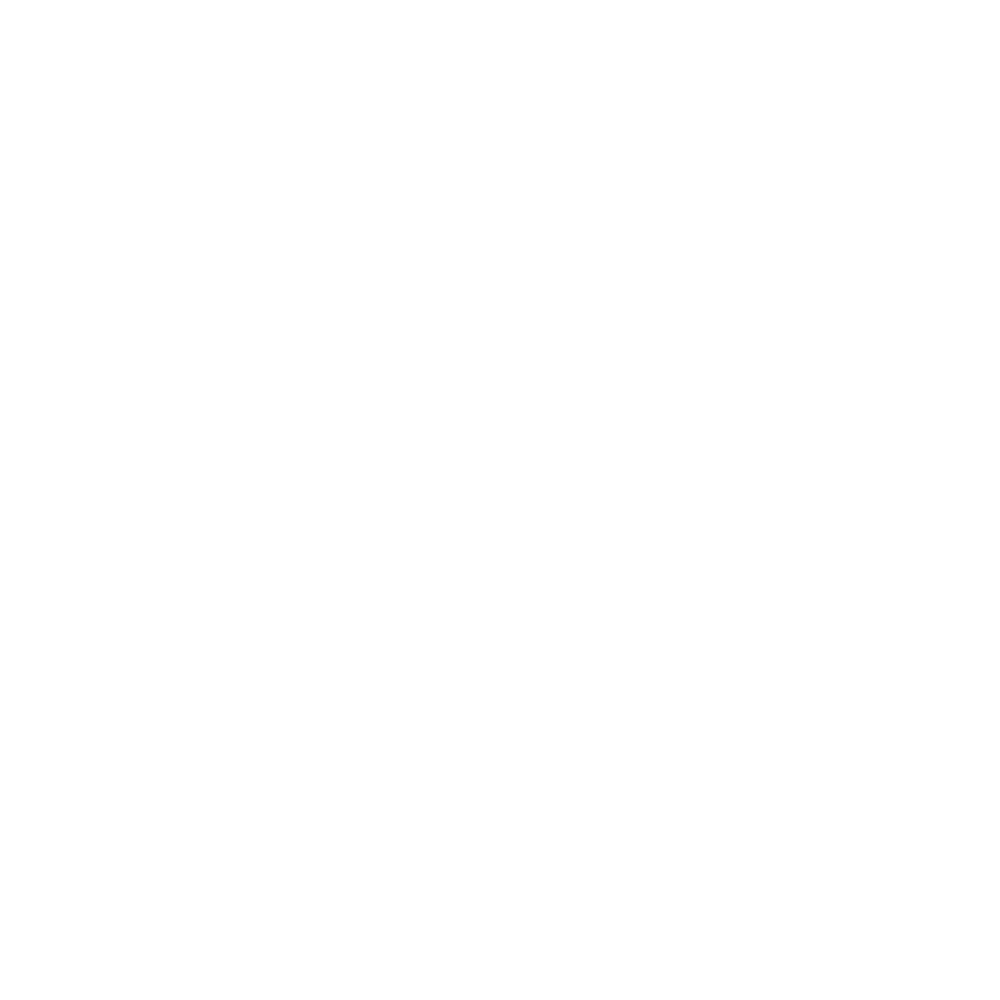

stop with loss 0.49795448780059814
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


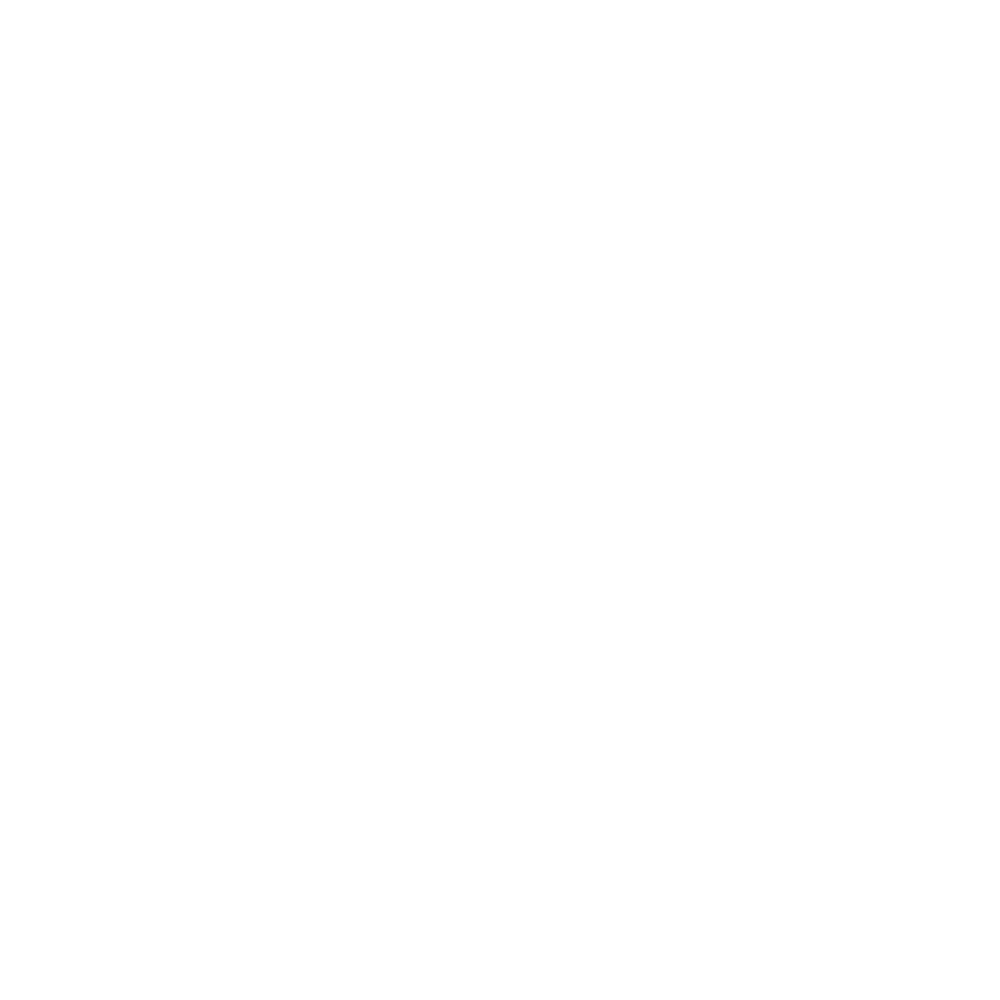

stop with loss 0.49745652079582214
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=246, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


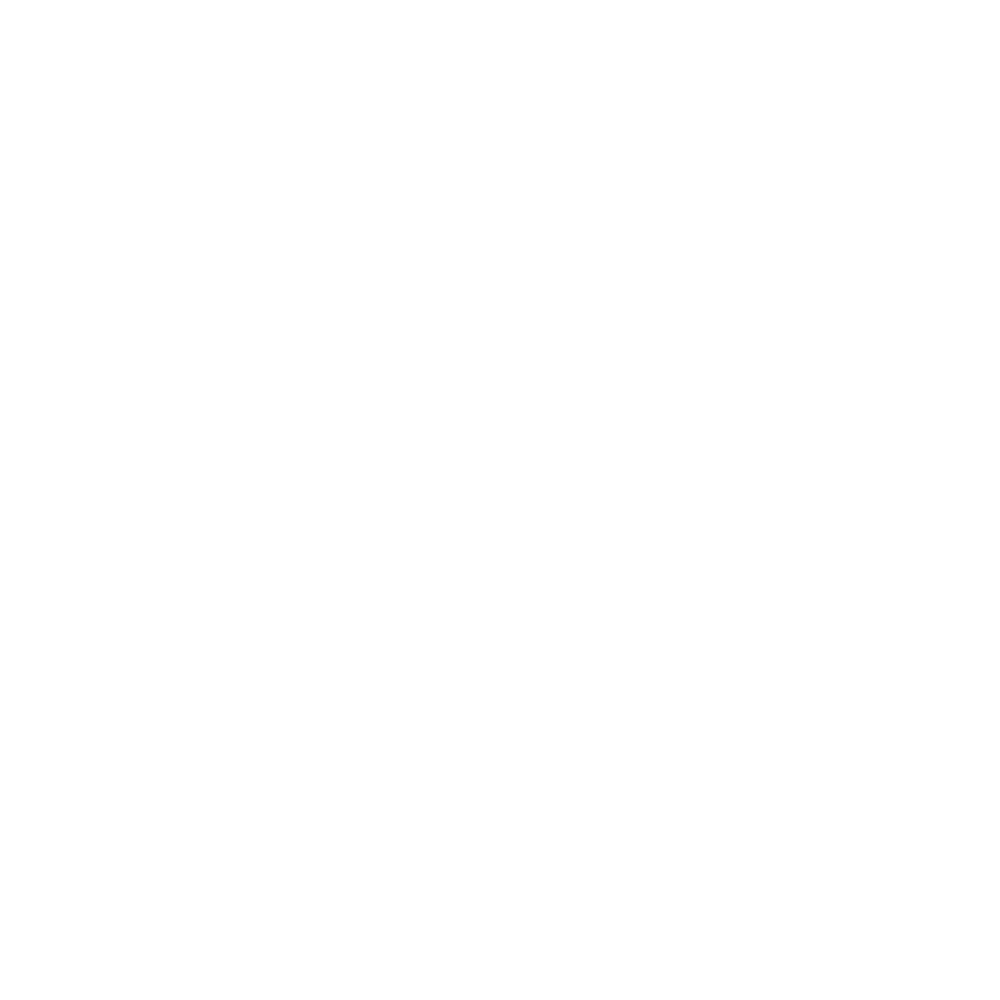

stop with loss 0.4968056380748749
processing on: %s -------------------------- FA
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


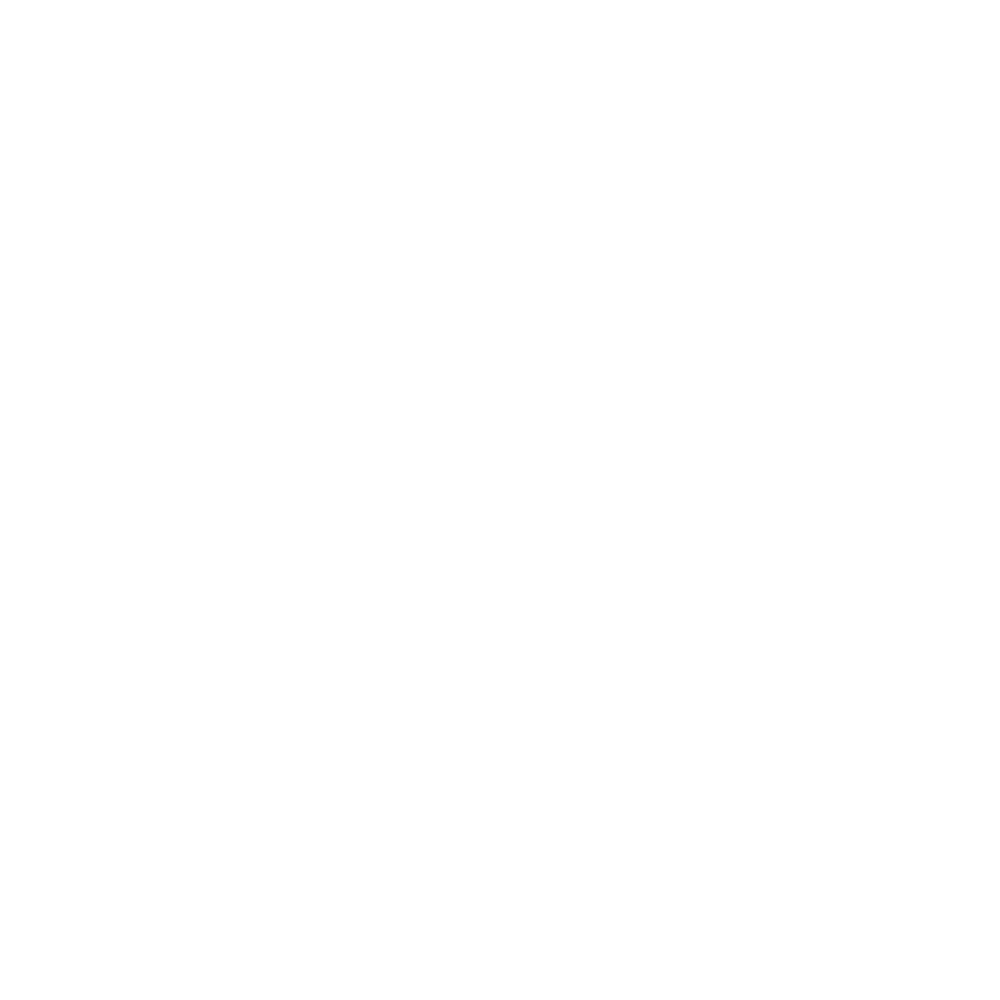

stop with loss 0.4987320899963379
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


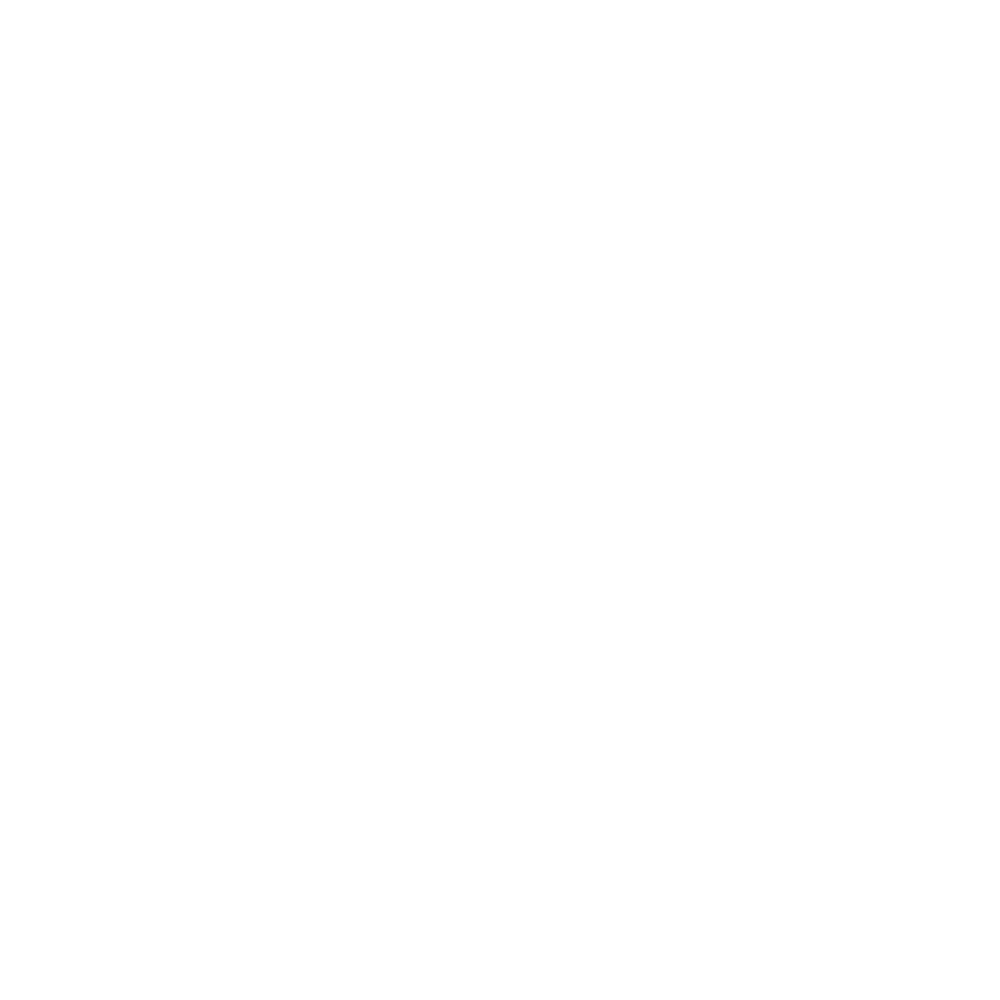

stop with loss 0.4997519850730896
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


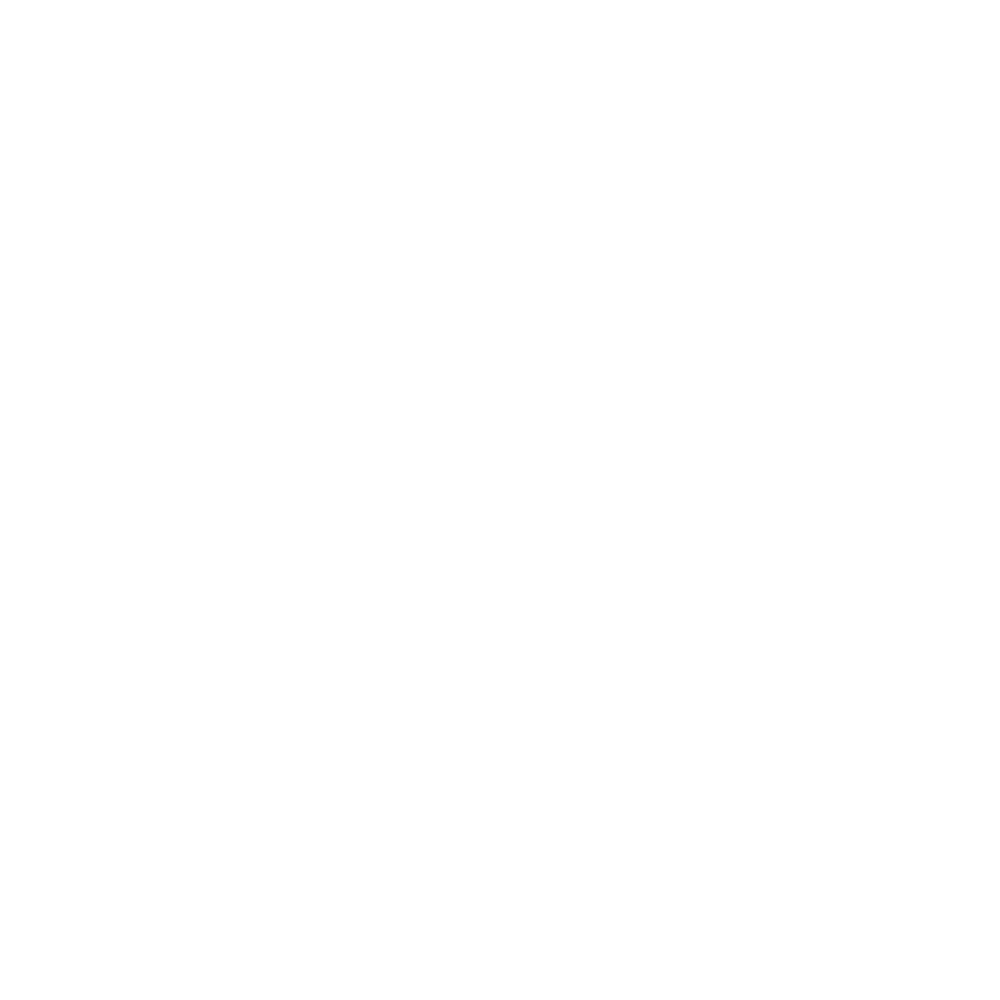

stop with loss 0.49886220693588257
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


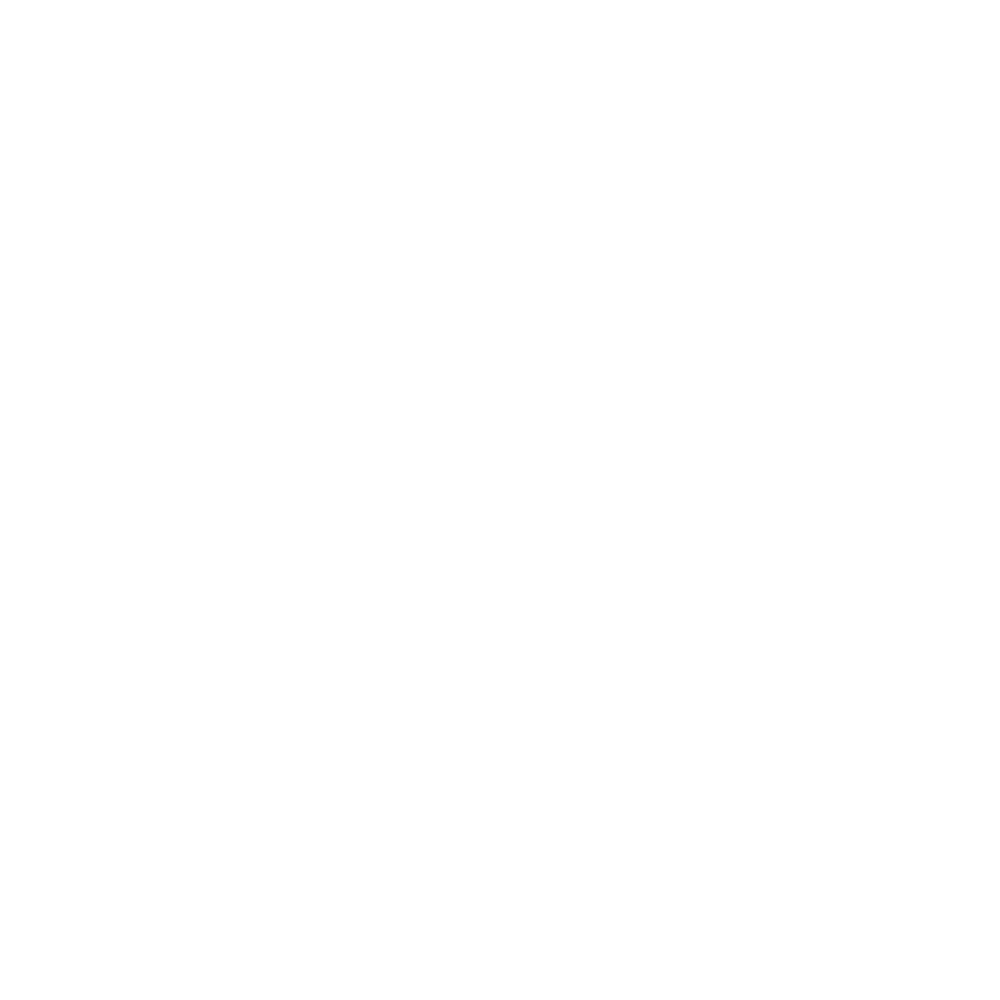

stop with loss 0.49982360005378723
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


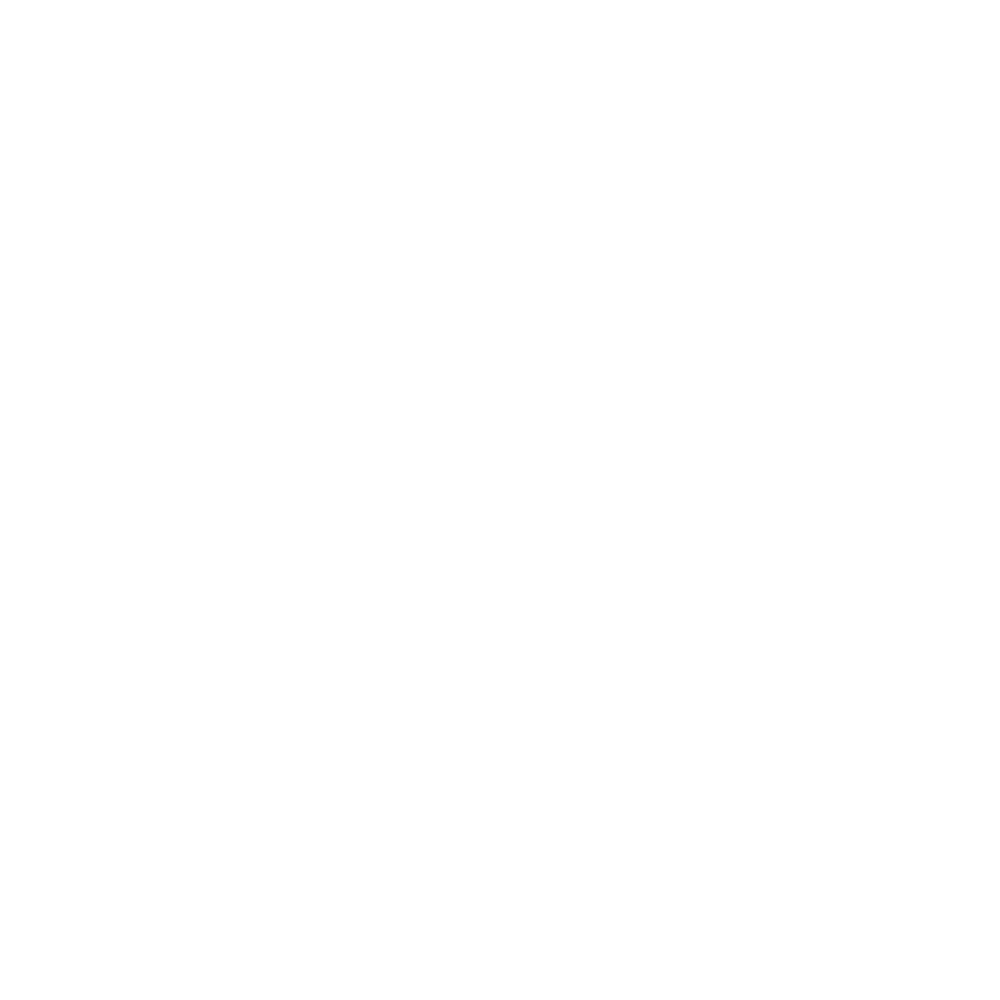

stop with loss 0.4993875026702881
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


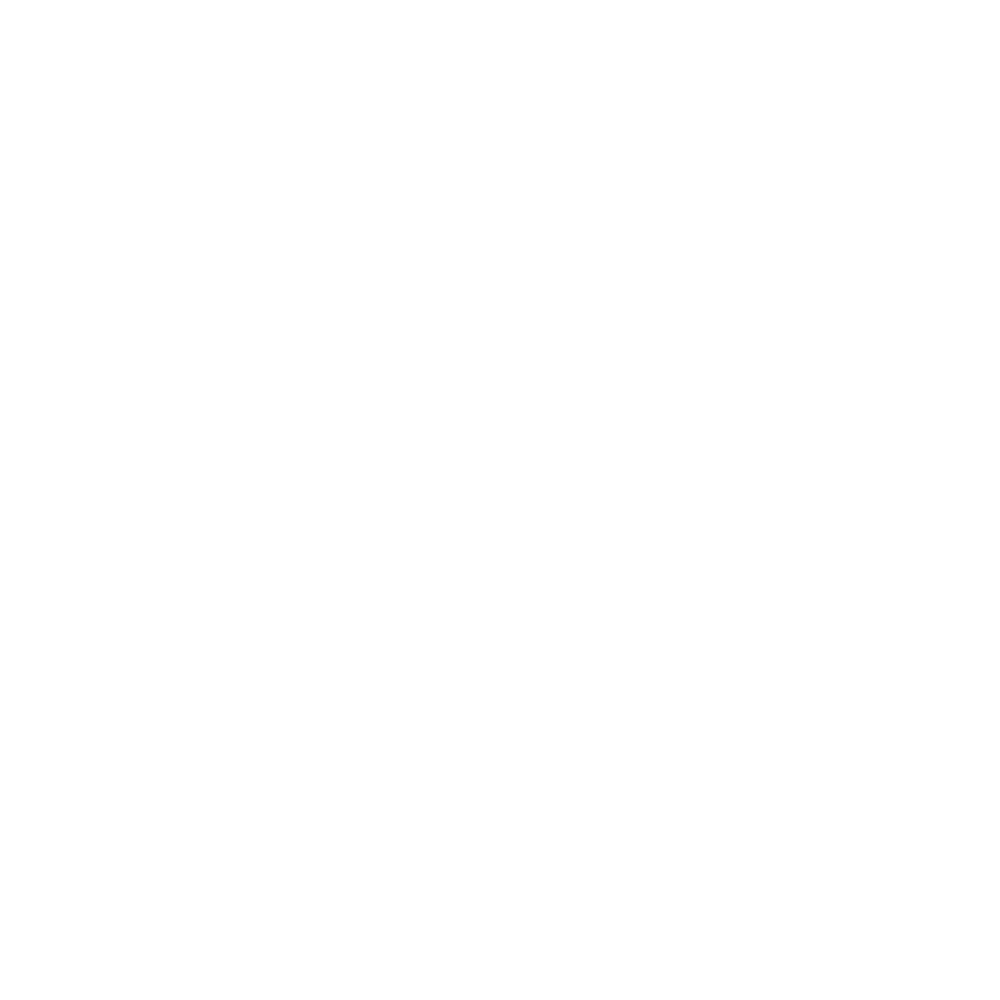

stop with loss 0.49910444021224976
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


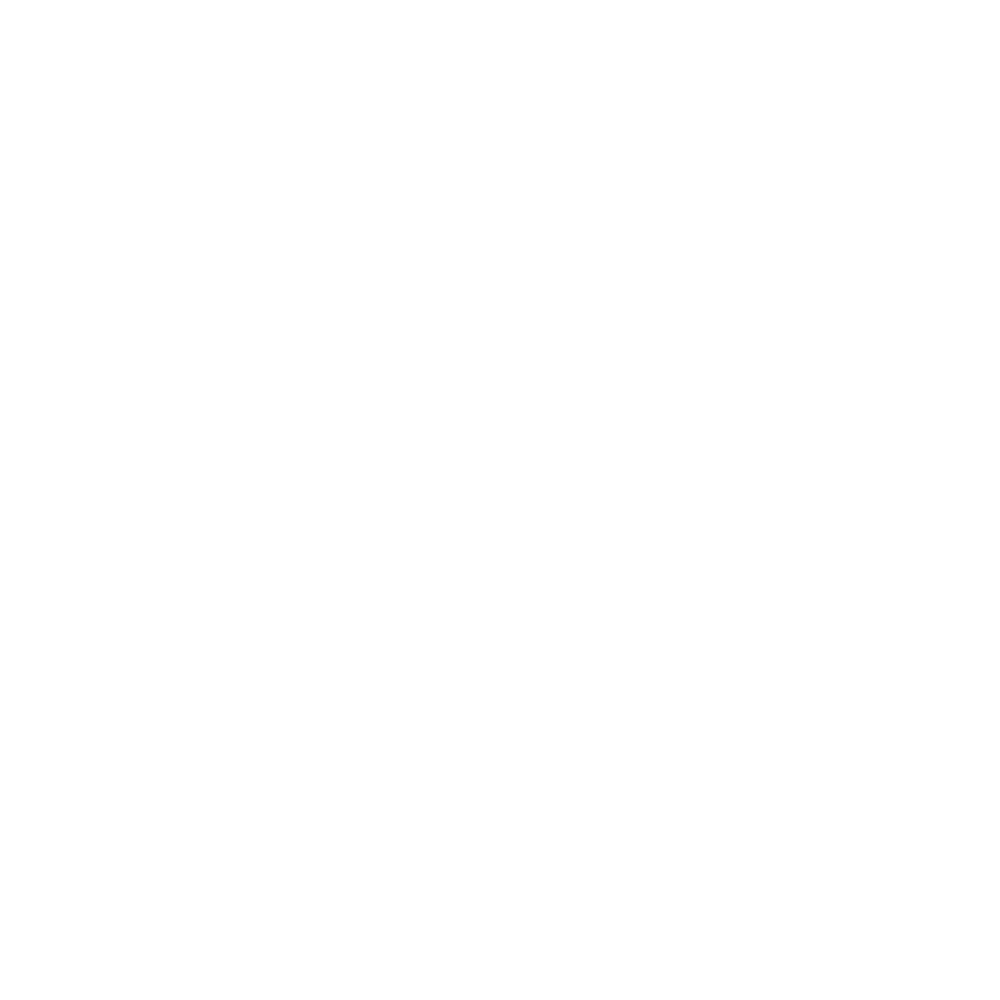

stop with loss 0.4984336197376251
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


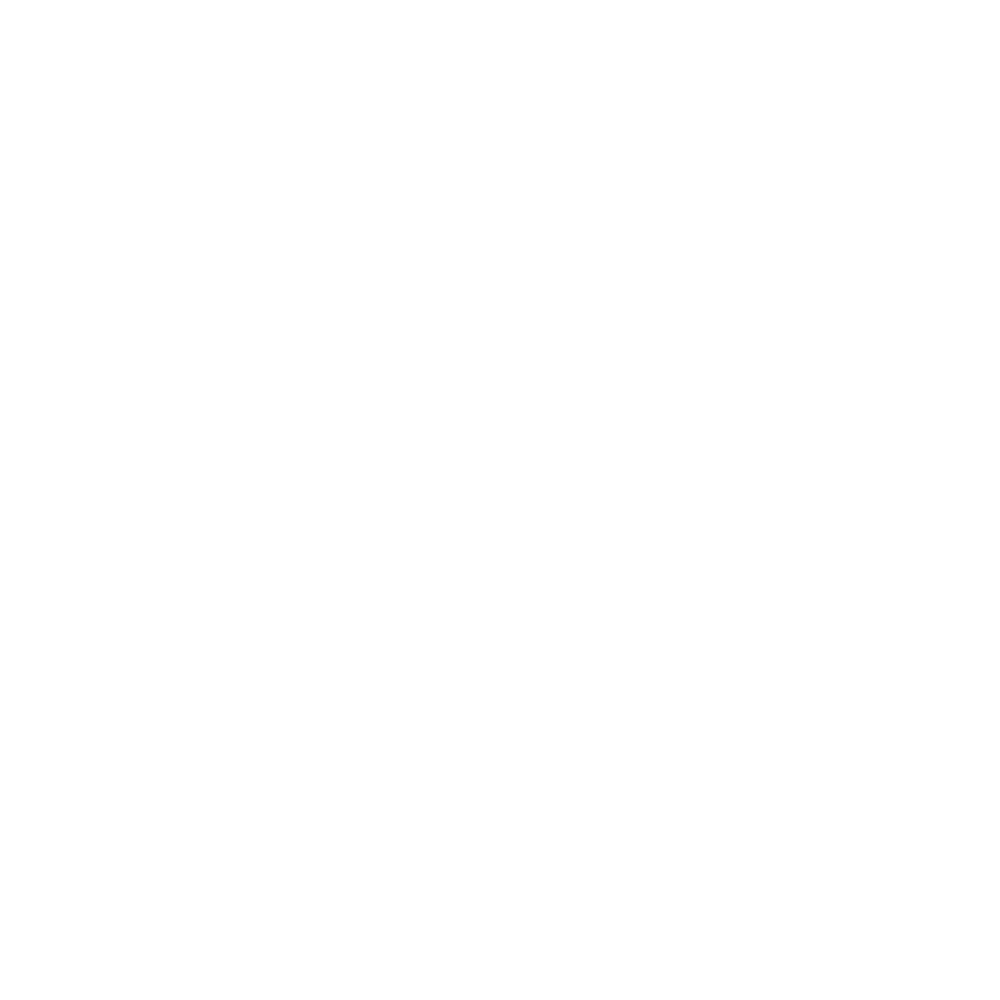

stop with loss 0.49994519352912903
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


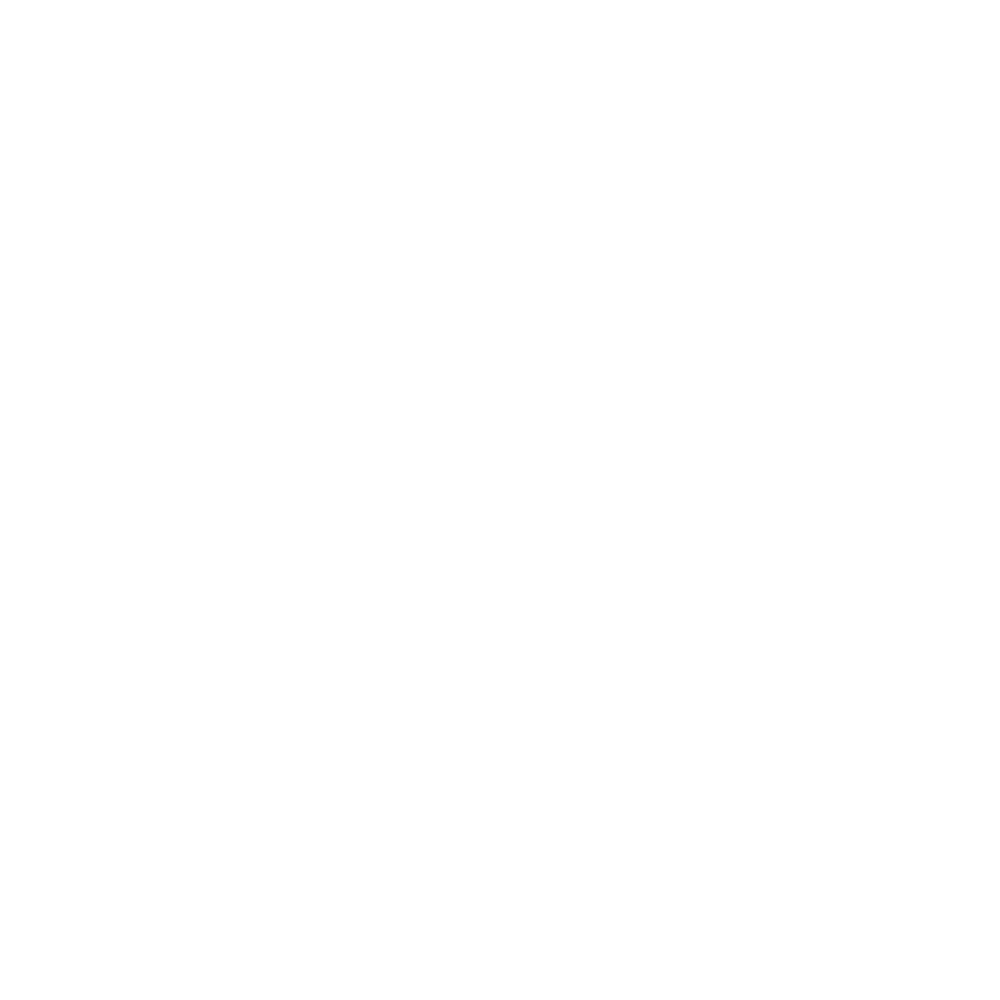

stop with loss 0.49944818019866943
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


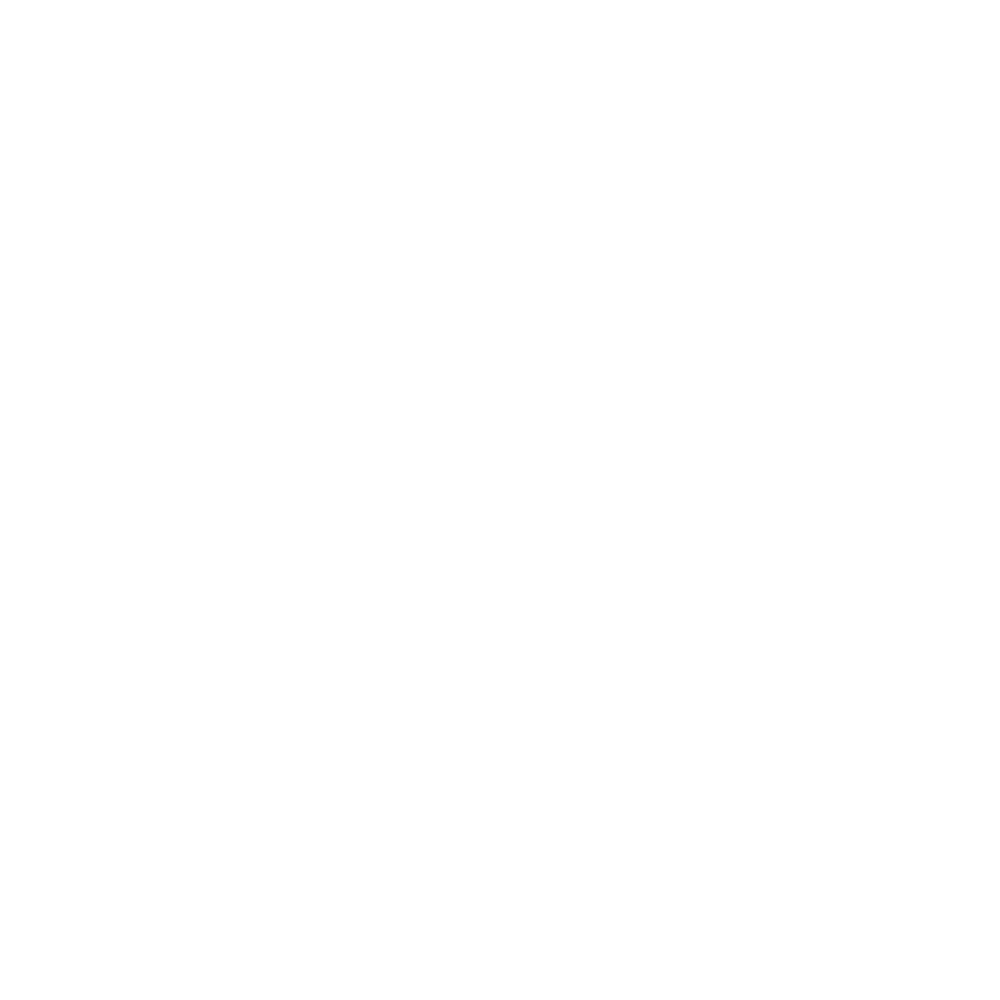

stop with loss 0.49860137701034546
processing on: %s -------------------------- MD
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


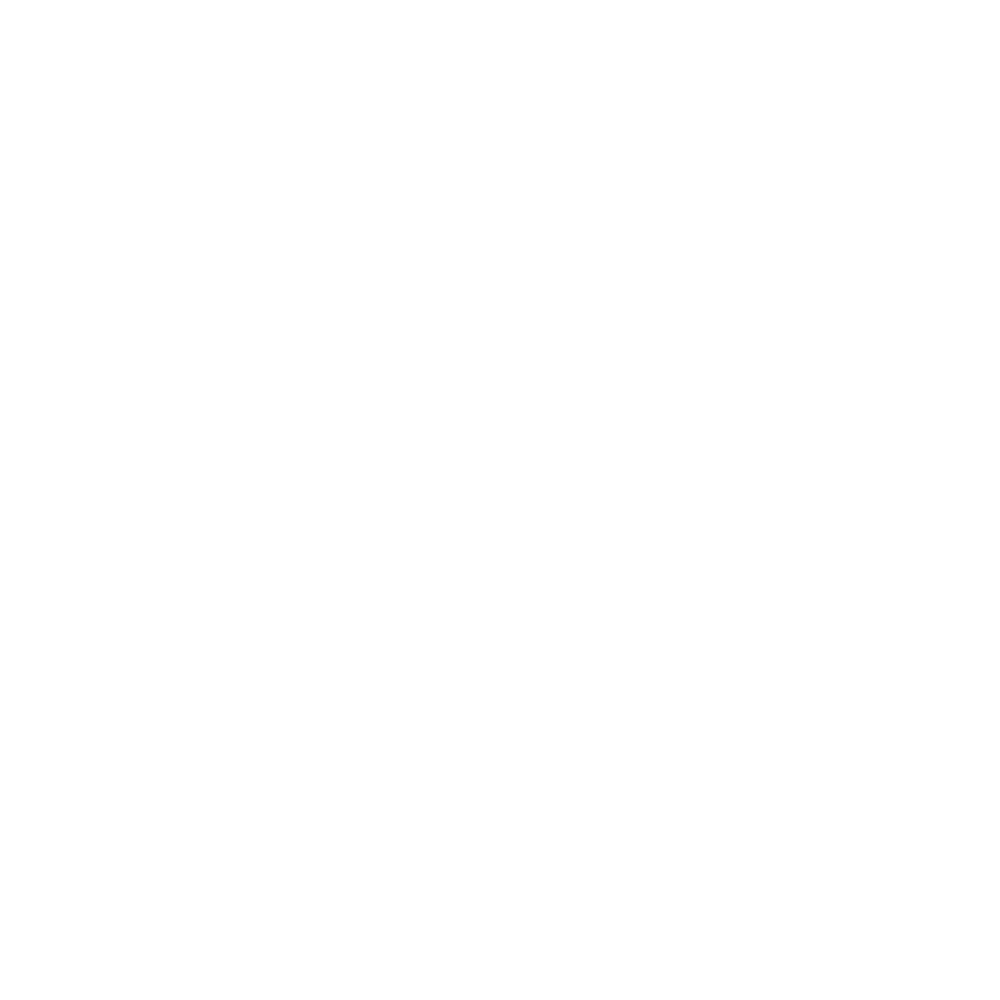

stop with loss 0.49937769770622253
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


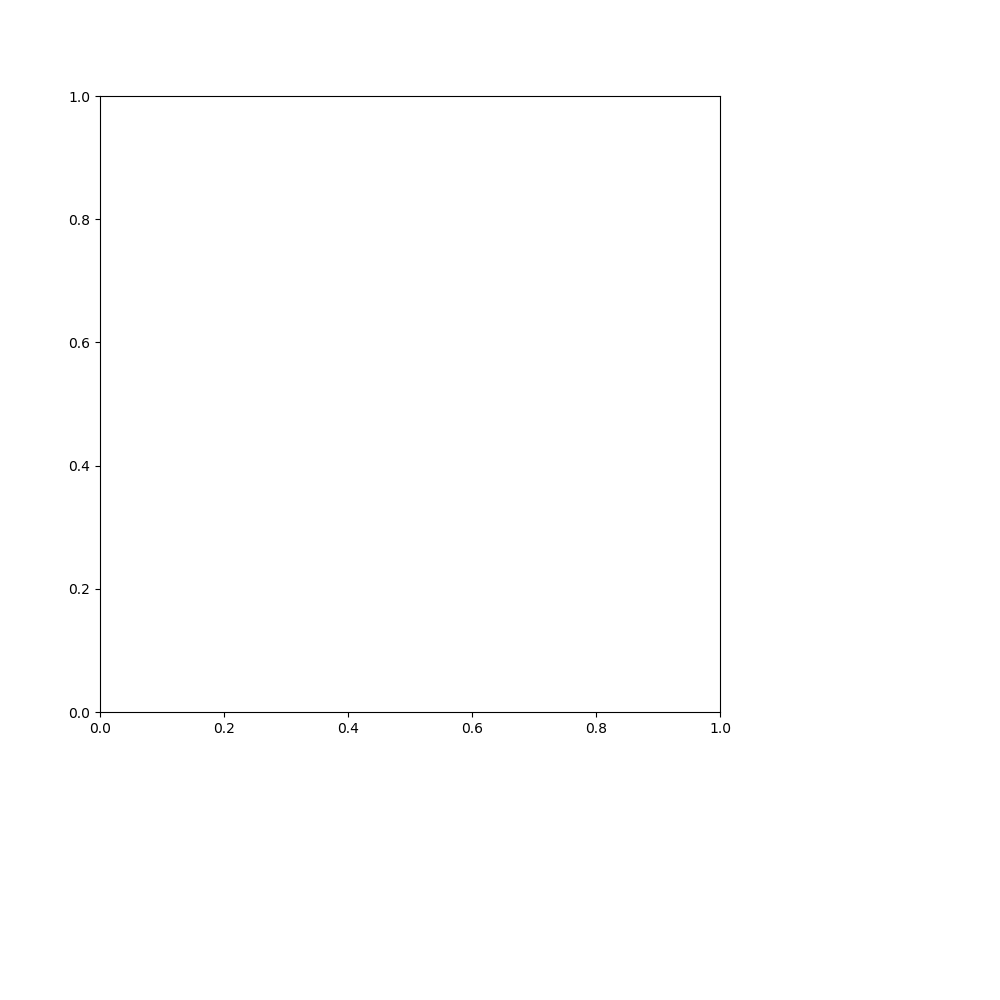

stop with loss 0.49940627813339233
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


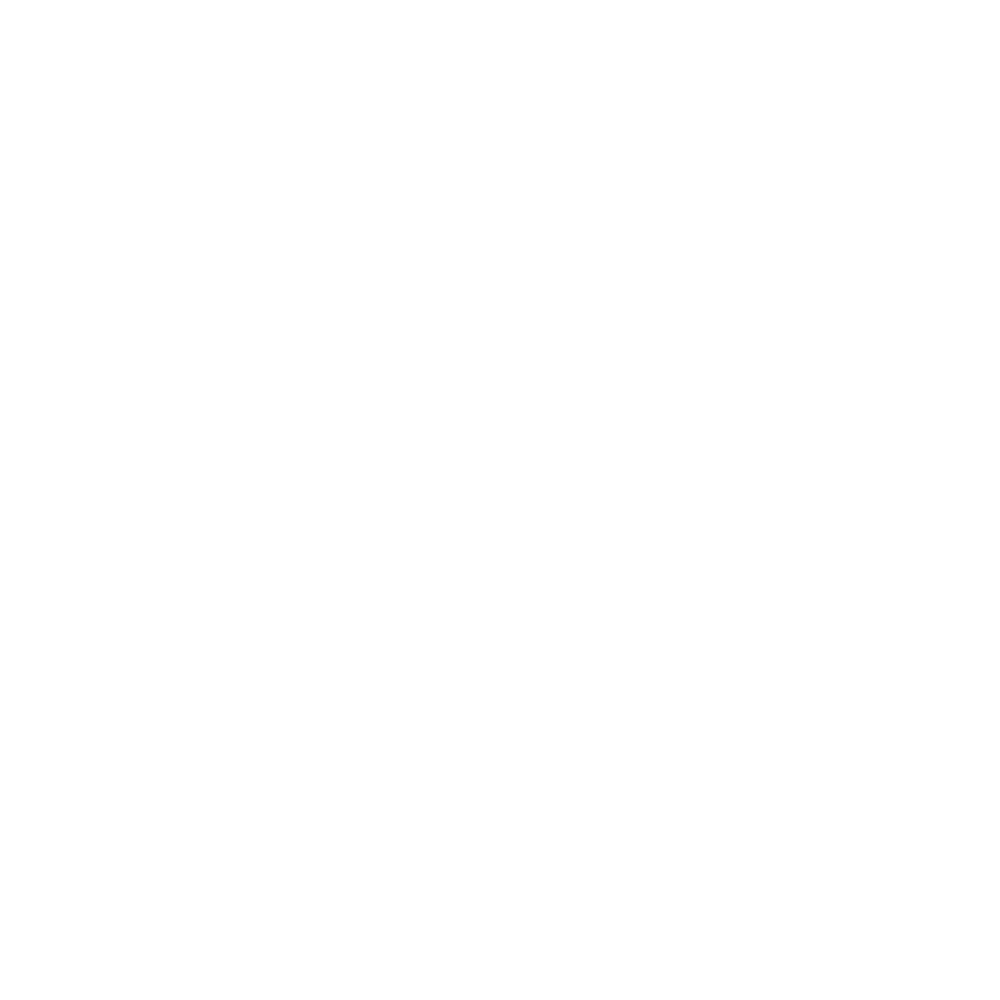

stop with loss 0.4989382028579712
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


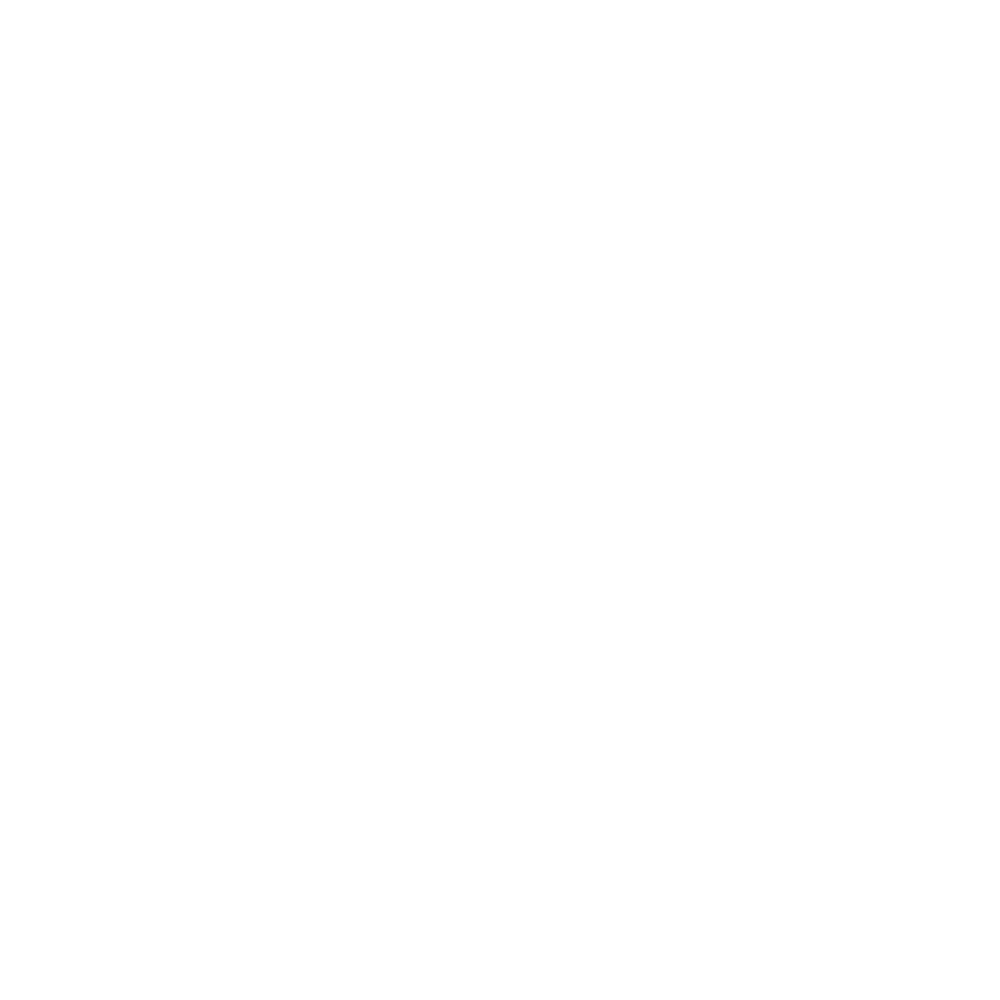

stop with loss 0.4997917413711548
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


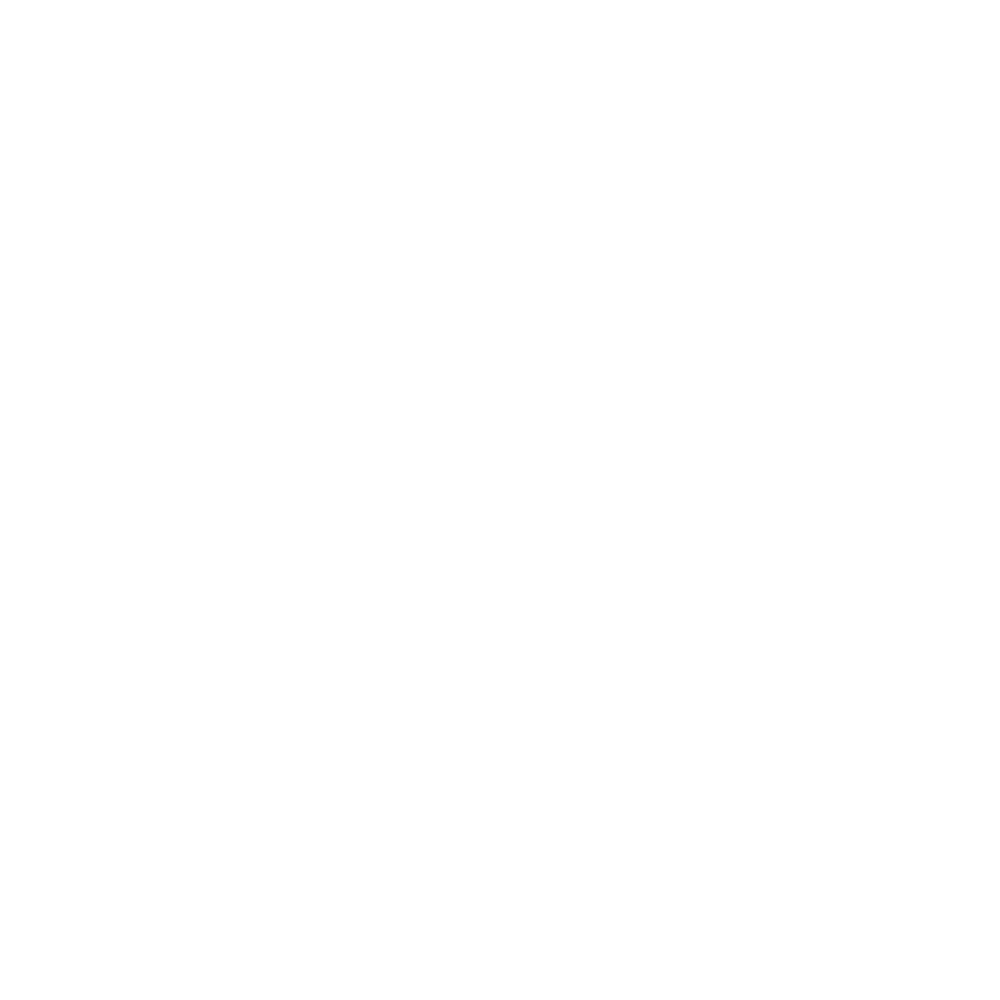

stop with loss 0.4992353618144989
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


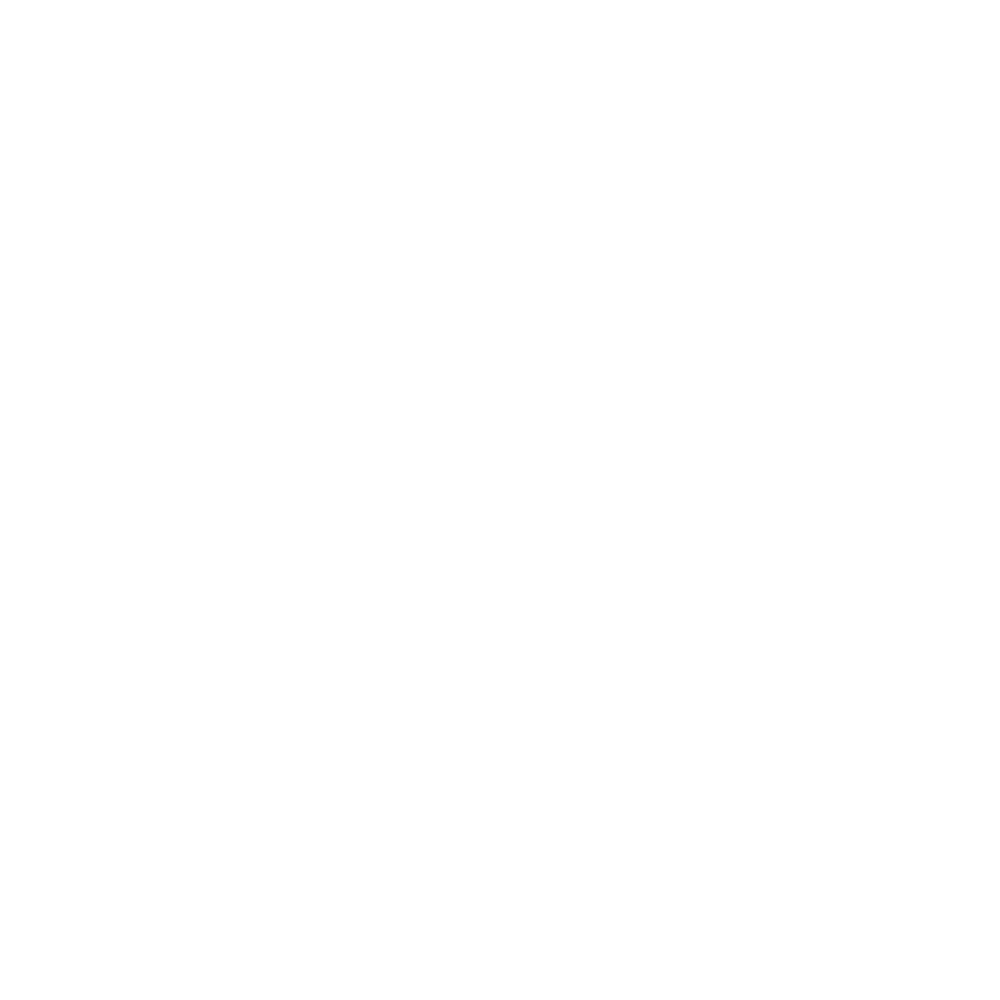

stop with loss 0.4997086822986603
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


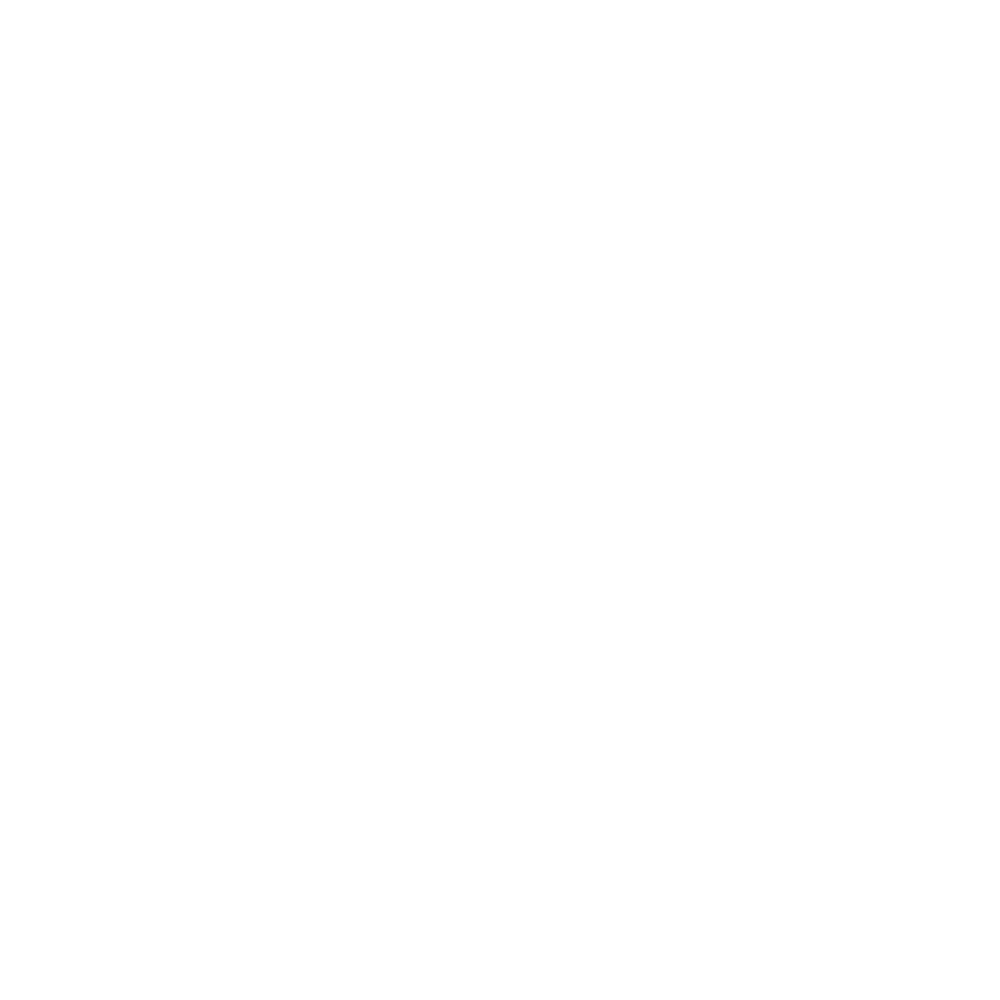

stop with loss 0.49919143319129944
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


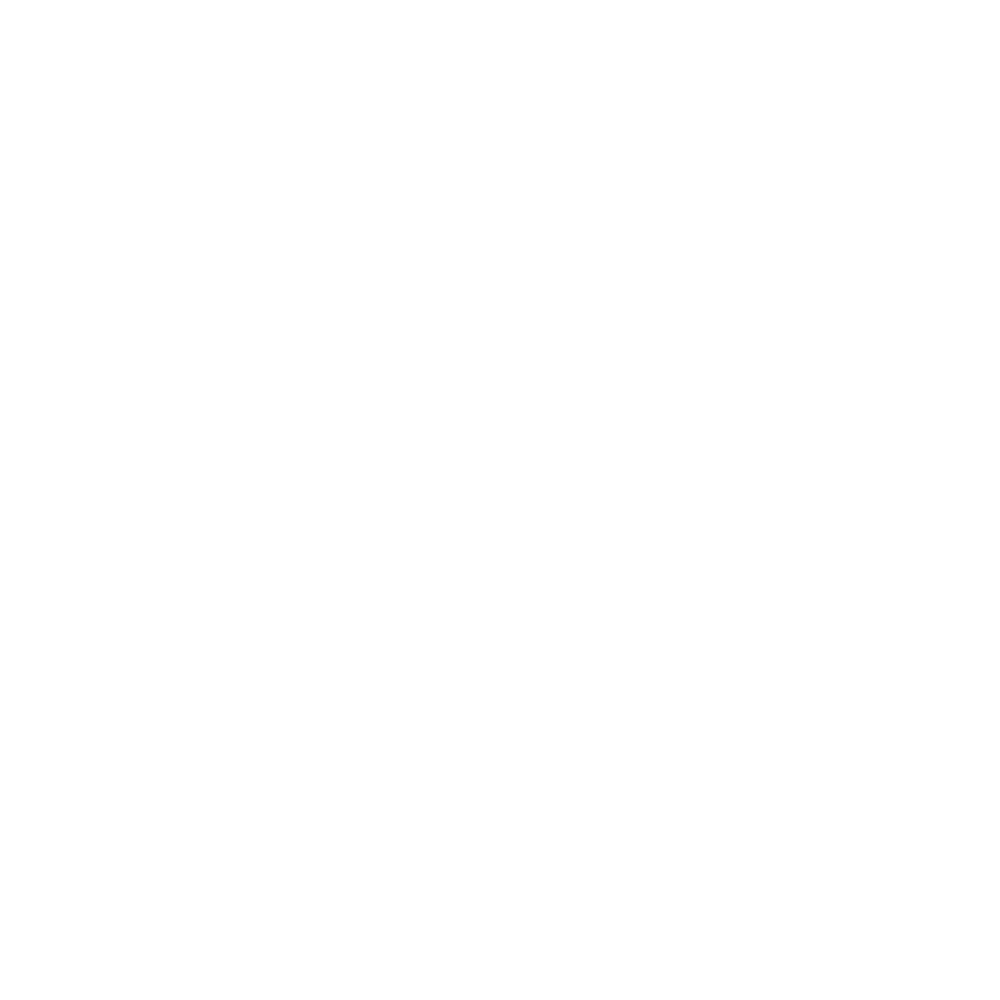

stop with loss 0.49917498230934143
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


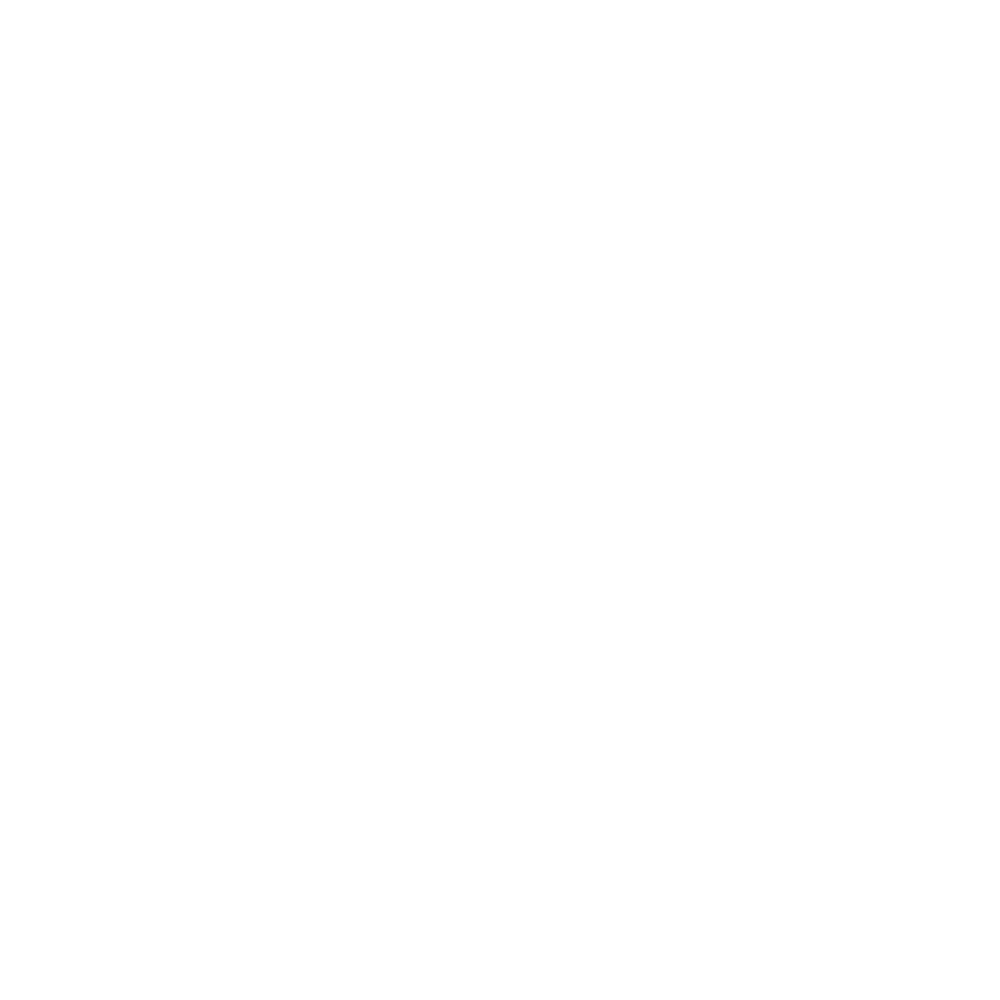

stop with loss 0.4989011287689209
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=70, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


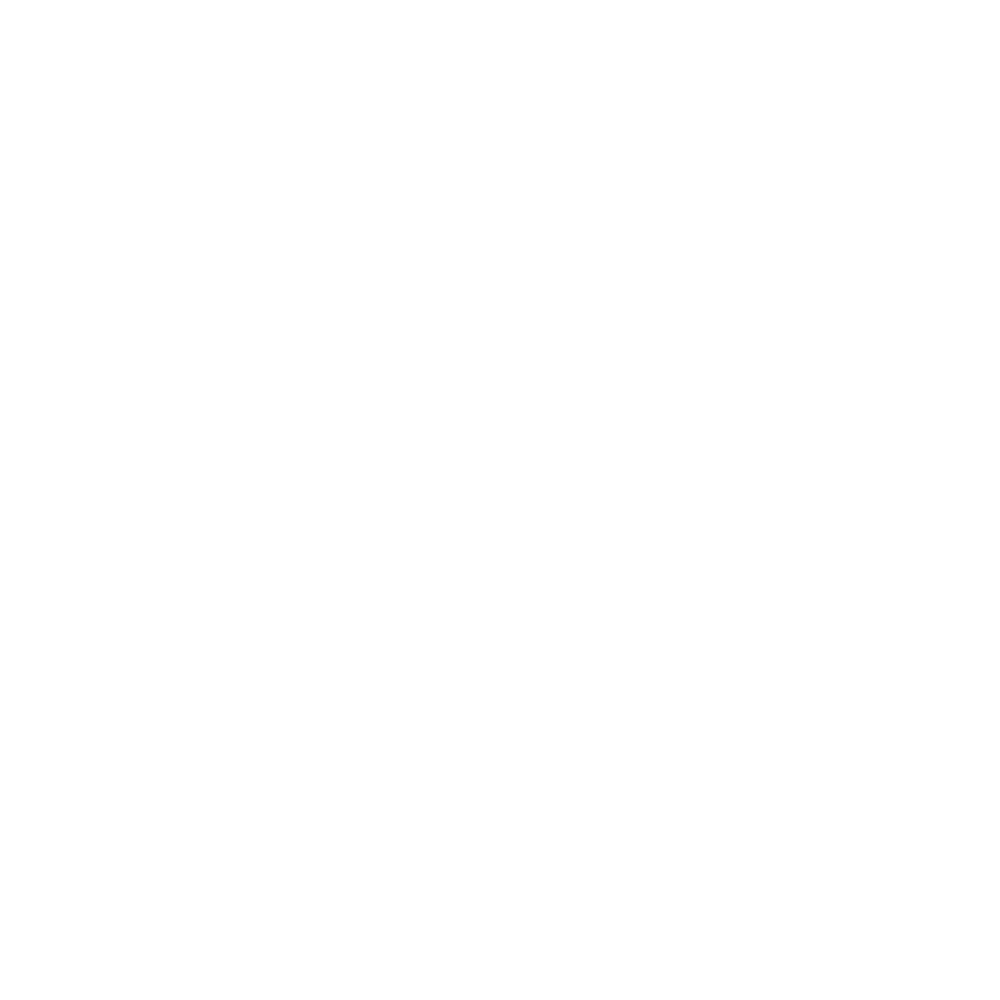

stop with loss 0.499367356300354
processing on: %s -------------------------- GMV&DTI
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


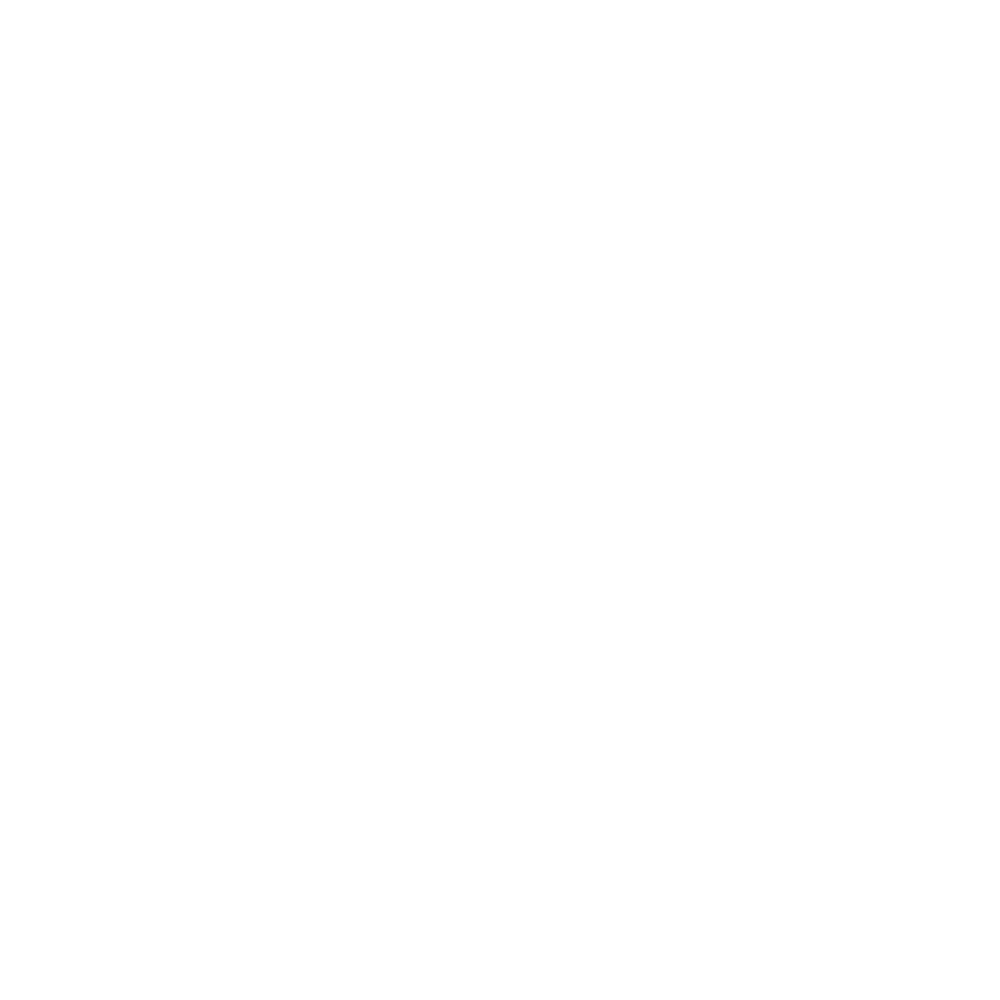

stop with loss 0.4998714029788971
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


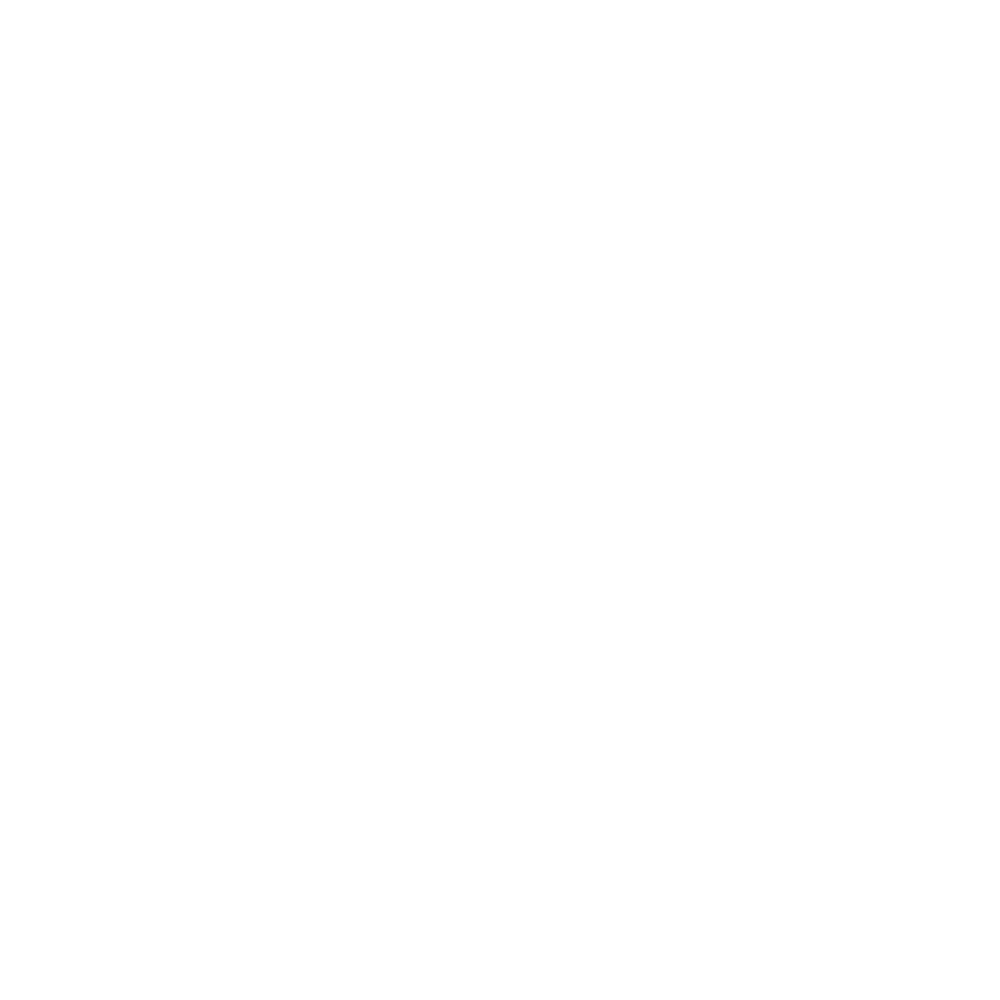

stop with loss 0.49597060680389404
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


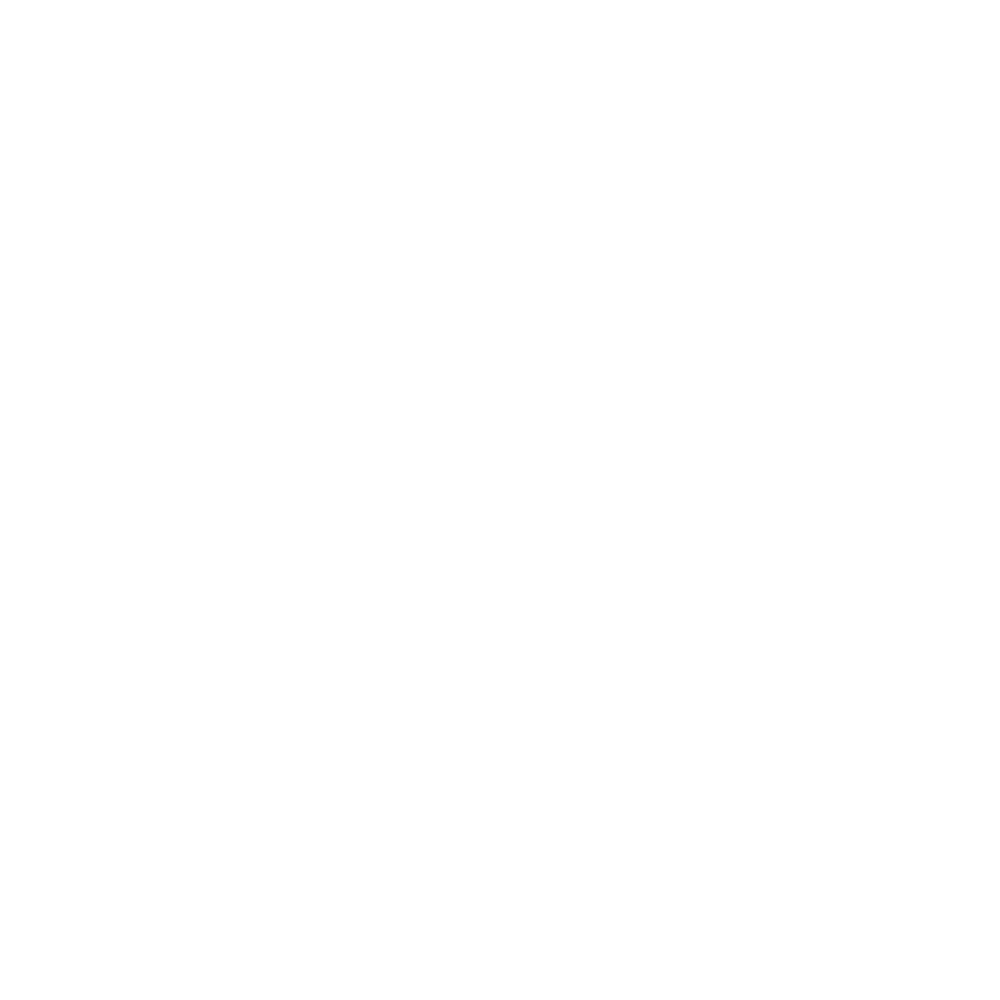

stop with loss 0.4978560209274292
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


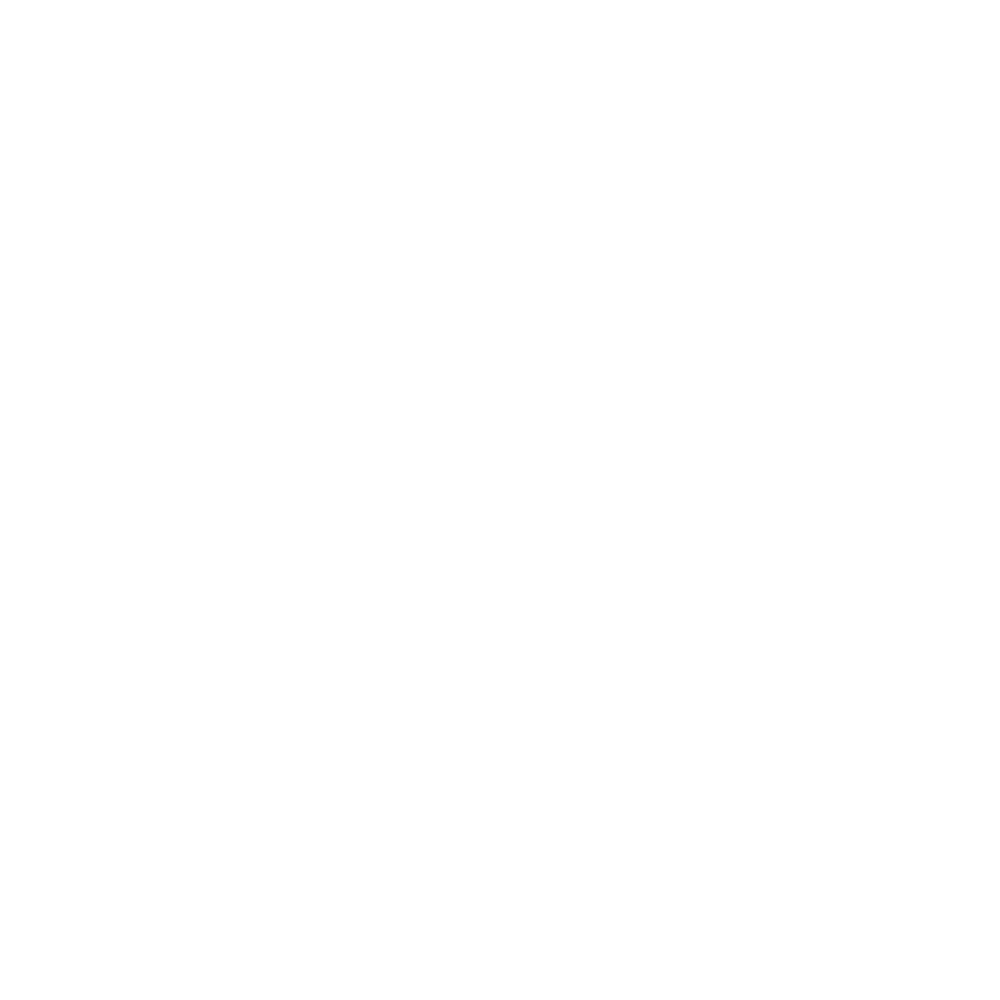

stop with loss 0.49841630458831787
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


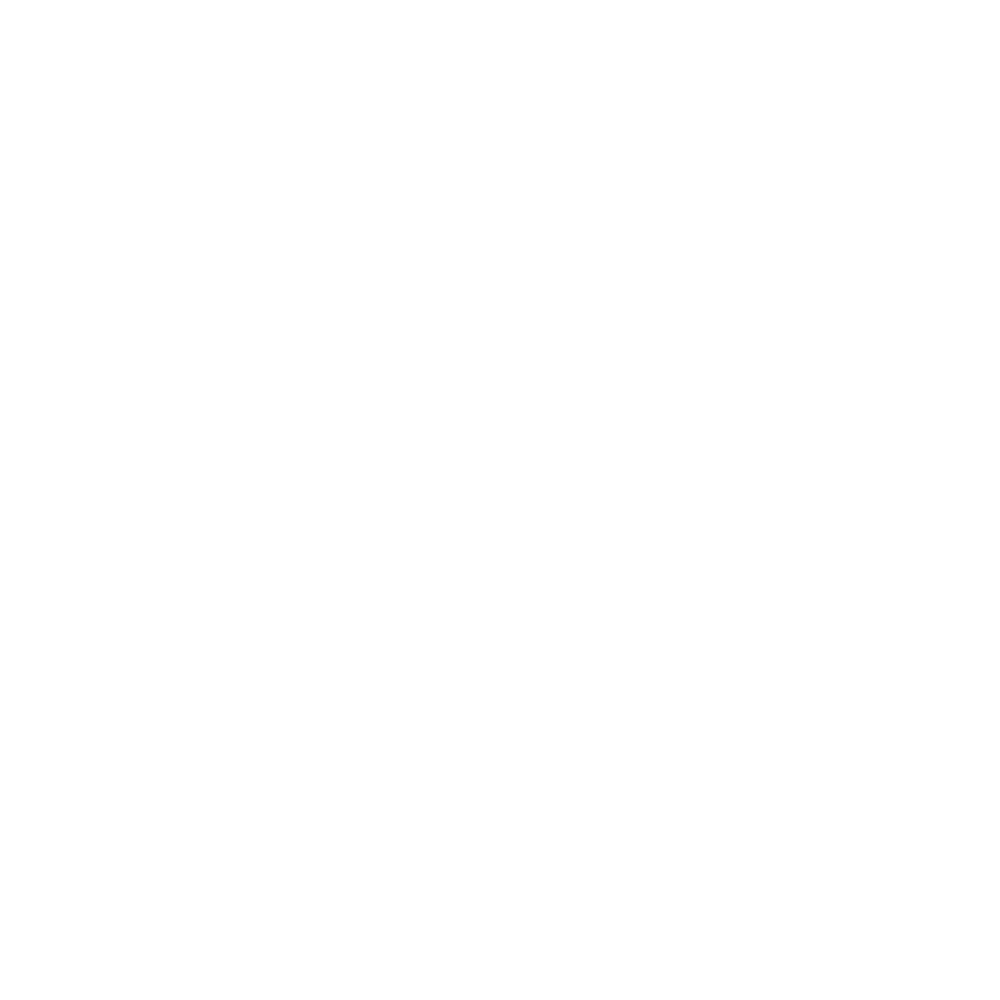

stop with loss 0.4984325170516968
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


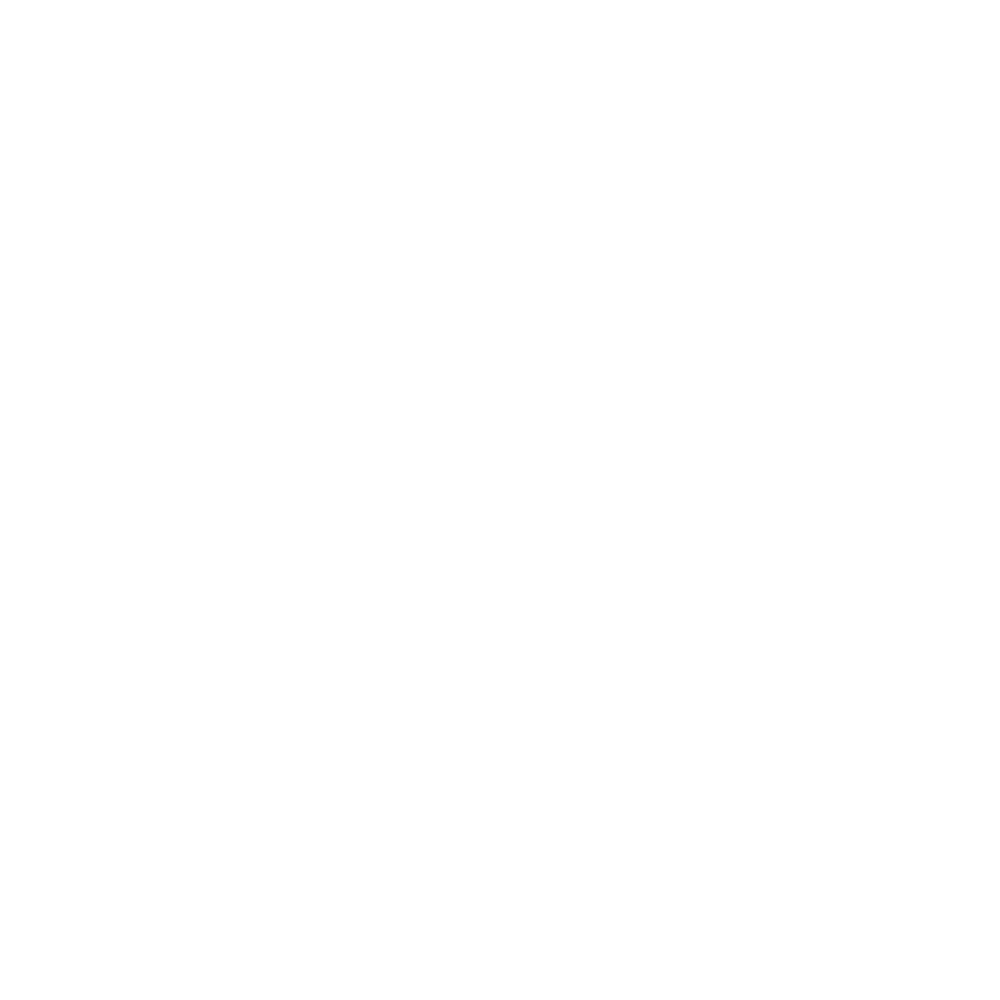

stop with loss 0.4980321526527405
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


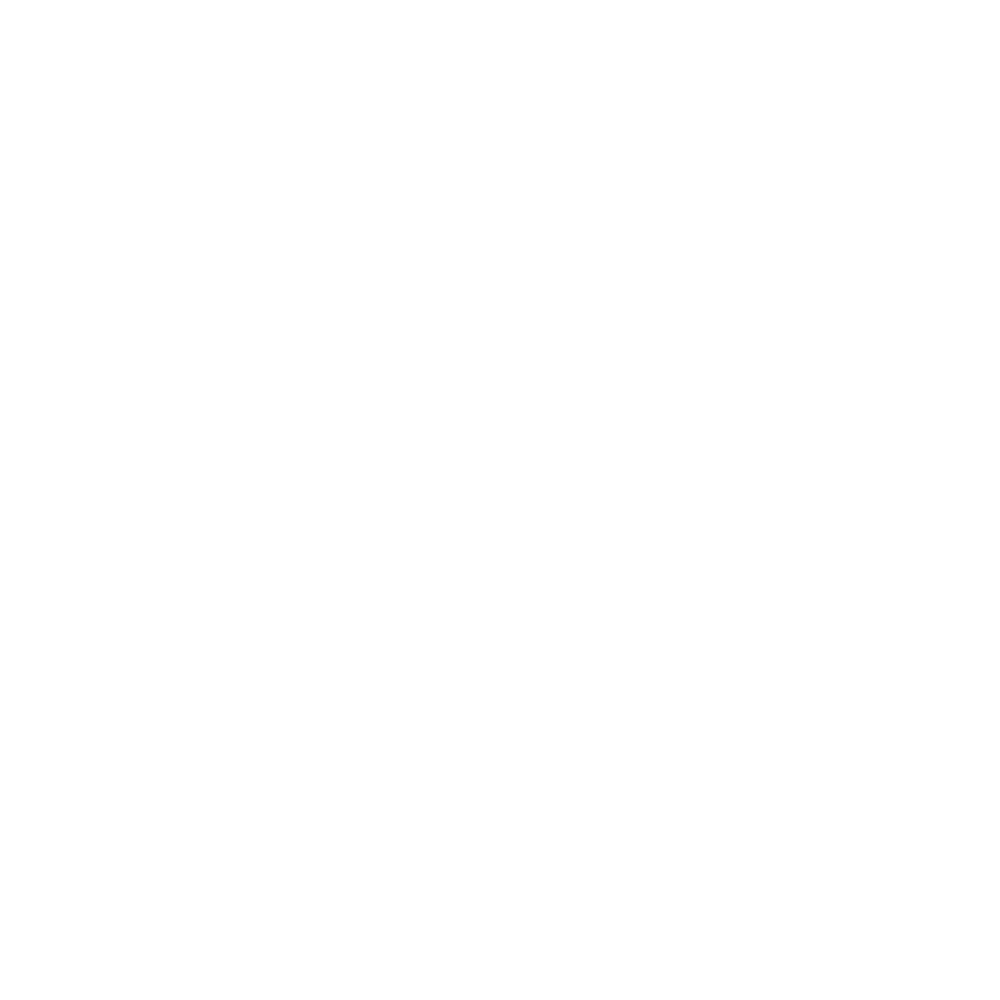

stop with loss 0.4982665181159973
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


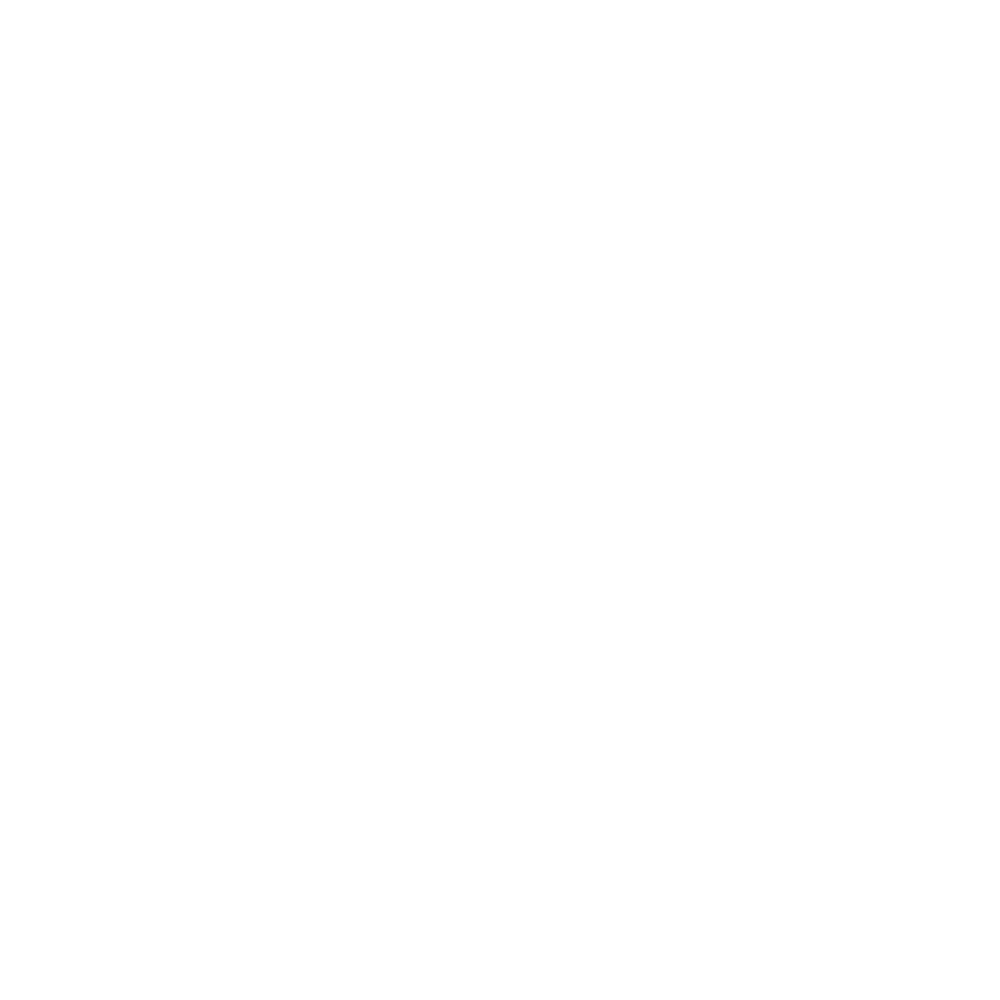

stop with loss 0.4963810443878174
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


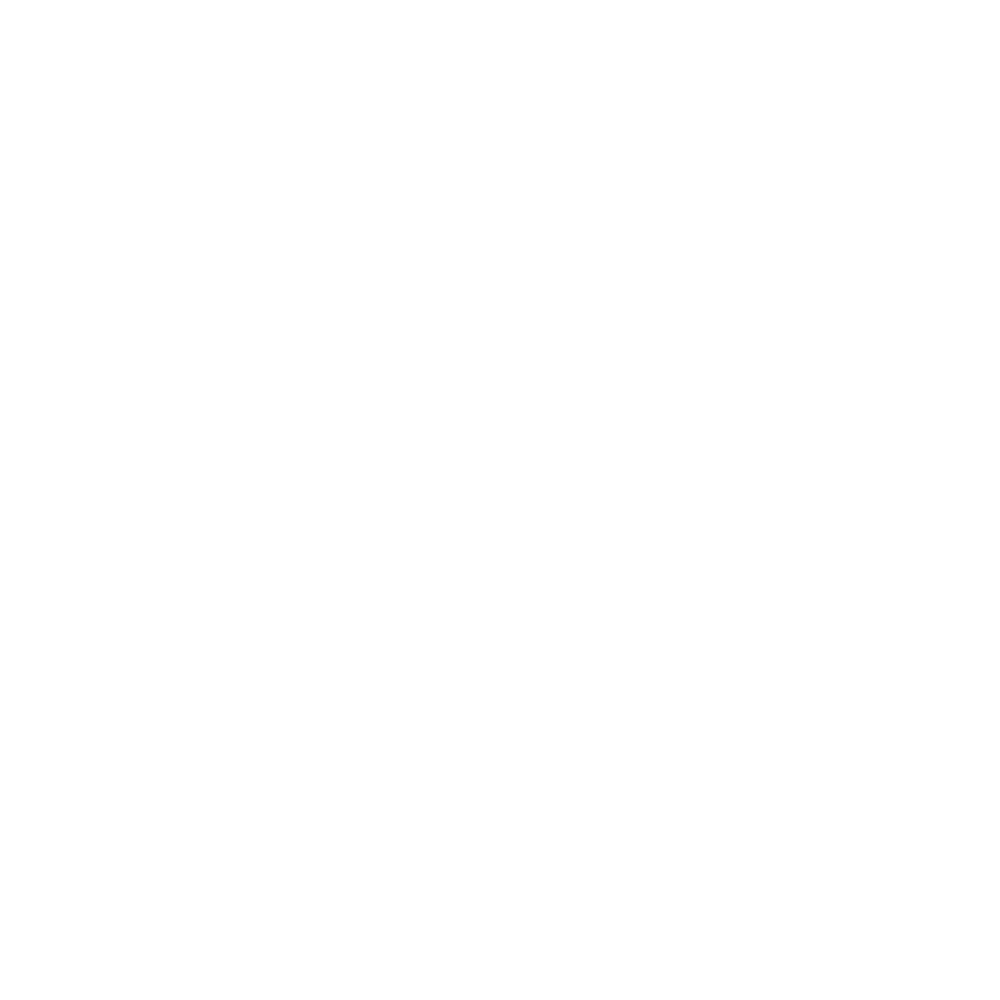

stop with loss 0.49960827827453613
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=280, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


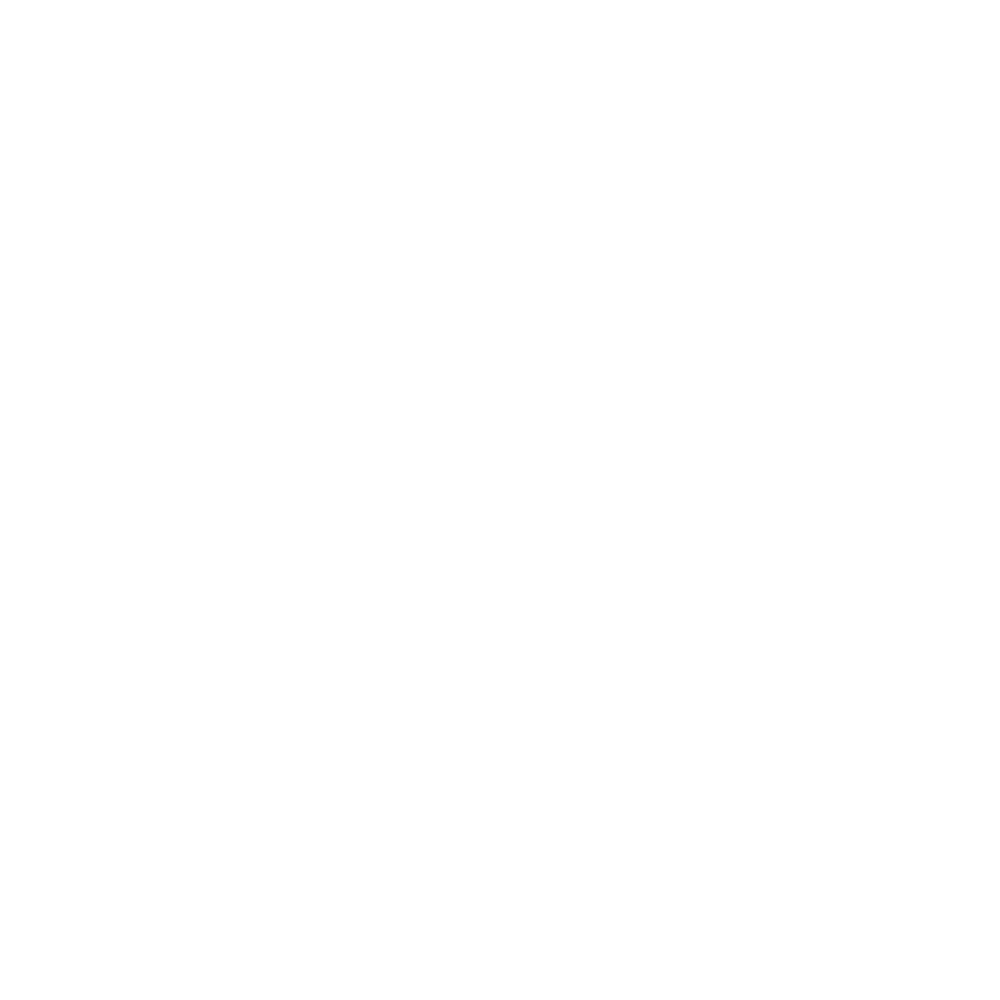

stop with loss 0.4966343343257904
processing on: %s -------------------------- GMV&rsfMRI
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


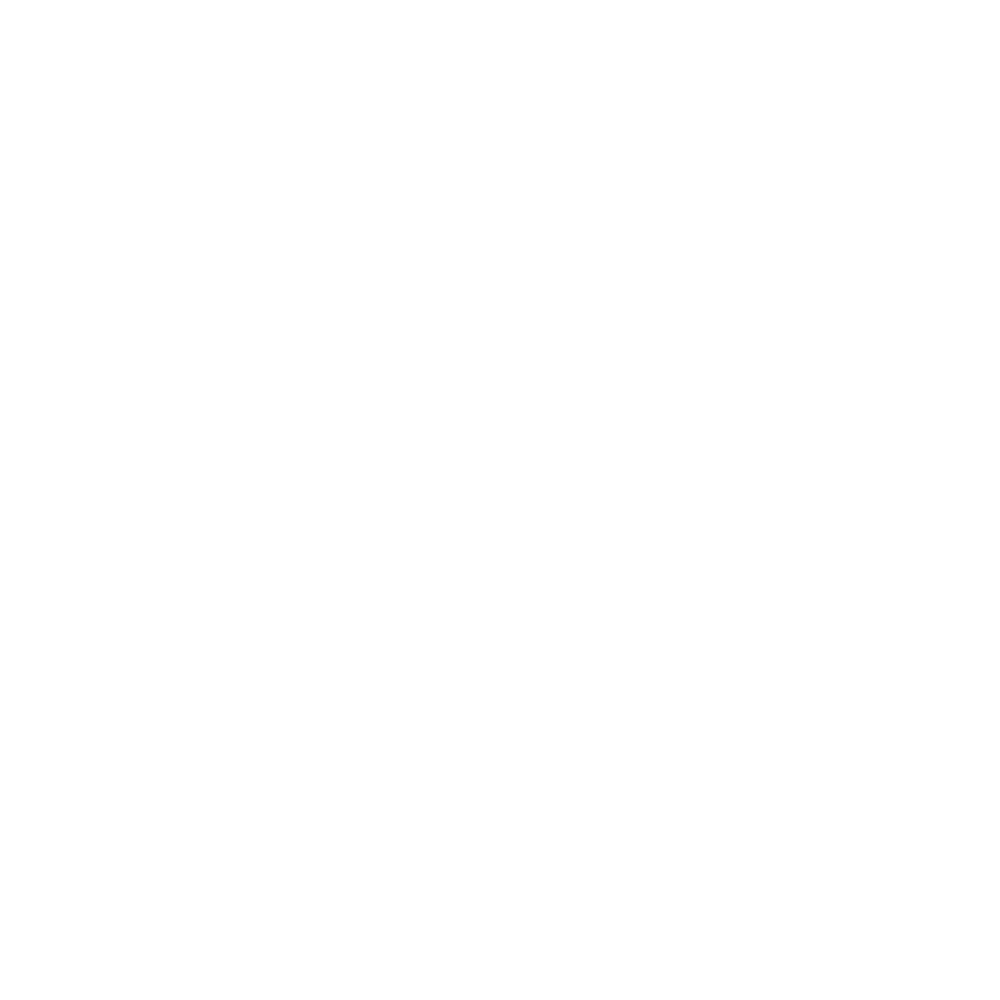

stop with loss 0.49368688464164734
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


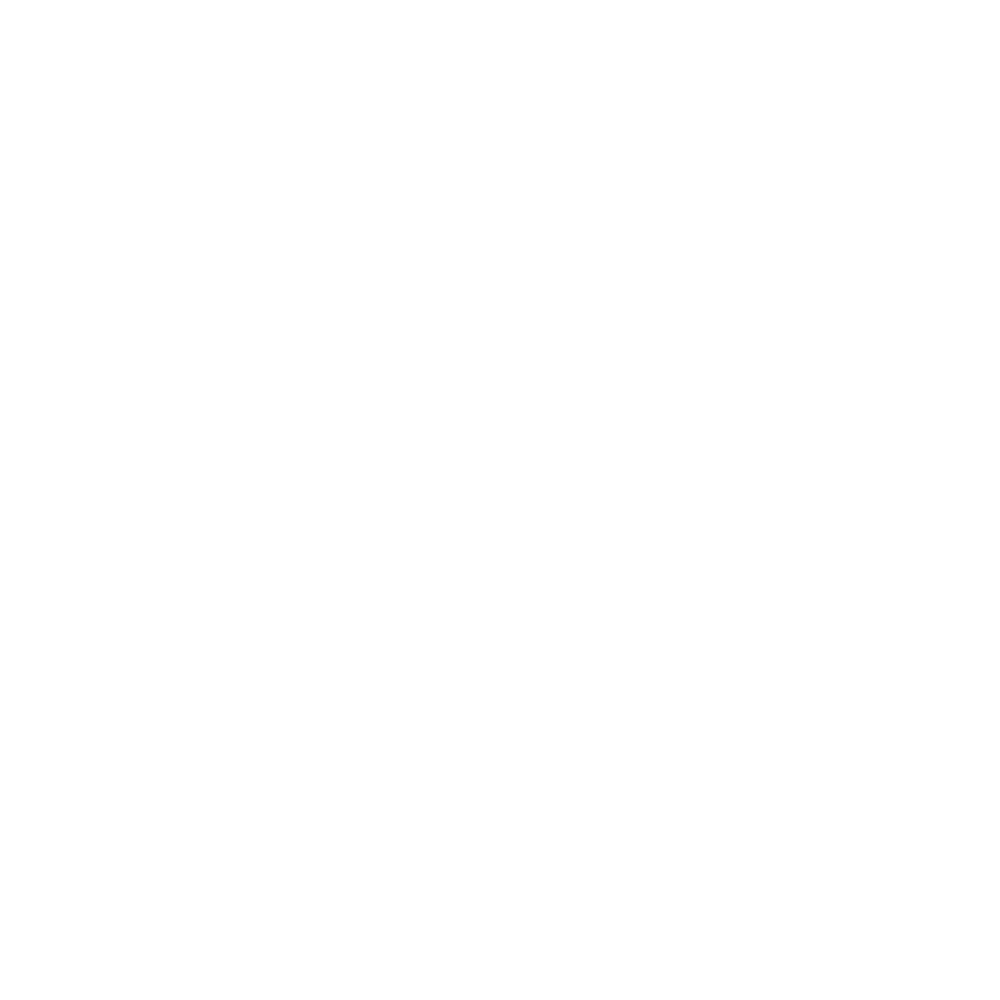

stop with loss 0.4985247552394867
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


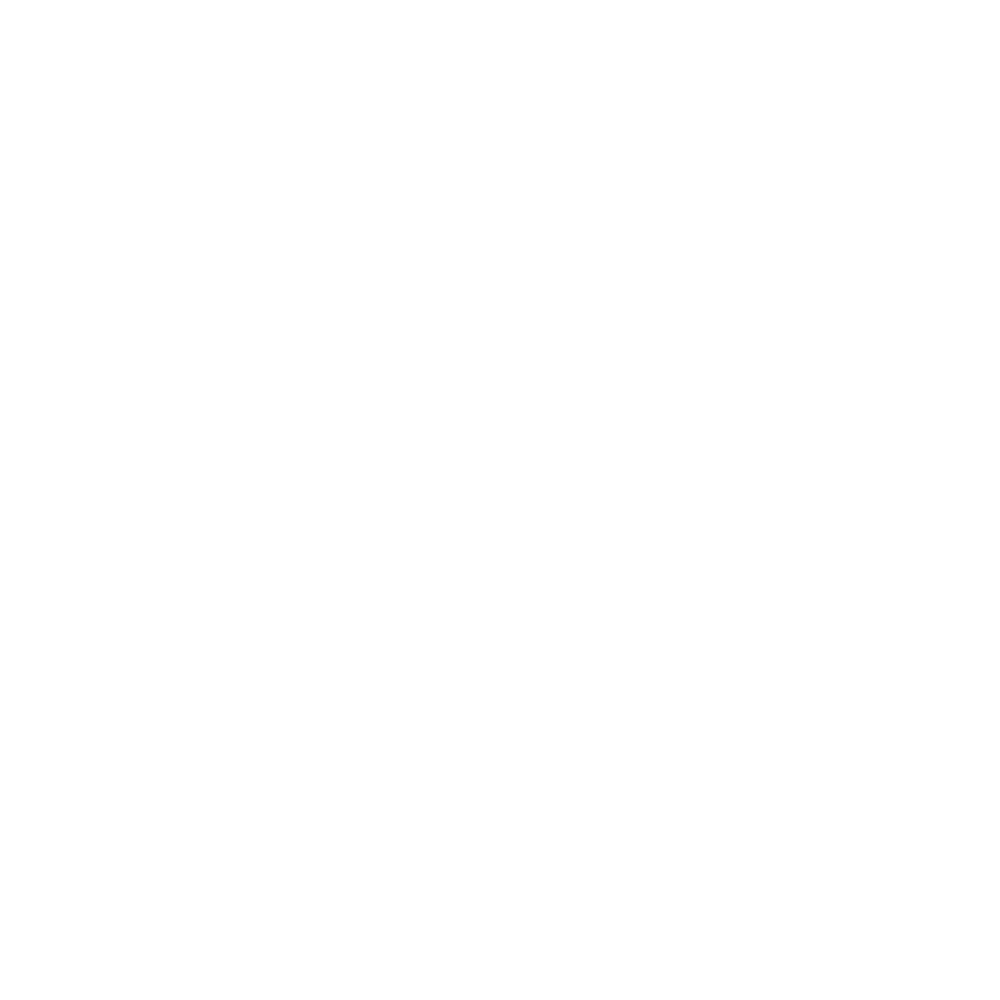

stop with loss 0.49405694007873535
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


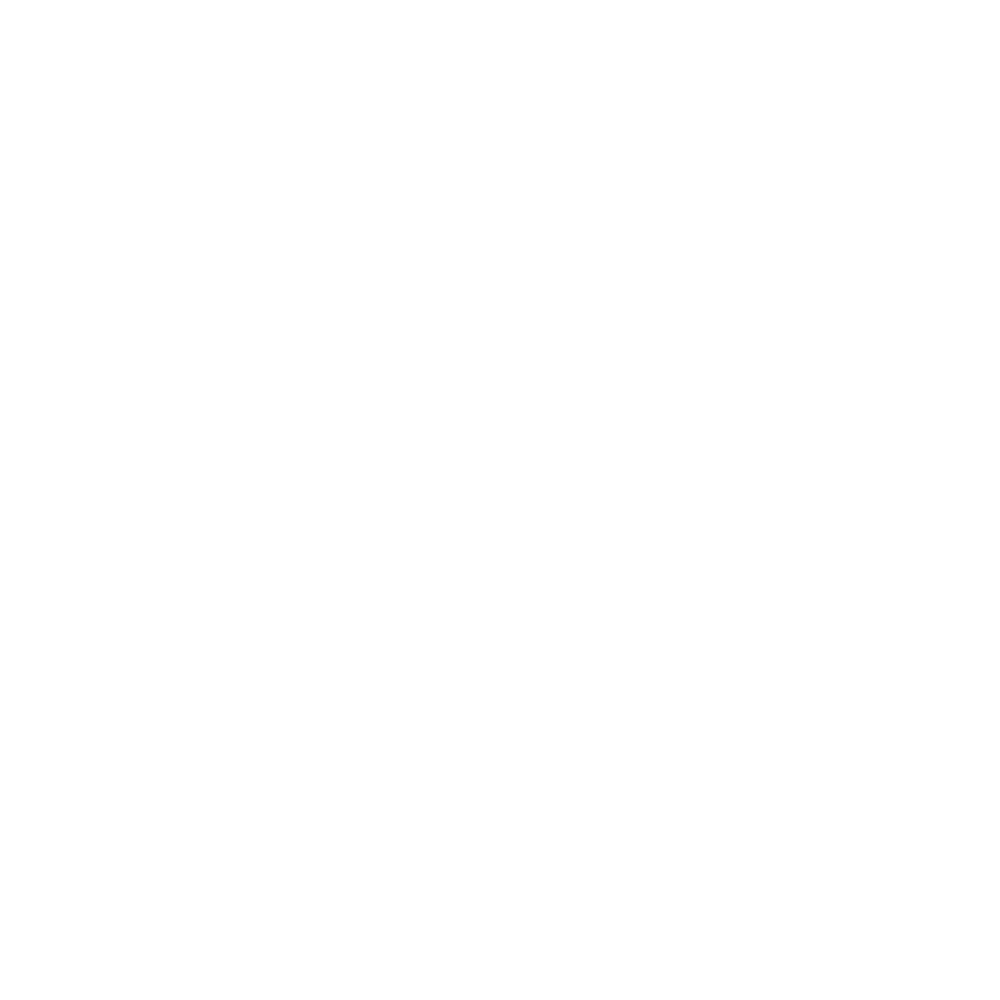

stop with loss 0.49774715304374695
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


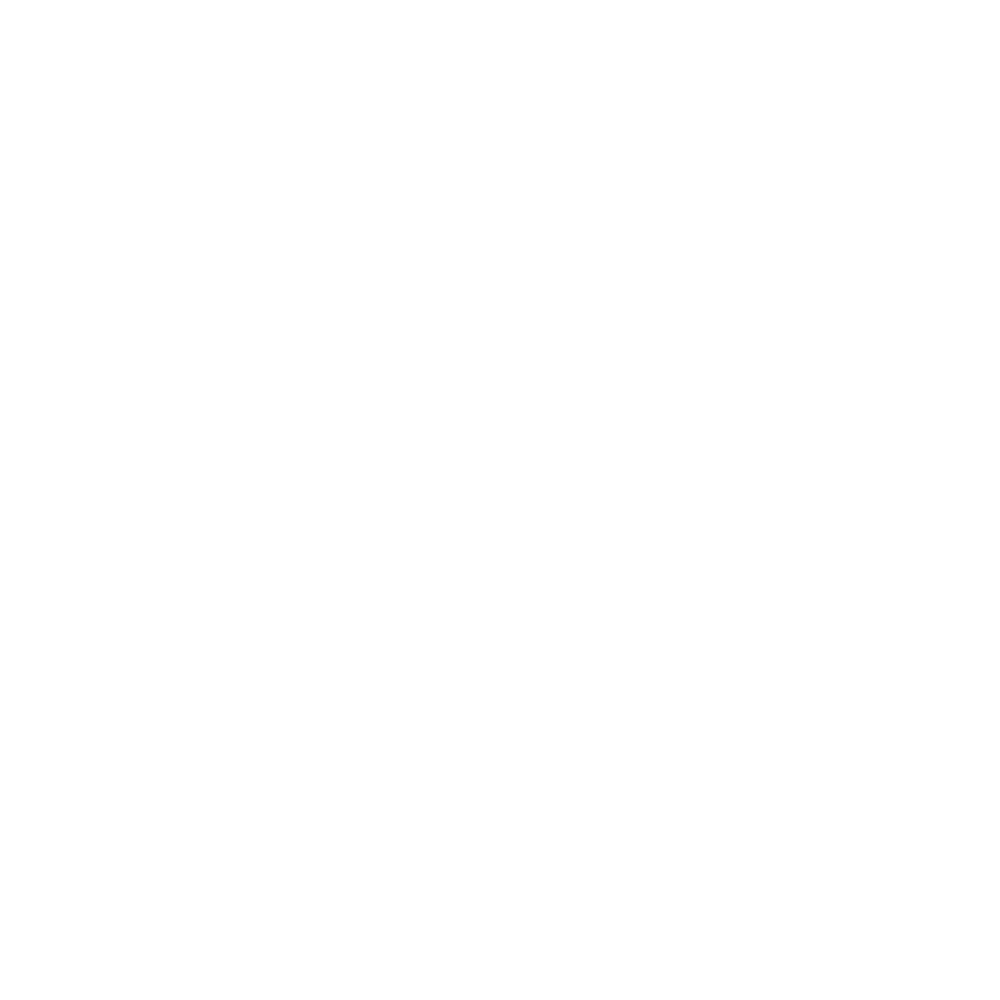

stop with loss 0.4992711842060089
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


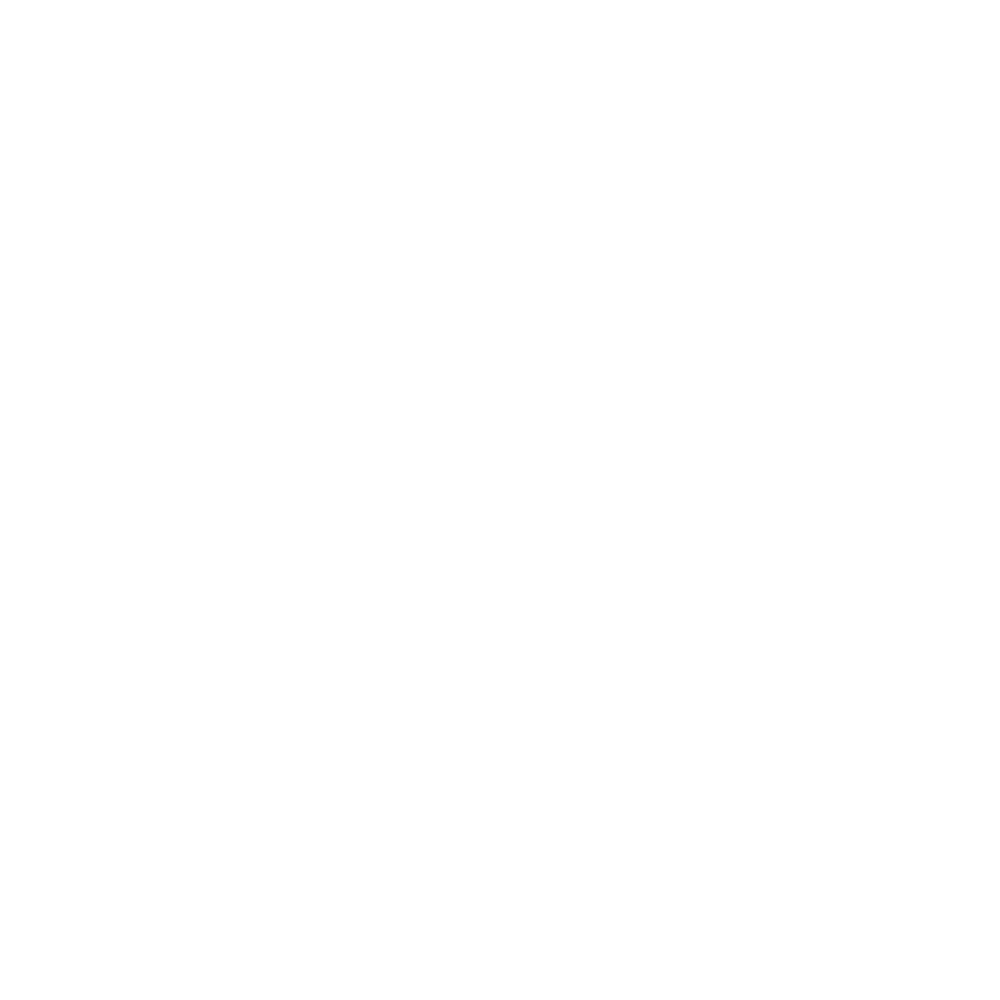

stop with loss 0.4998849034309387
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


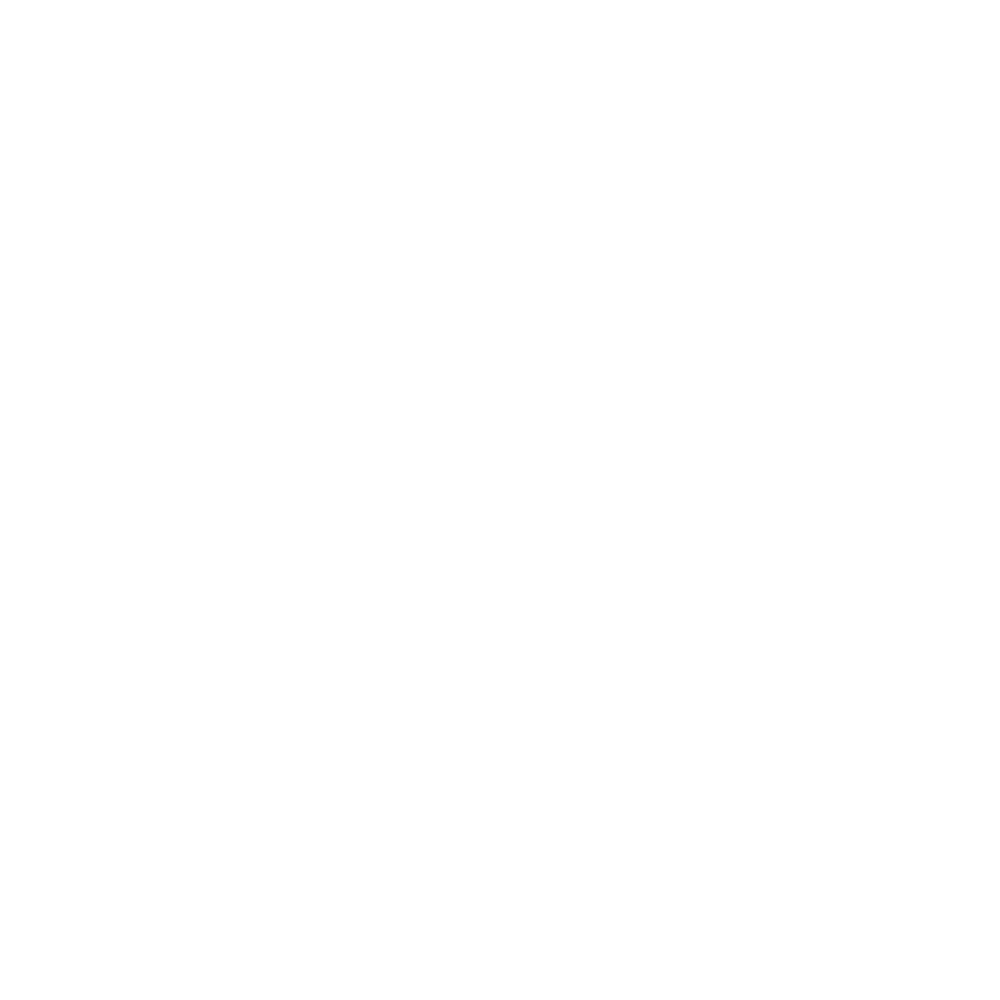

stop with loss 0.4963362216949463
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


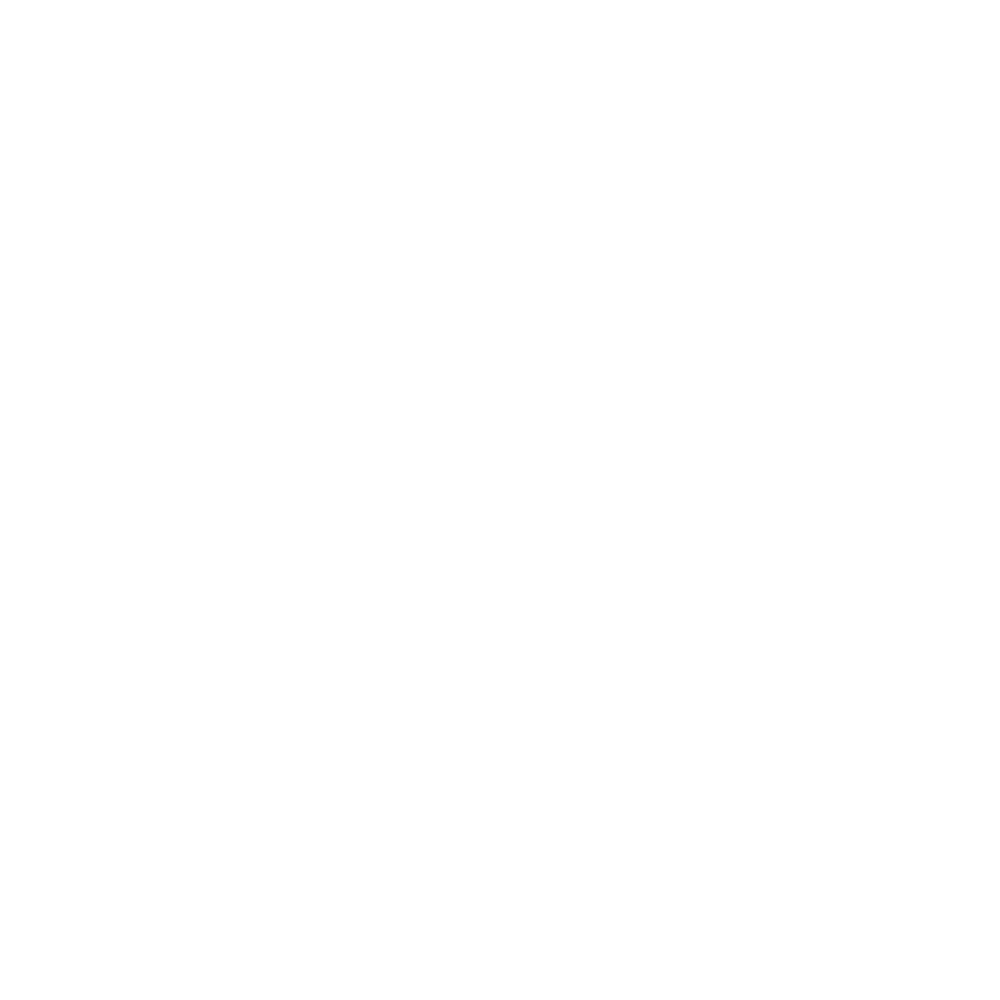

stop with loss 0.49760299921035767
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


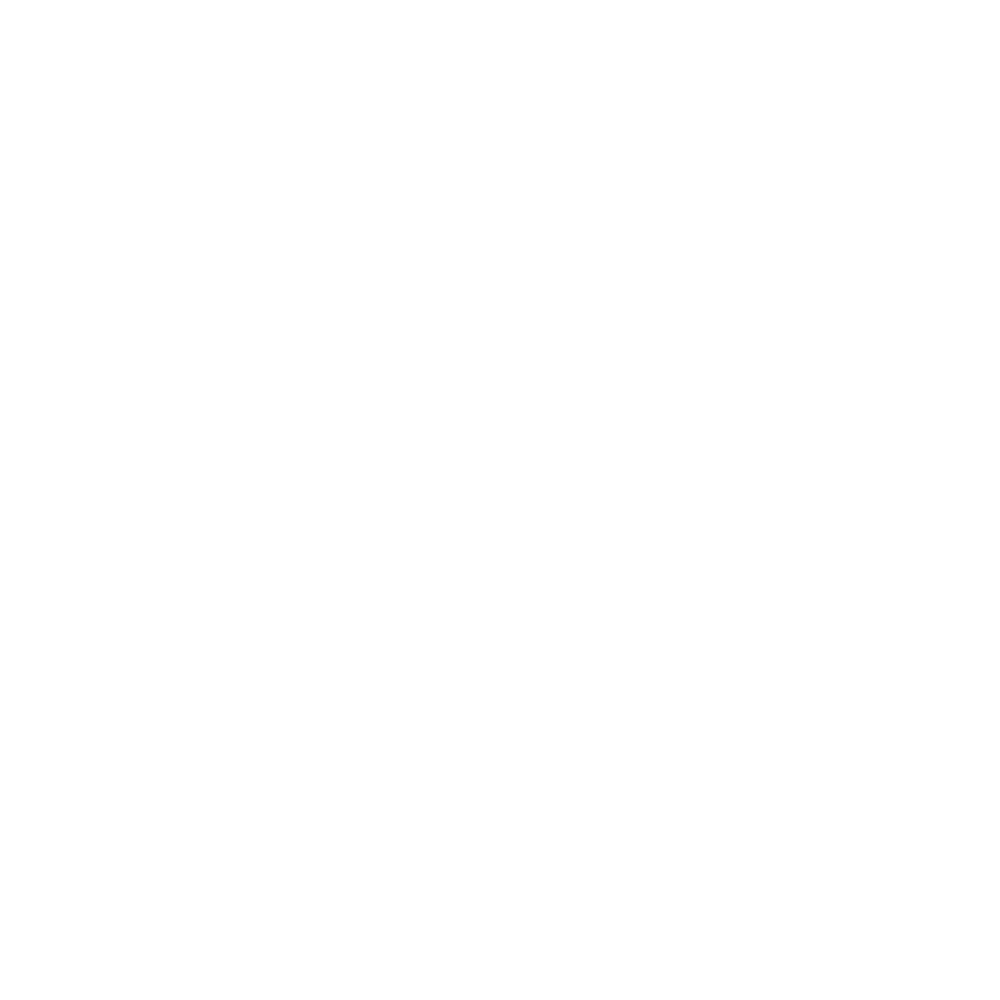

stop with loss 0.49977952241897583
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


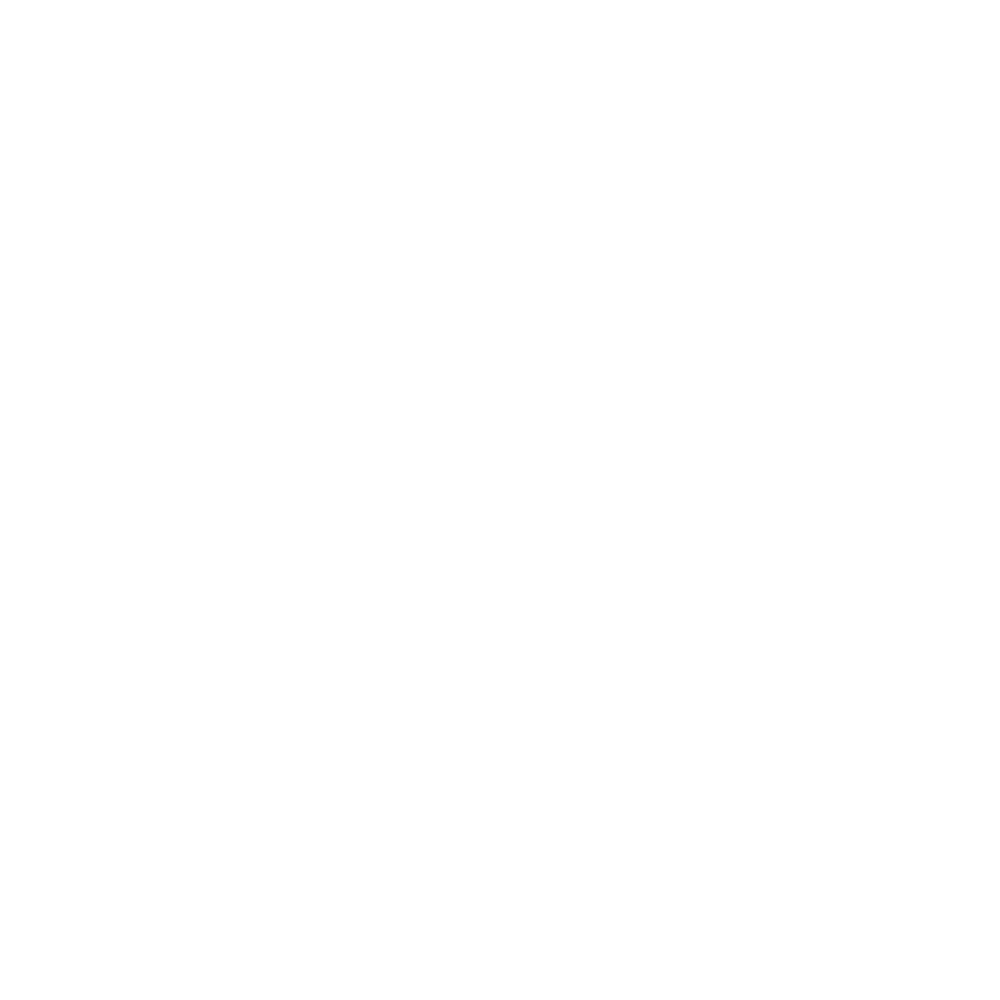

stop with loss 0.4945945143699646
processing on: %s -------------------------- DTI&rsfMRI
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


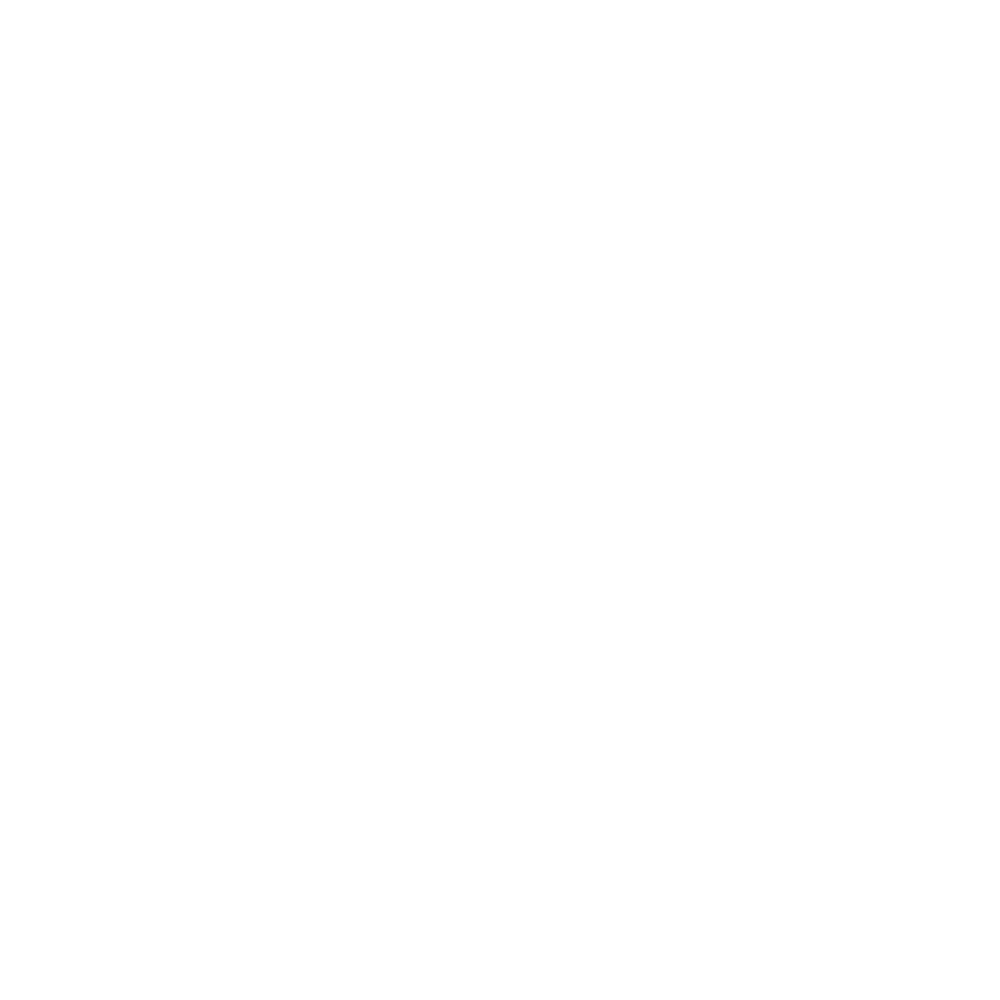

stop with loss 0.4964938461780548
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


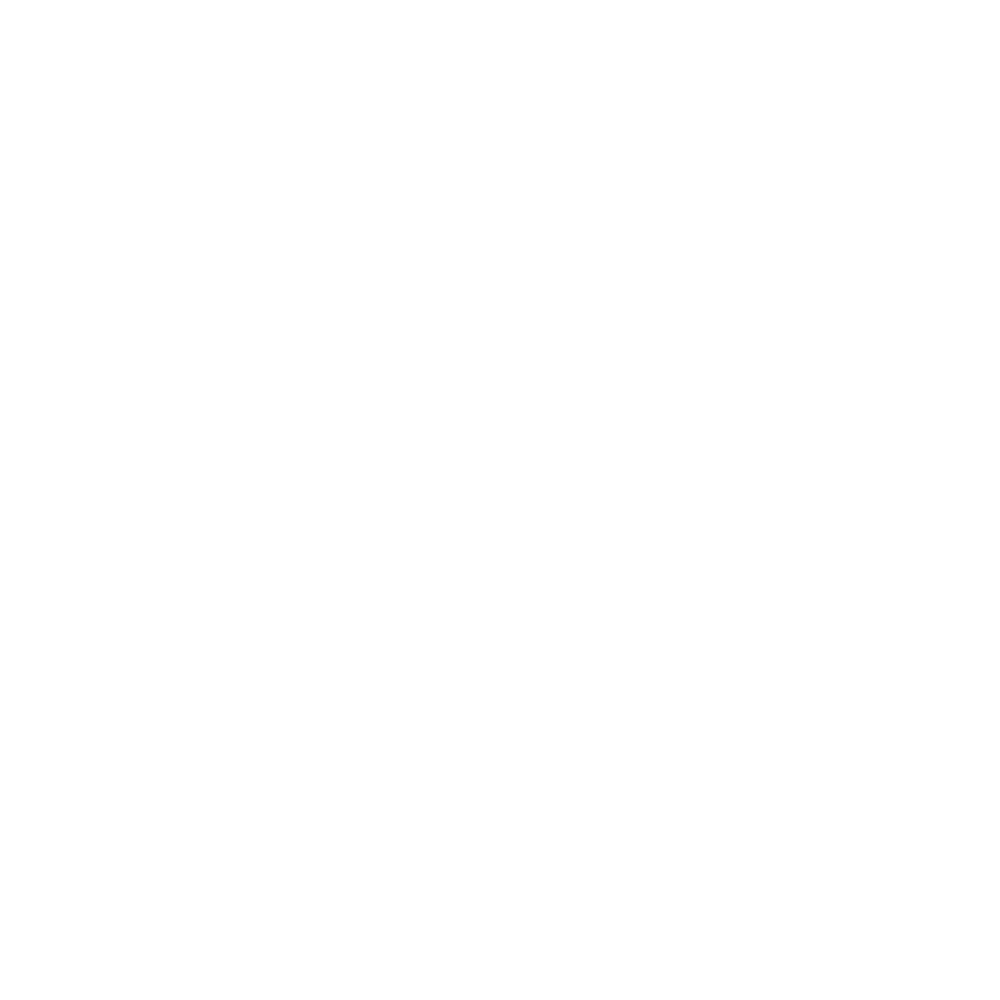

stop with loss 0.4982004463672638
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


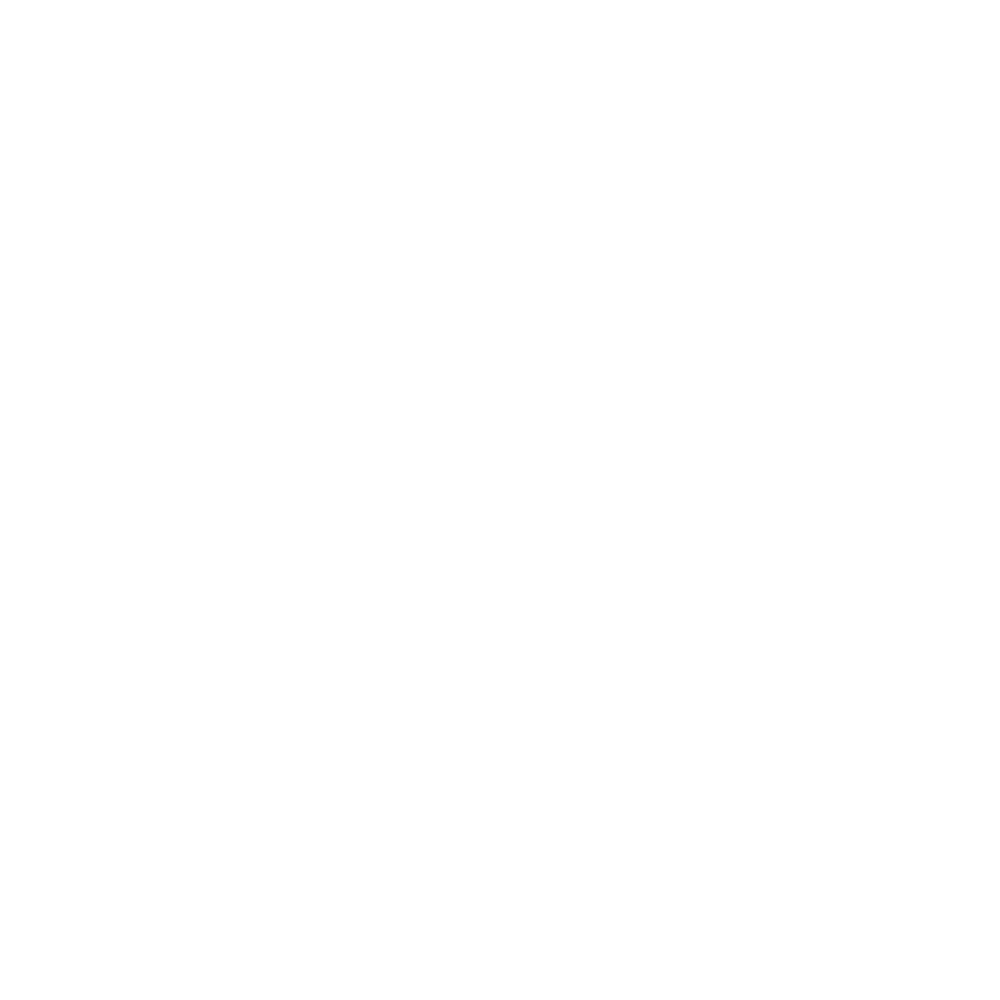

stop with loss 0.49462154507637024
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


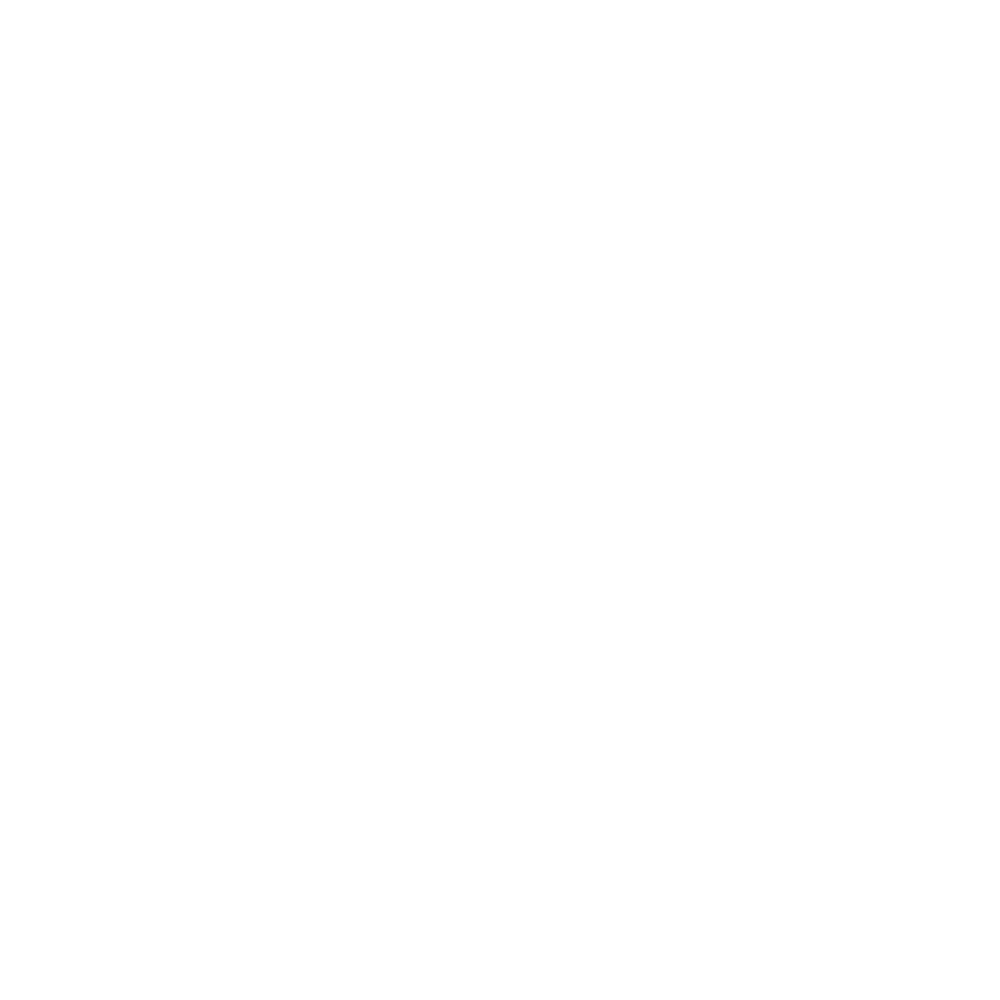

stop with loss 0.49520236253738403
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


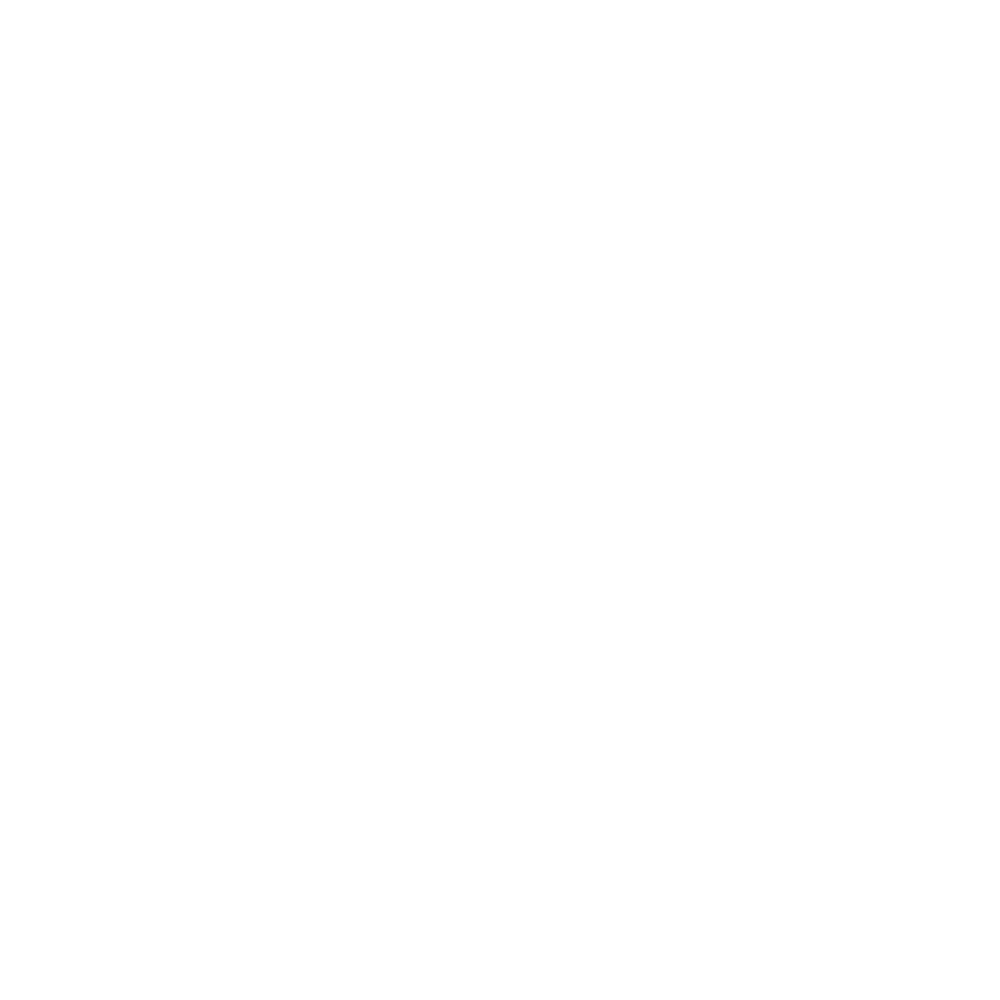

stop with loss 0.4981328248977661
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


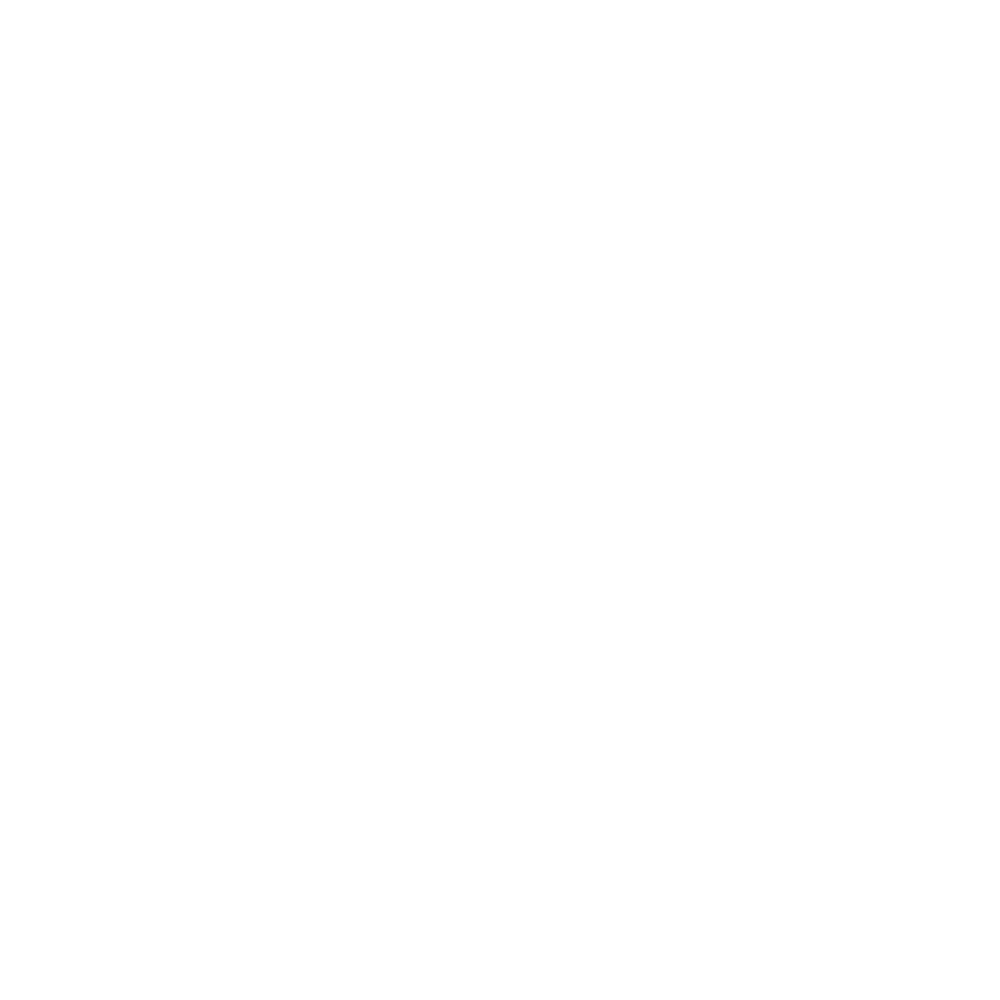

stop with loss 0.4994887411594391
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


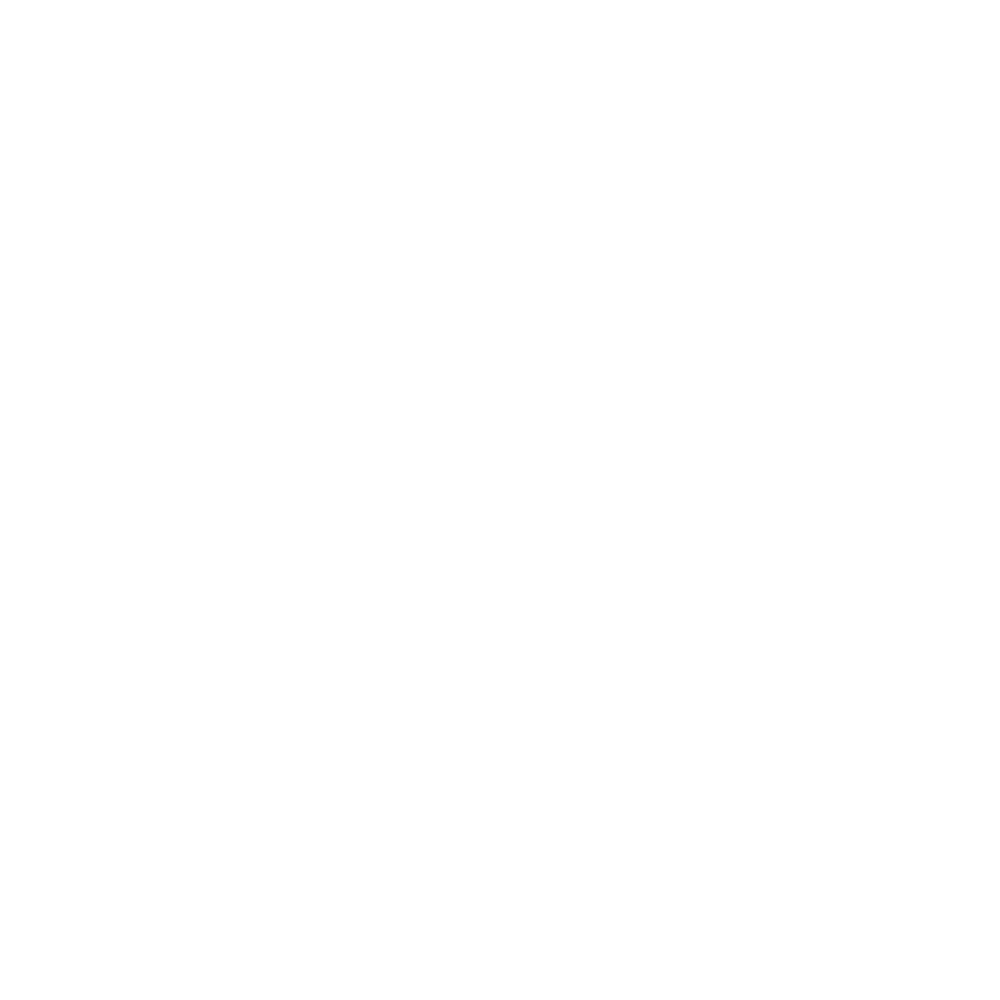

stop with loss 0.4972967803478241
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


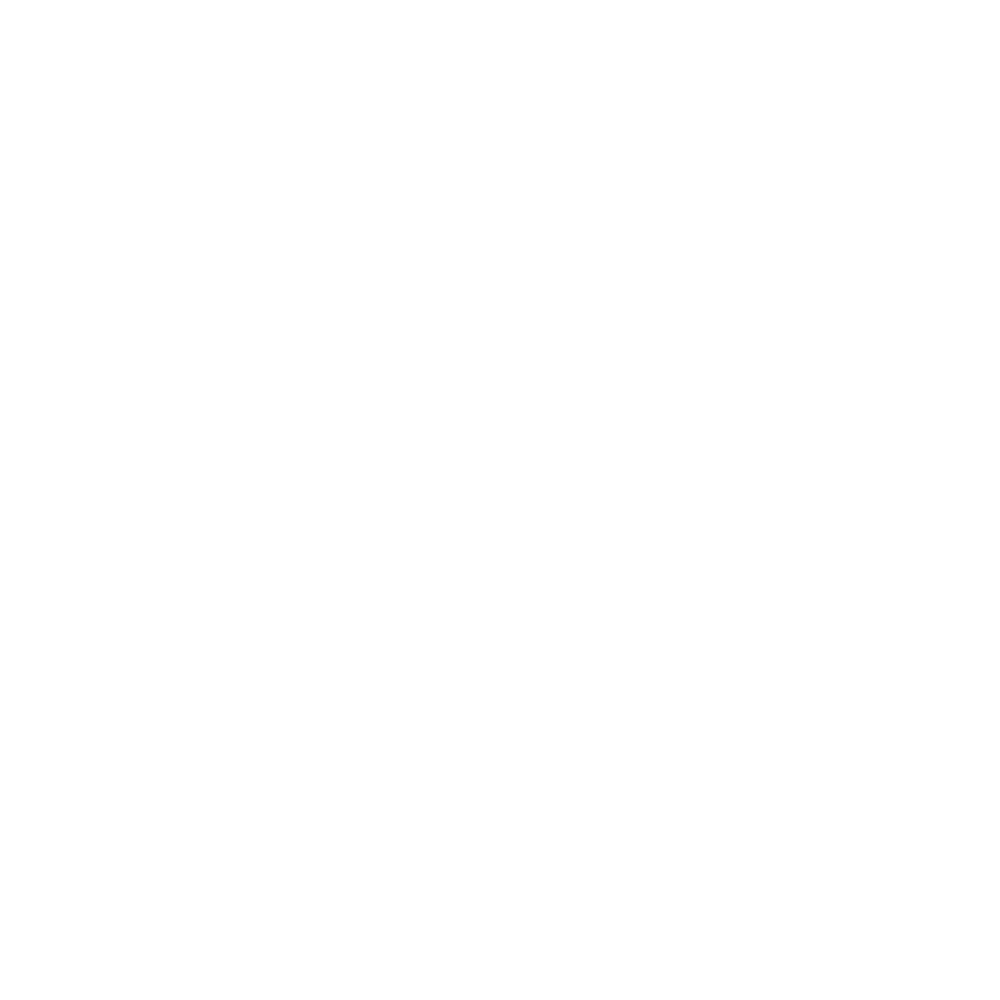

stop with loss 0.49581965804100037
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


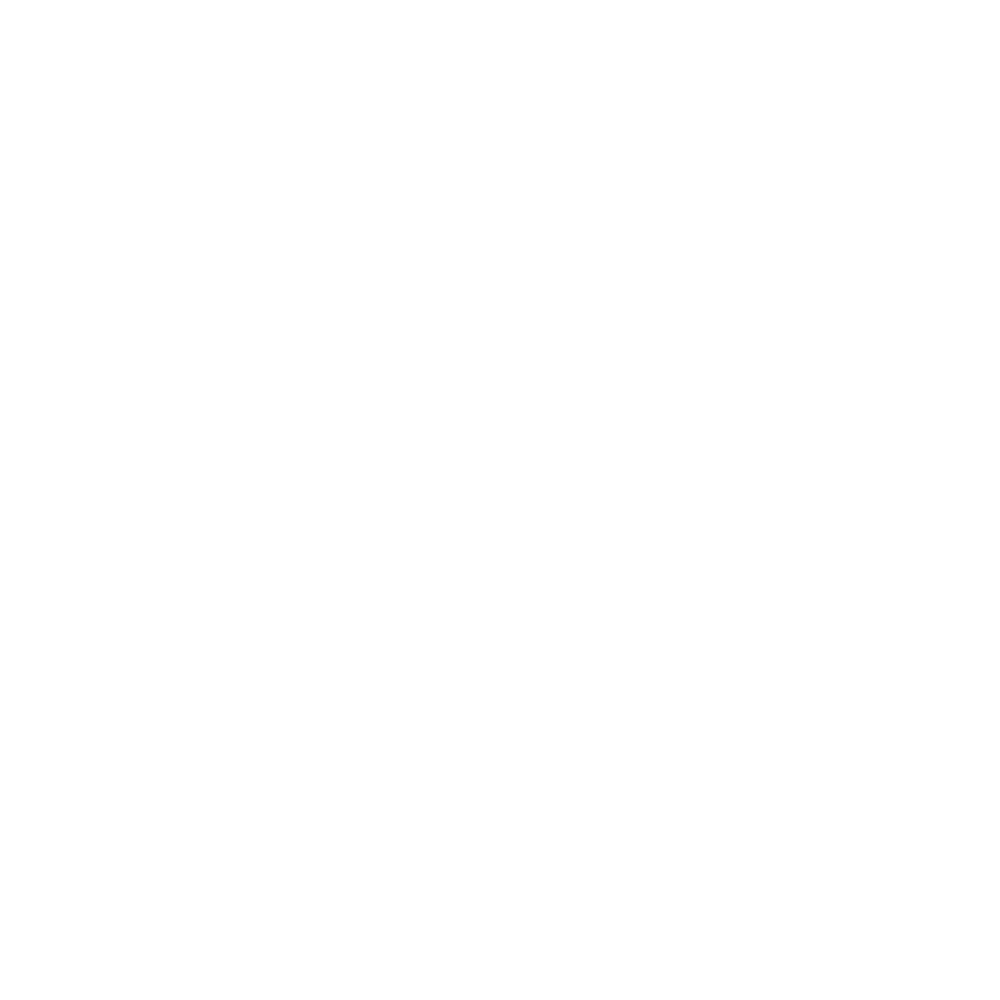

stop with loss 0.49275487661361694
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=632, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


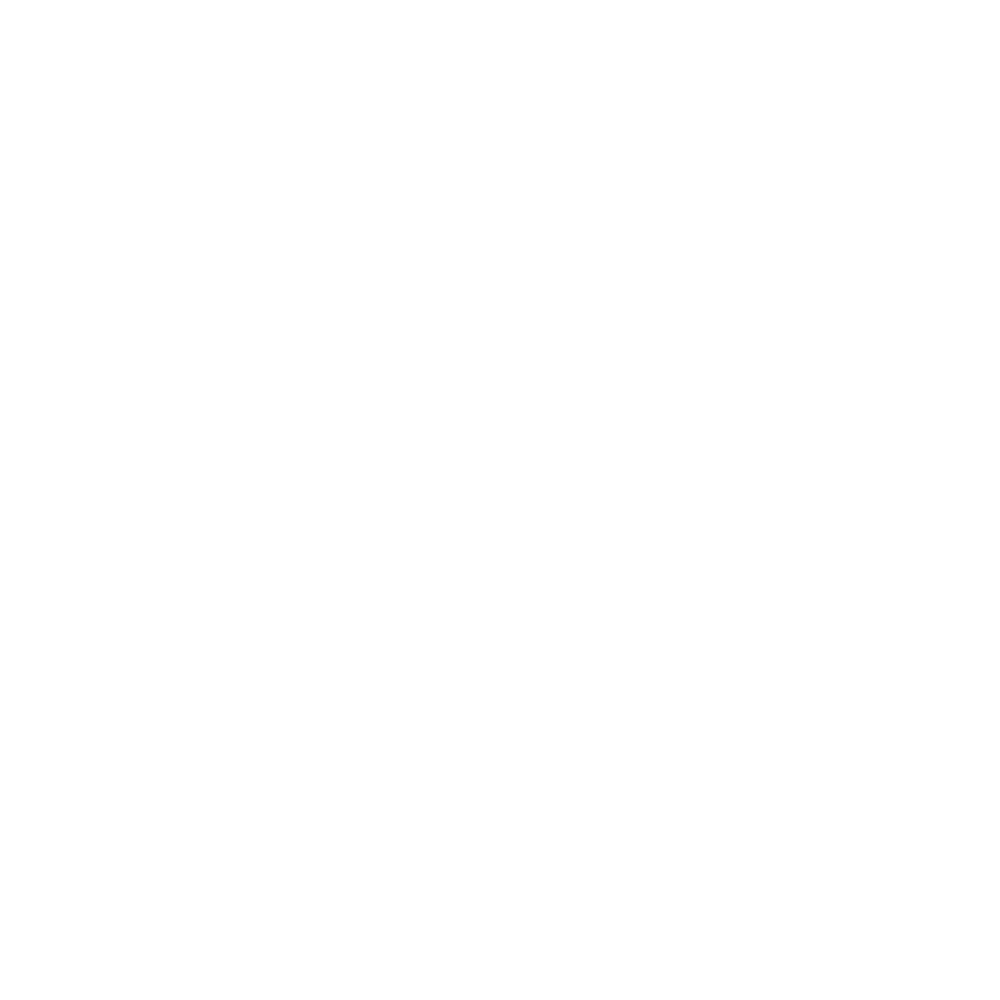

stop with loss 0.49970802664756775
processing on: %s -------------------------- Multi-modal
run_model on CV: 1
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


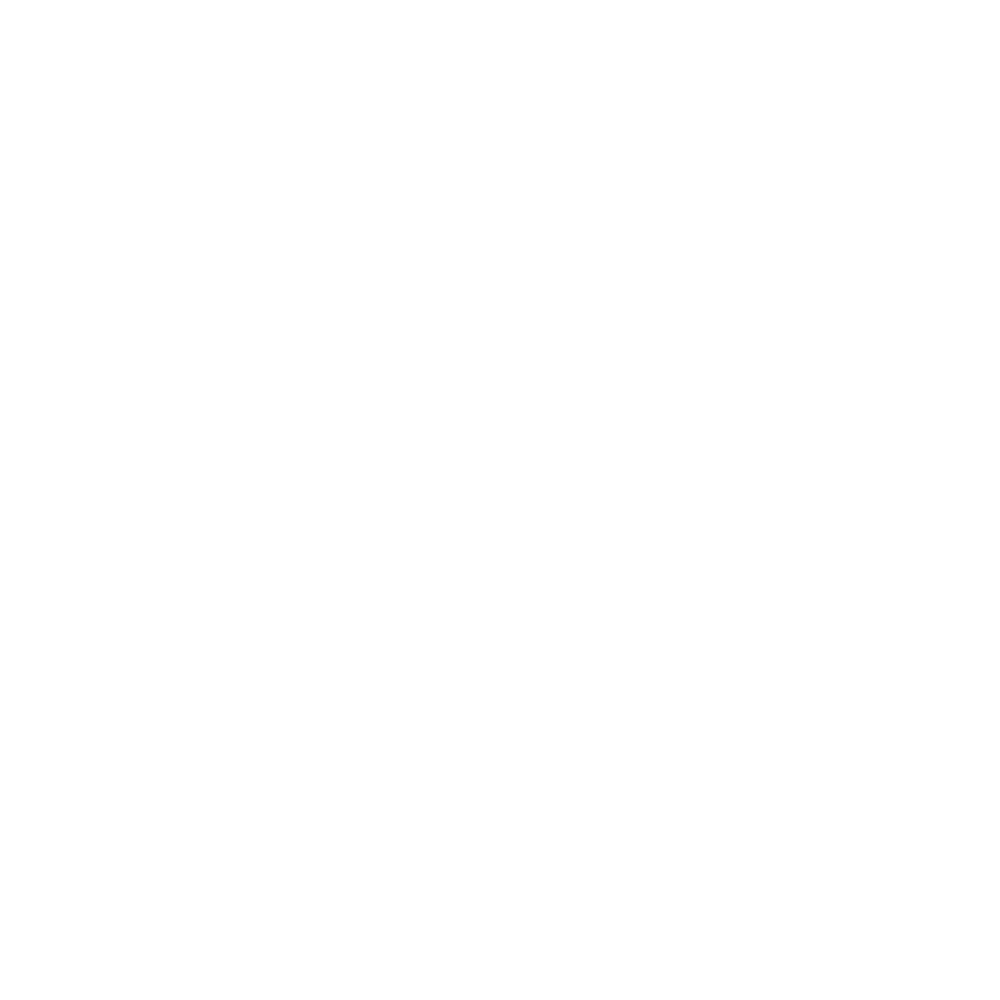

stop with loss 0.4928852617740631
run_model on CV: 2
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


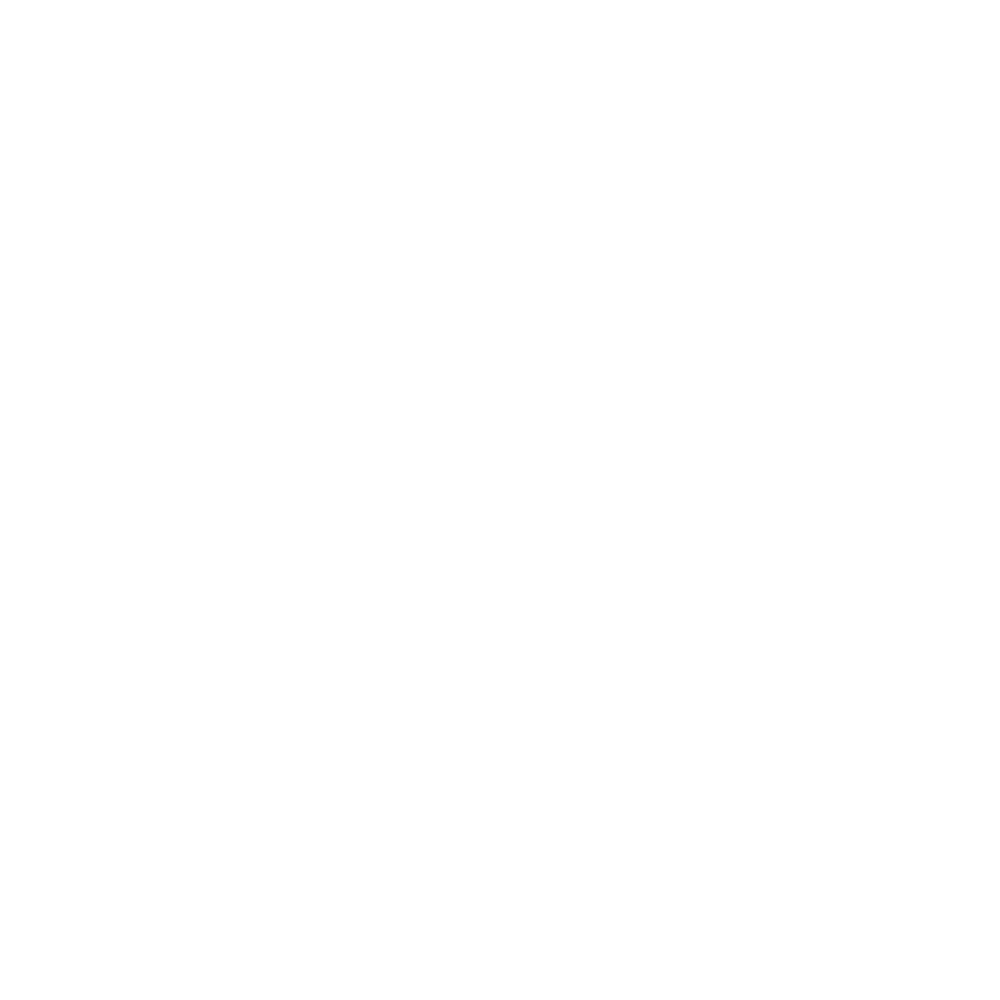

stop with loss 0.49874740839004517
run_model on CV: 3
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


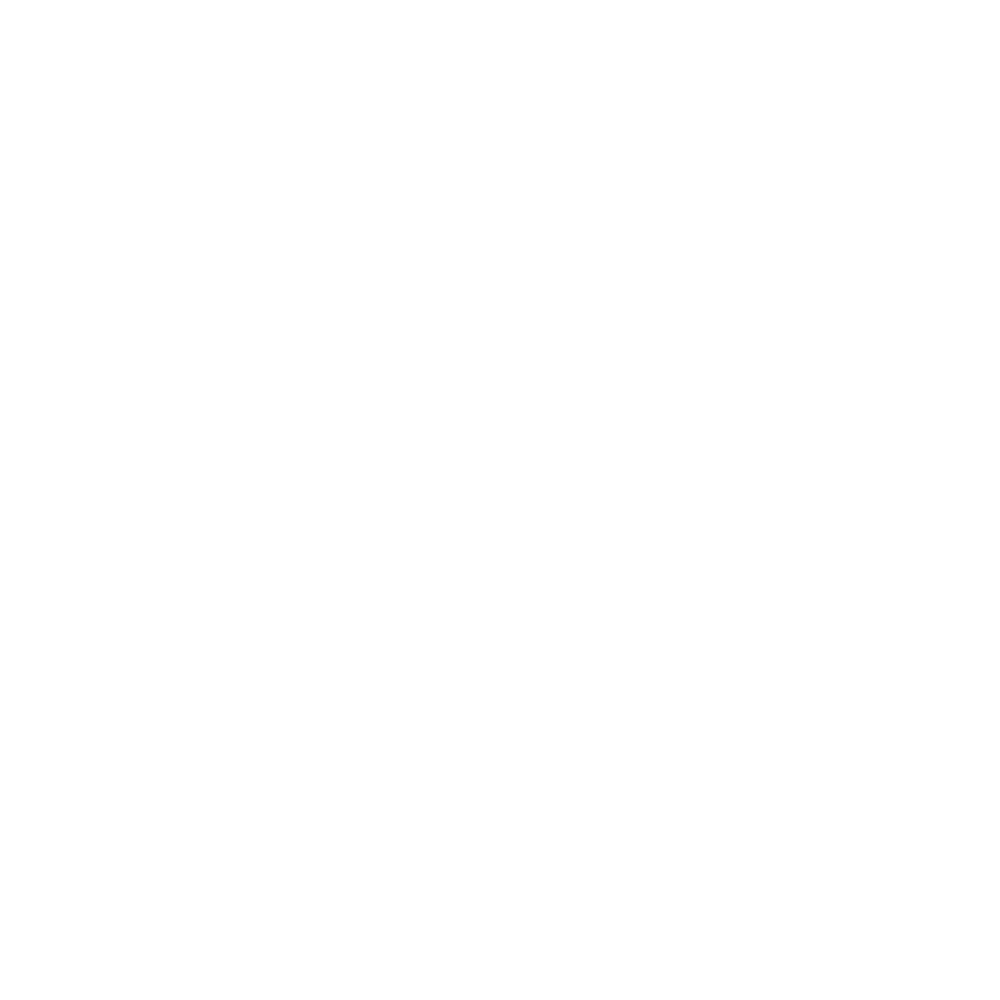

stop with loss 0.49626532196998596
run_model on CV: 4
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


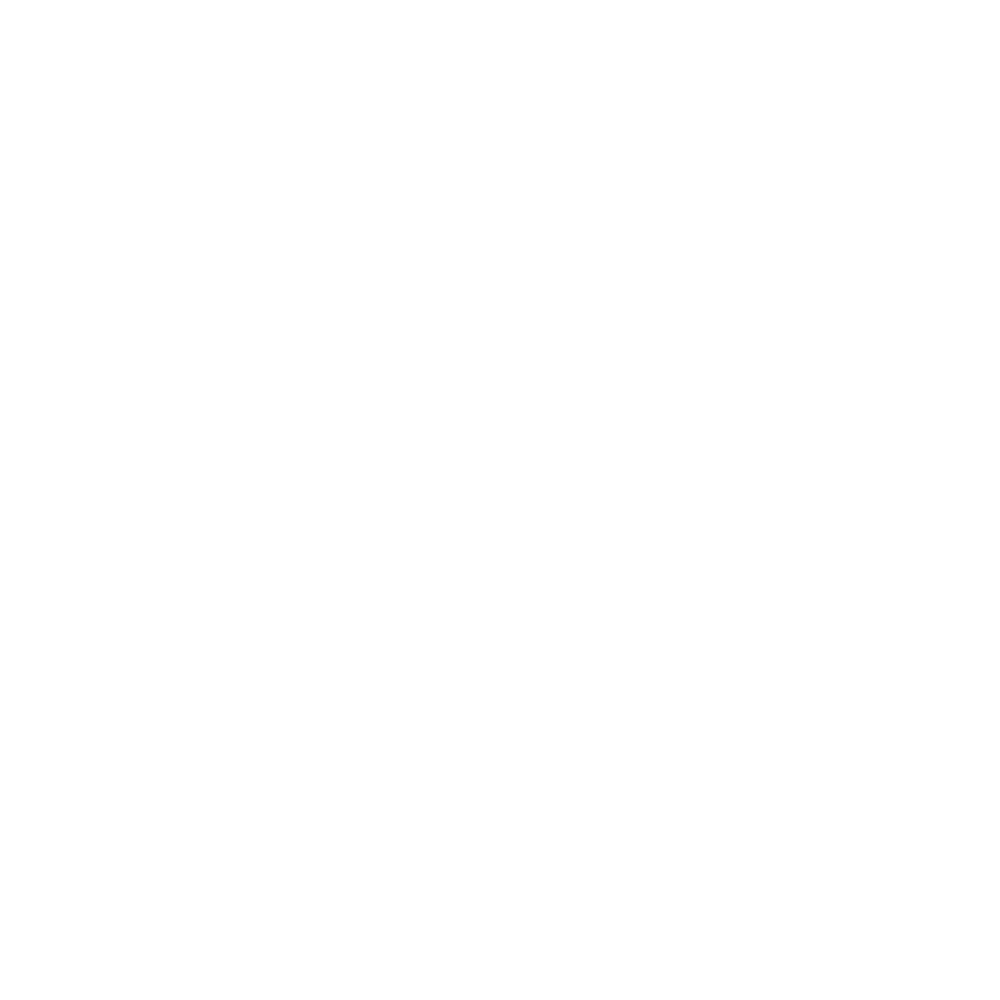

stop with loss 0.4961945414543152
run_model on CV: 5
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


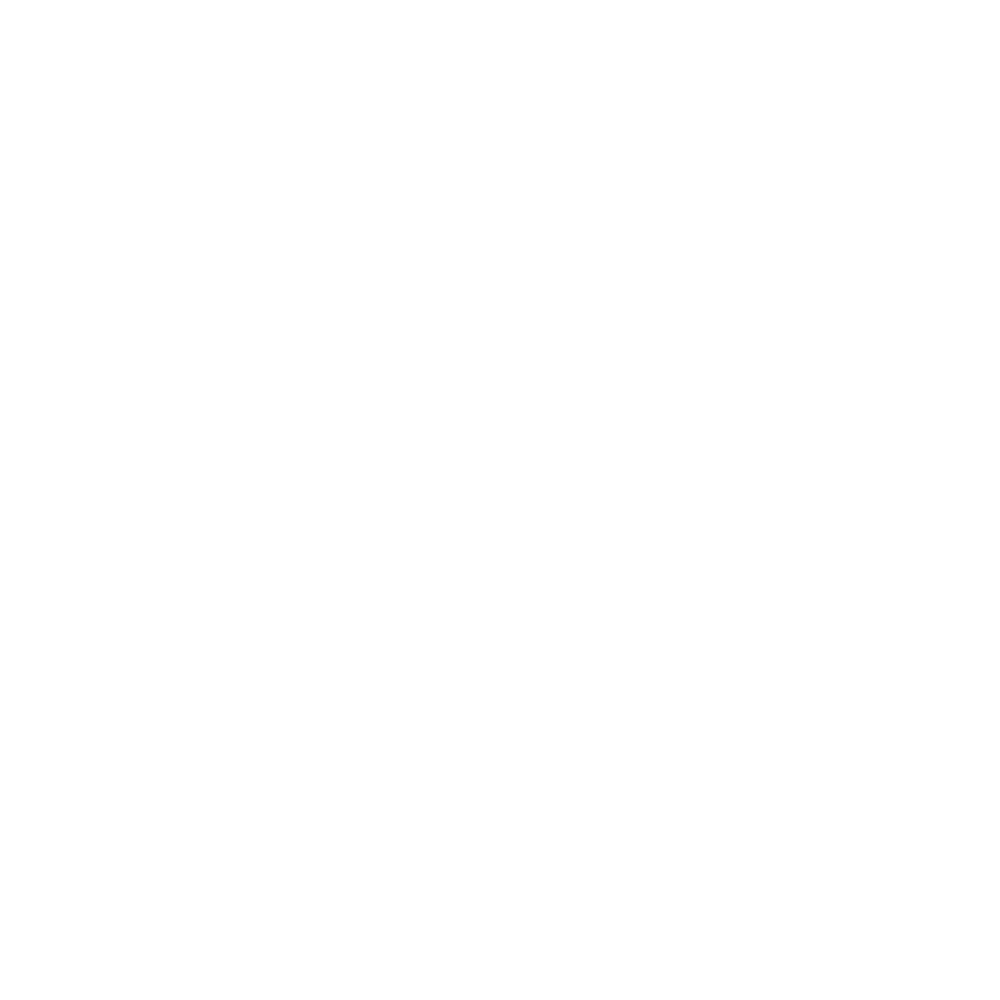

stop with loss 0.4981956481933594
run_model on CV: 6
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


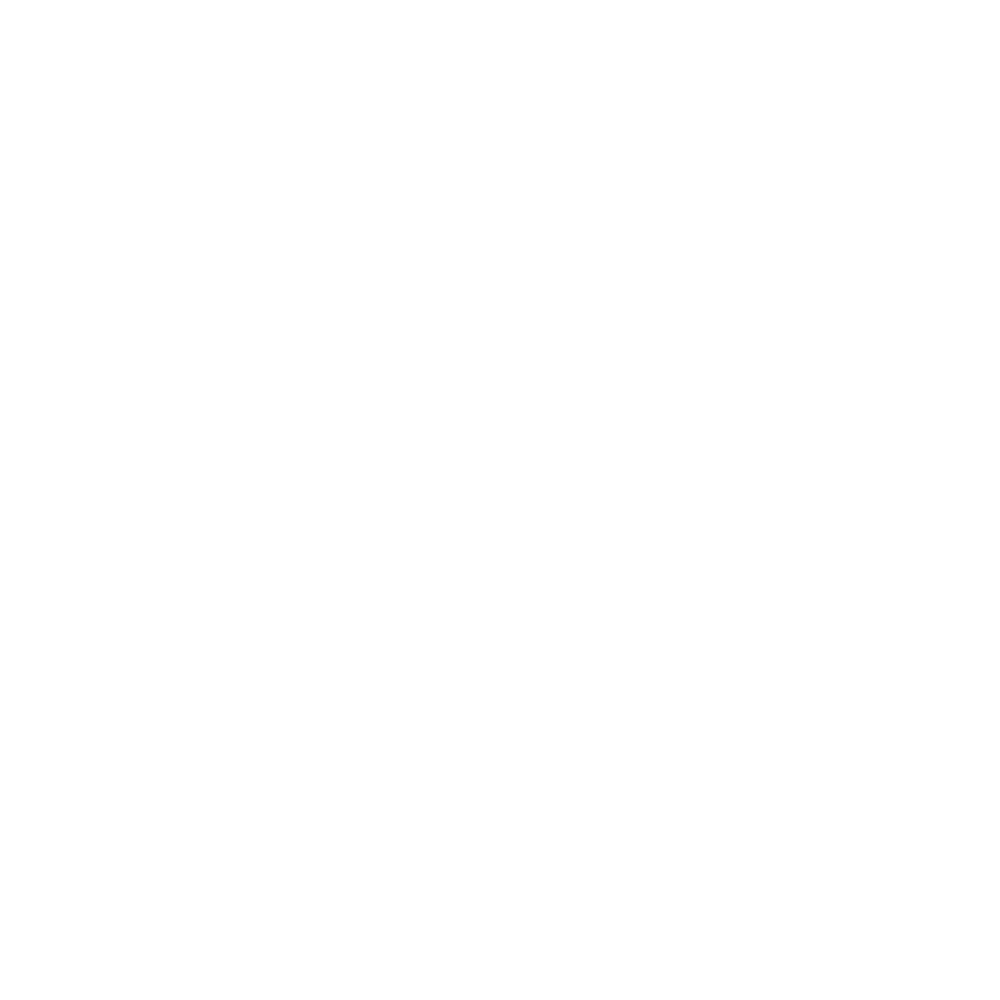

stop with loss 0.4952809512615204
run_model on CV: 7
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


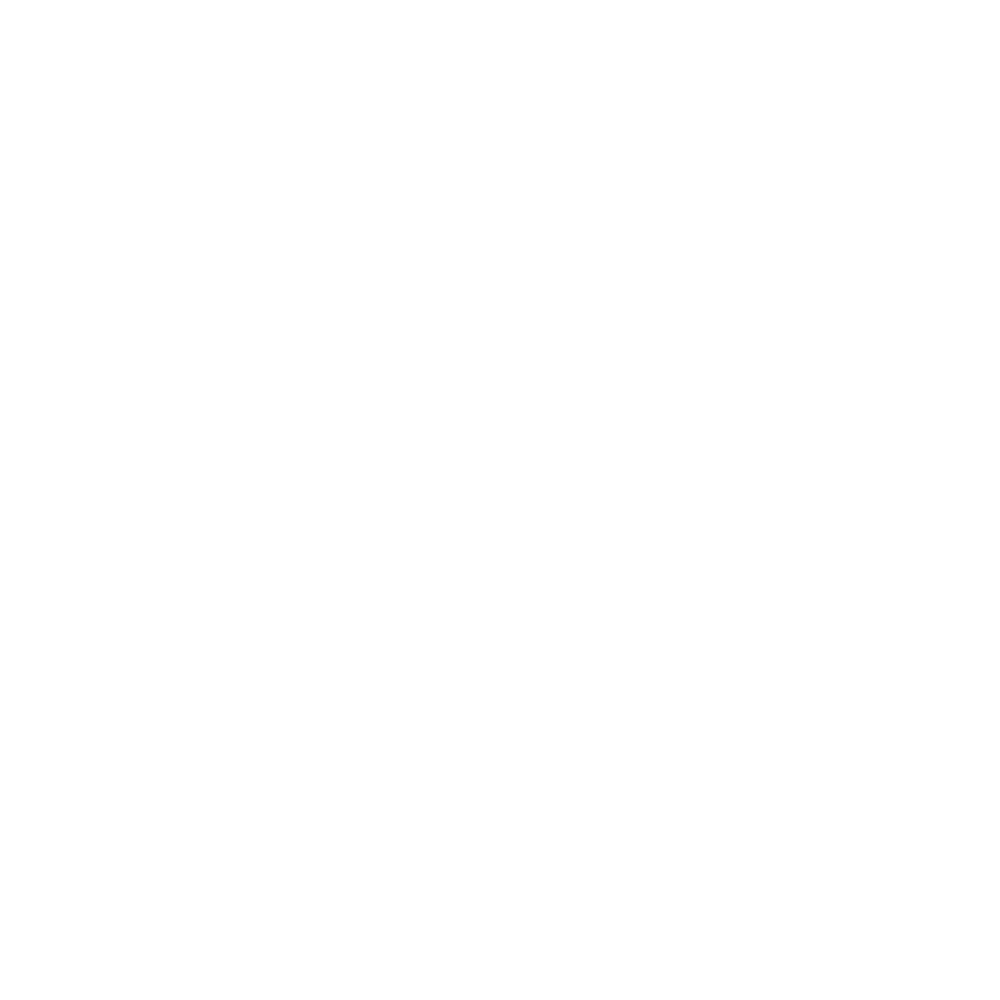

stop with loss 0.49244216084480286
run_model on CV: 8
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


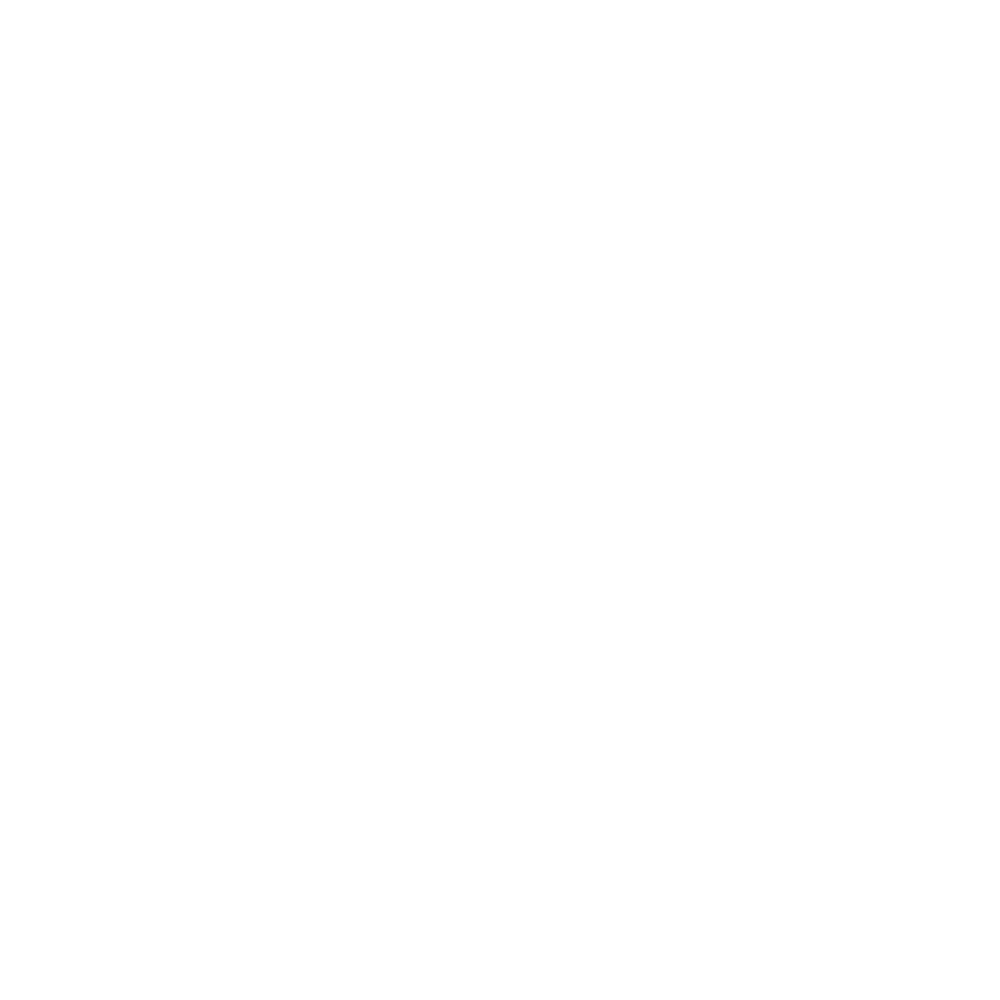

stop with loss 0.49629008769989014
run_model on CV: 9
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


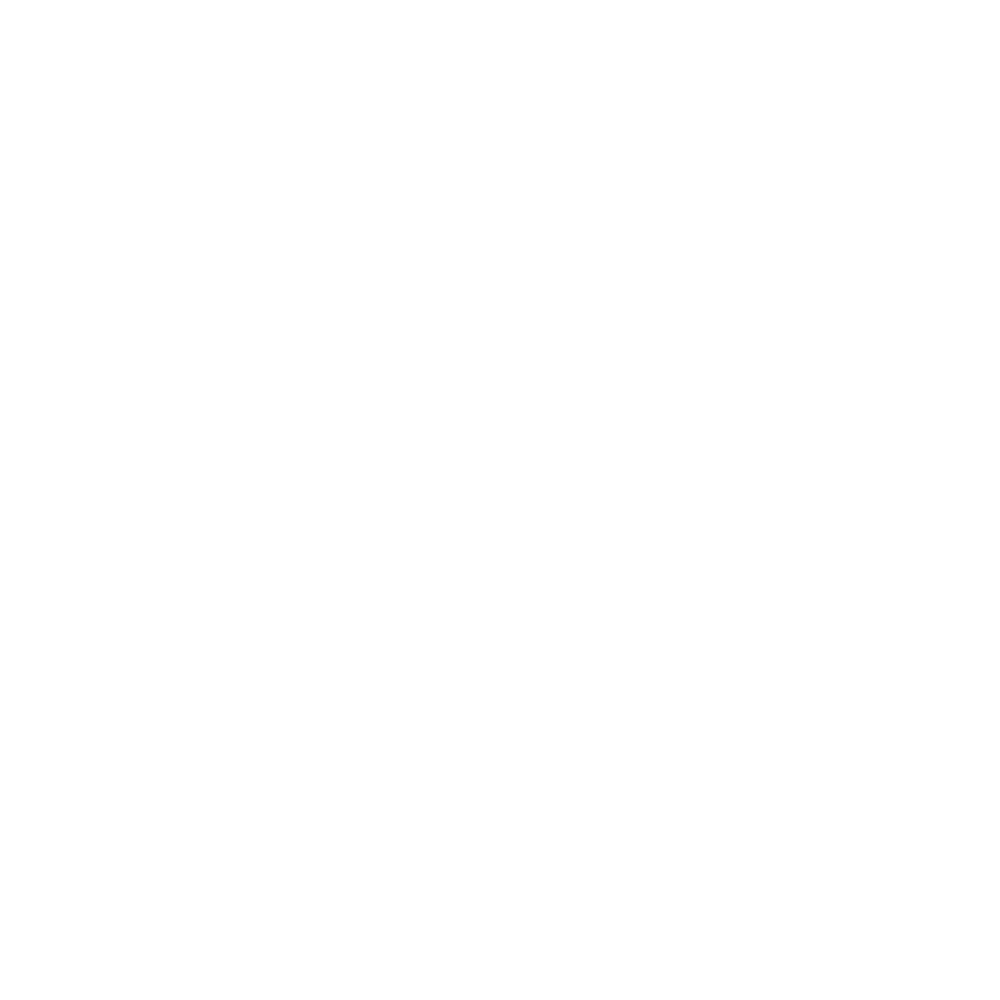

stop with loss 0.4971664845943451
run_model on CV: 10
build layer:
Model(
  (sigmoid): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=772, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=30, bias=True)
    (4): Linear(in_features=30, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
initialize weight...
training with all training data:


C:\Users\Xin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


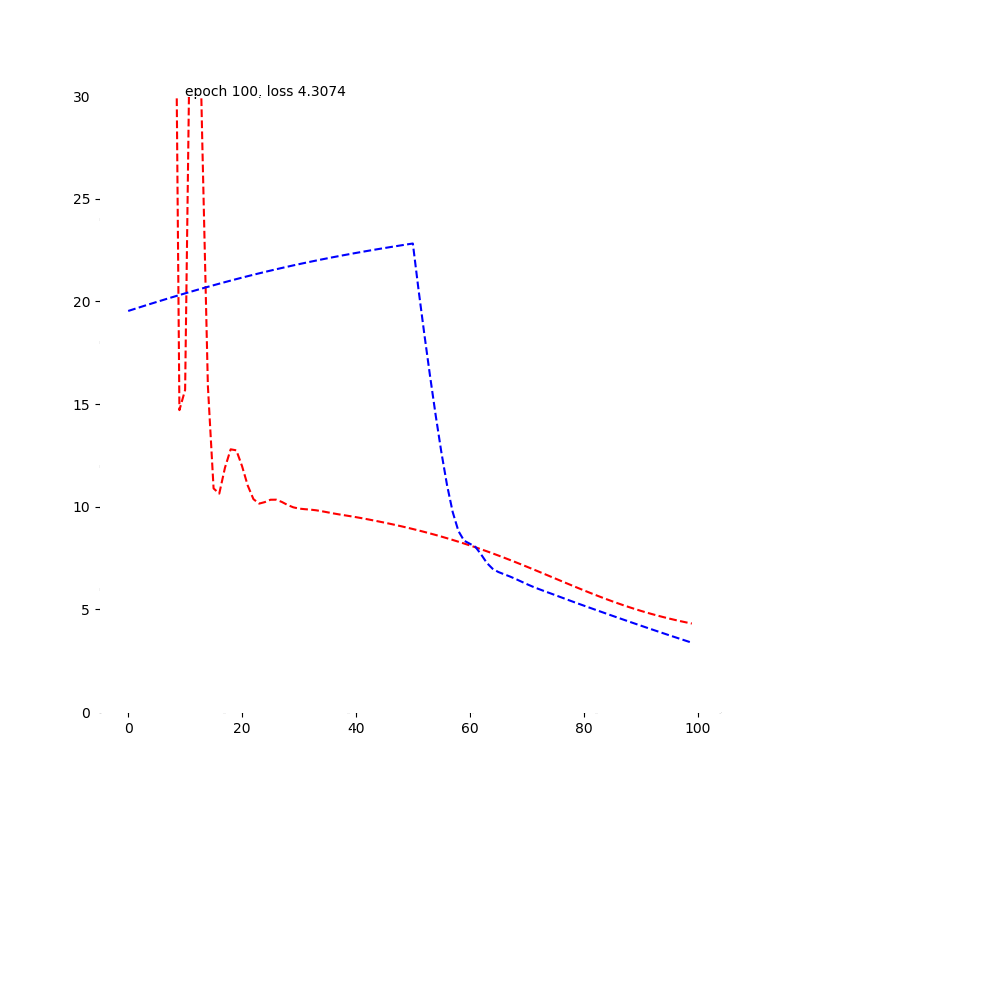

stop with loss 0.4966025948524475


In [5]:
%matplotlib notebook

# brain_feature_list2 = [brain_feature_list[5]]
# run DNN with default parameter:
result_table_dnn, scatter_data_dnn = run_model(Model(), subject_info_hc, brain_feature_list, kf, fit_method = 0)


In [6]:
result_table_dnn.to_csv("result/result_table_dnn.csv", sep = ",")
scatter_data_dnn.to_csv("result/scatter_data_dnn.csv", sep = ",")

#print(plot_data)

C:\Users\Xin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1080x1080 with 0 Axes>

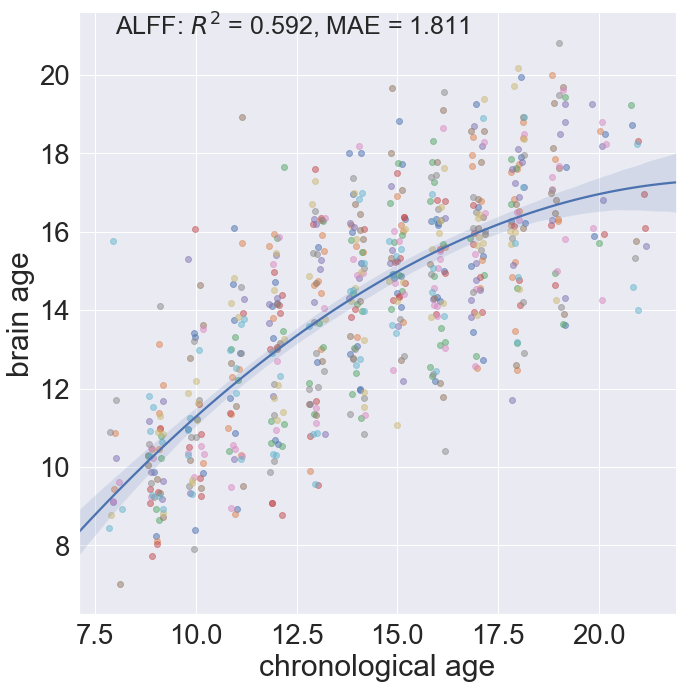

<Figure size 1080x1080 with 0 Axes>

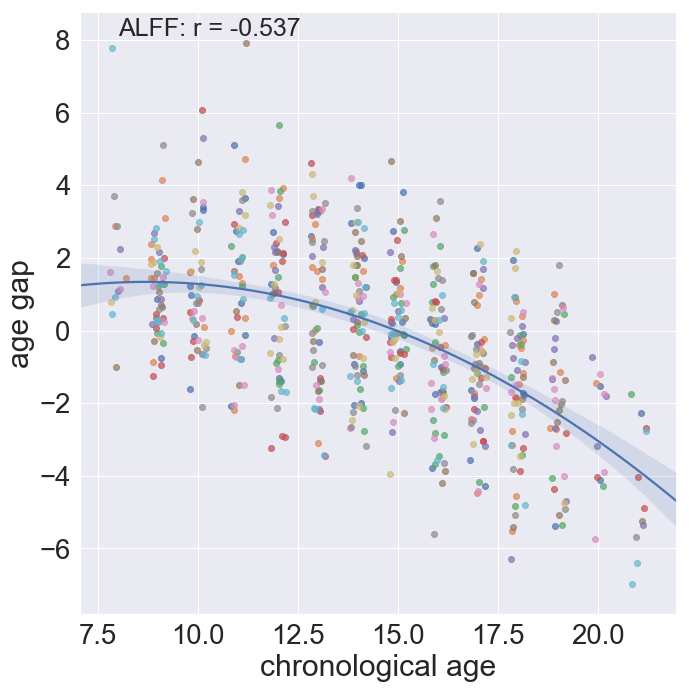

<Figure size 1080x1080 with 0 Axes>

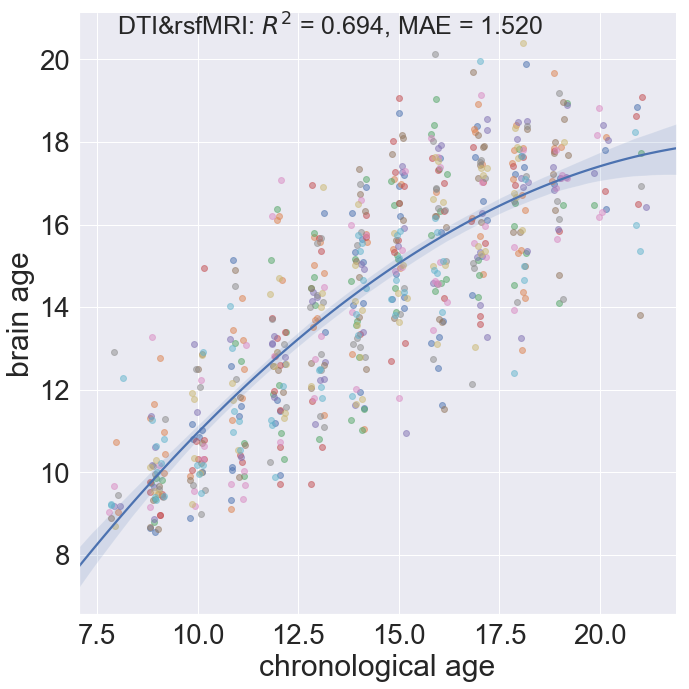

<Figure size 1080x1080 with 0 Axes>

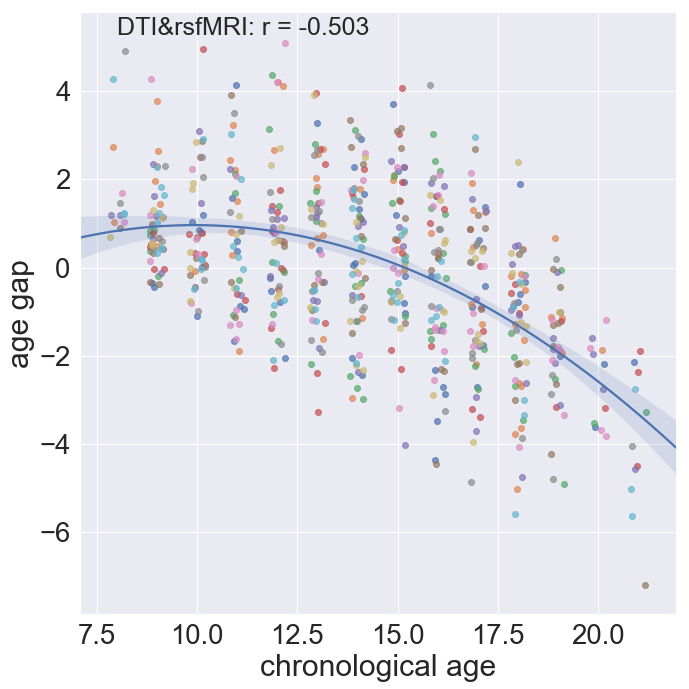

<Figure size 1080x1080 with 0 Axes>

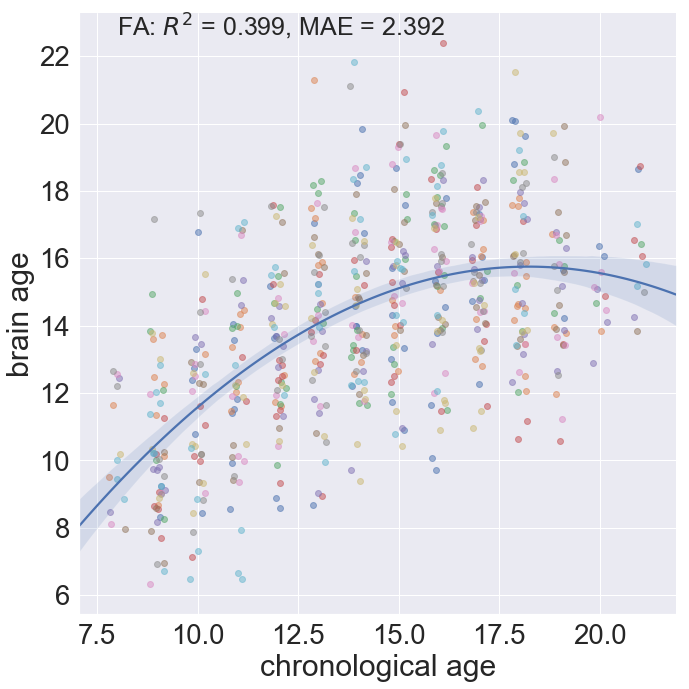

<Figure size 1080x1080 with 0 Axes>

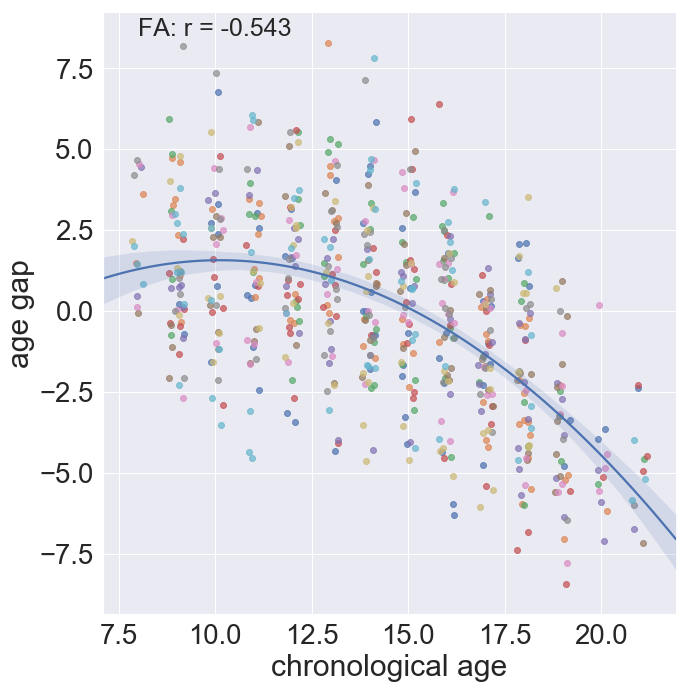

<Figure size 1080x1080 with 0 Axes>

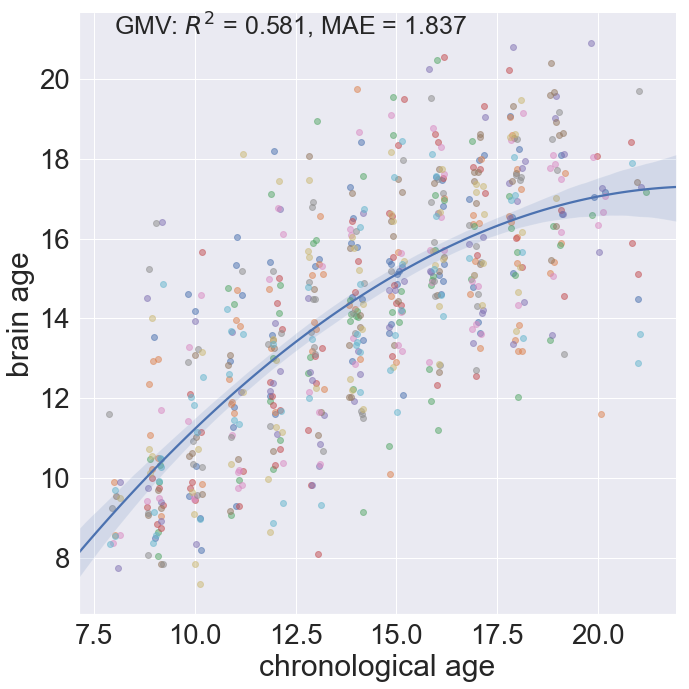

<Figure size 1080x1080 with 0 Axes>

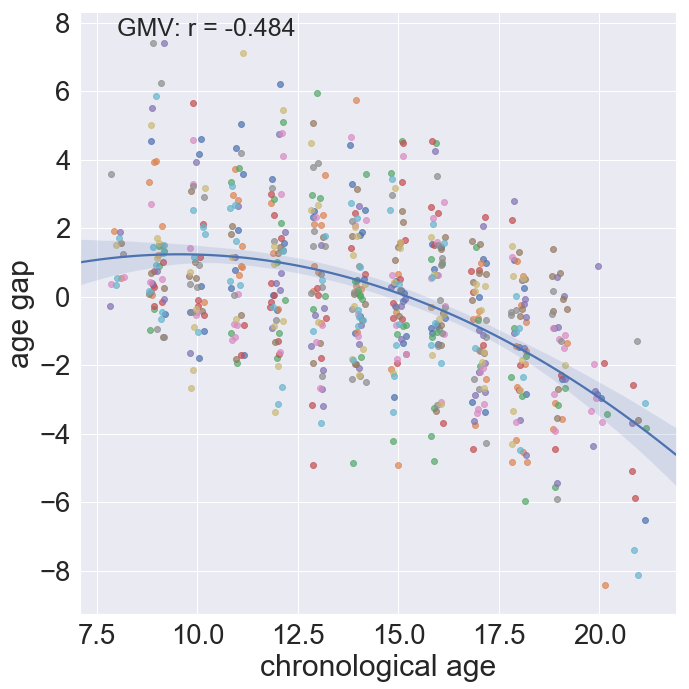

<Figure size 1080x1080 with 0 Axes>

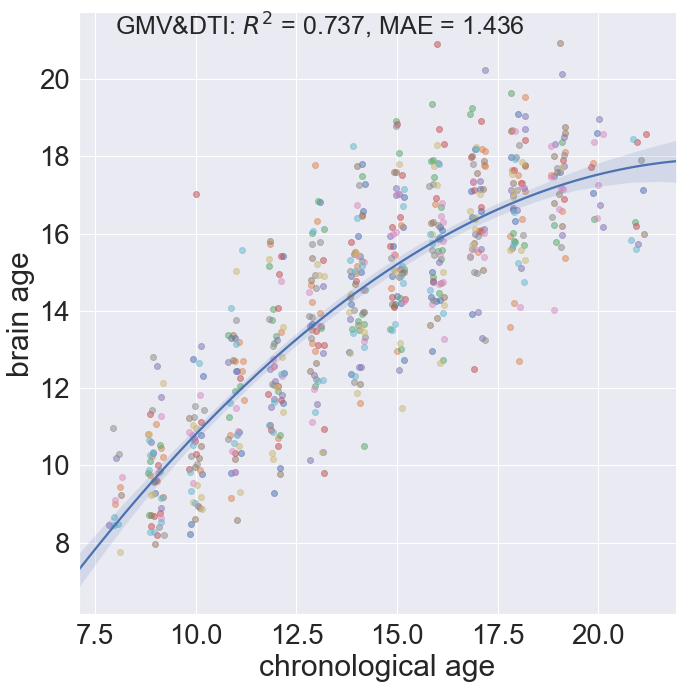

<Figure size 1080x1080 with 0 Axes>

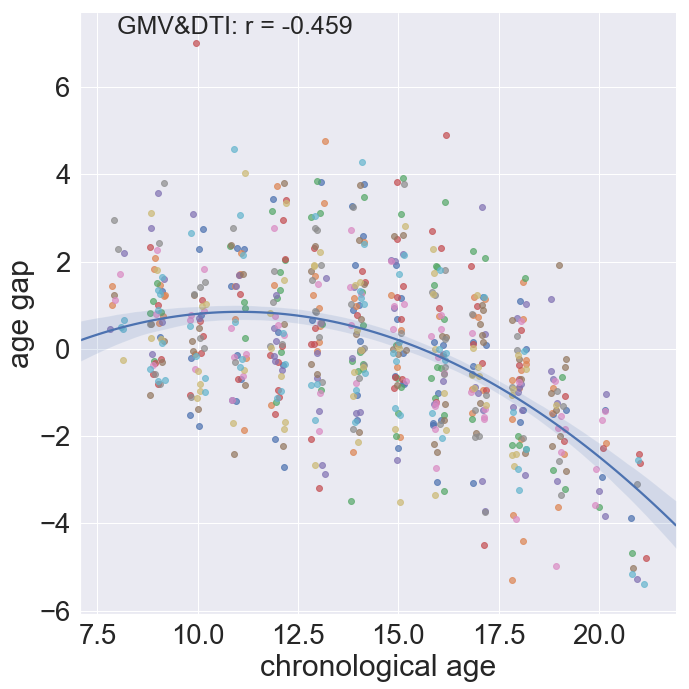

<Figure size 1080x1080 with 0 Axes>

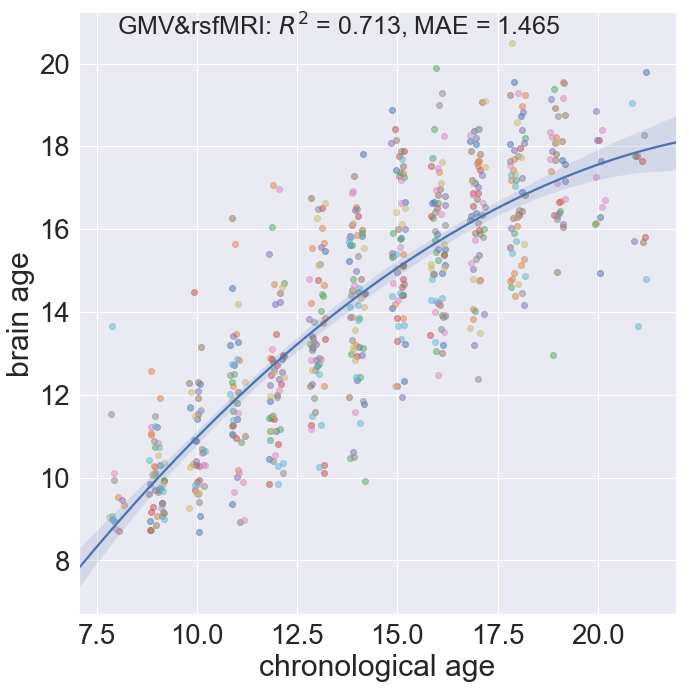

<Figure size 1080x1080 with 0 Axes>

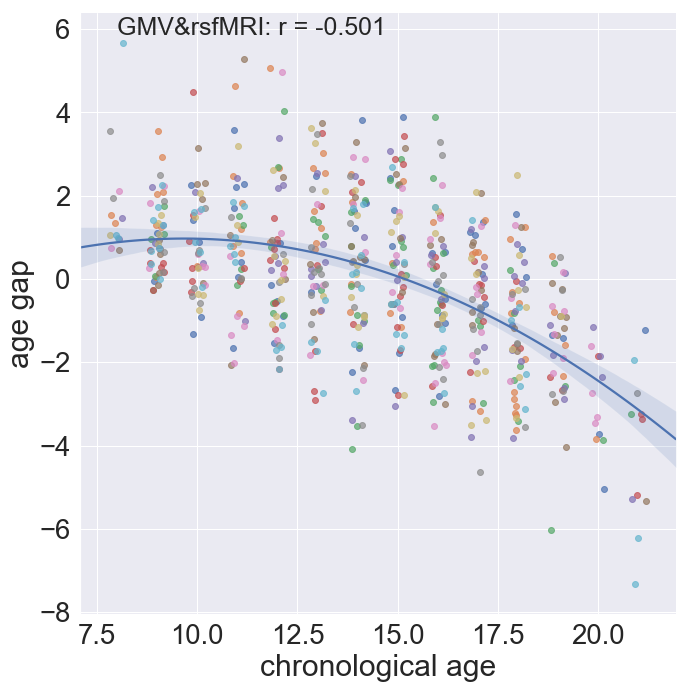

<Figure size 1080x1080 with 0 Axes>

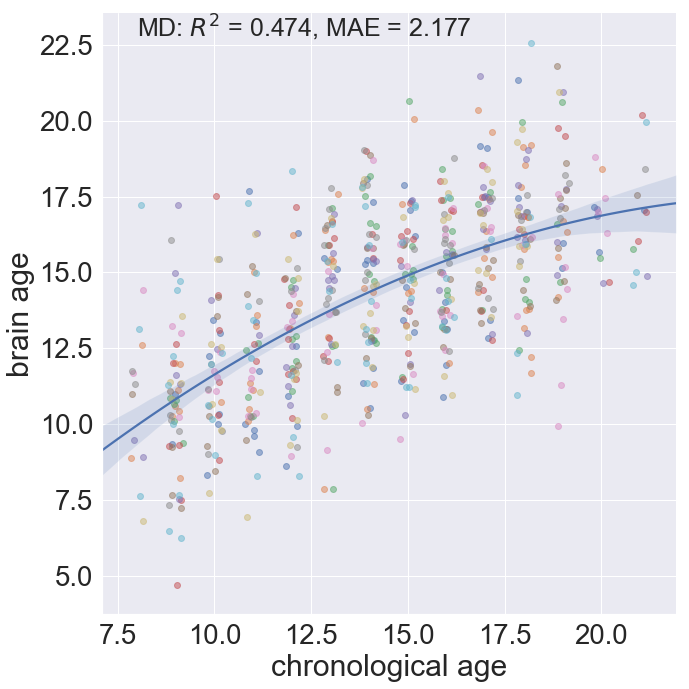

<Figure size 1080x1080 with 0 Axes>

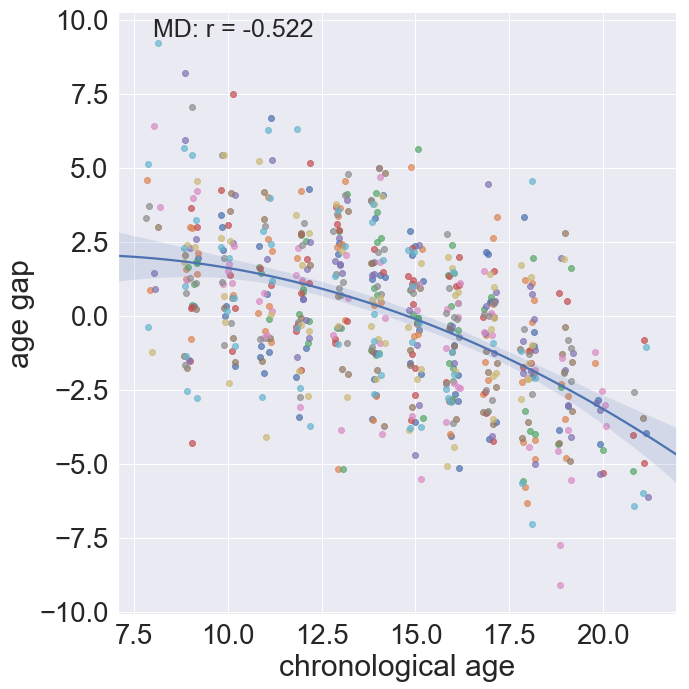

<Figure size 1080x1080 with 0 Axes>

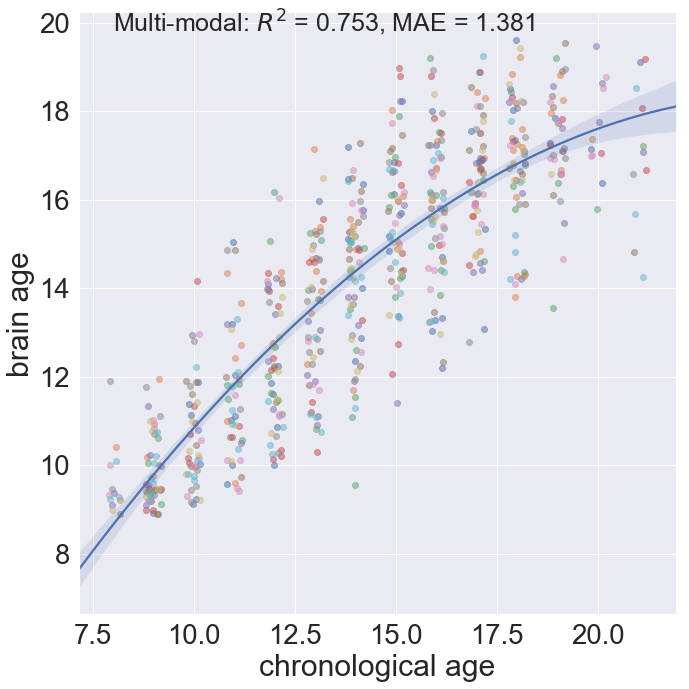

<Figure size 1080x1080 with 0 Axes>

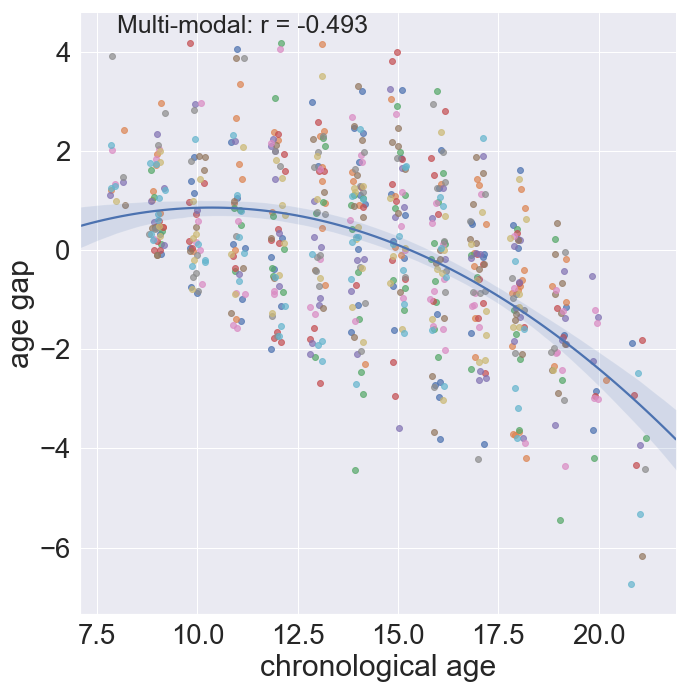

<Figure size 1080x1080 with 0 Axes>

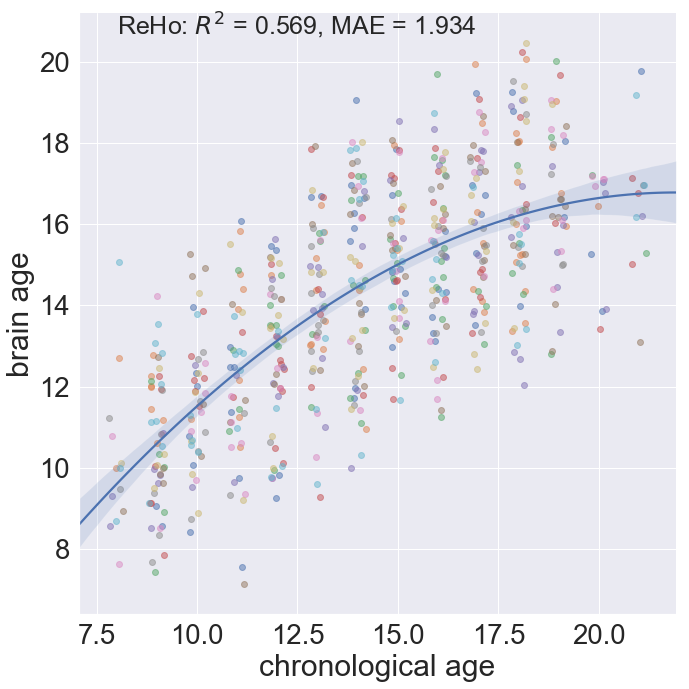

<Figure size 1080x1080 with 0 Axes>

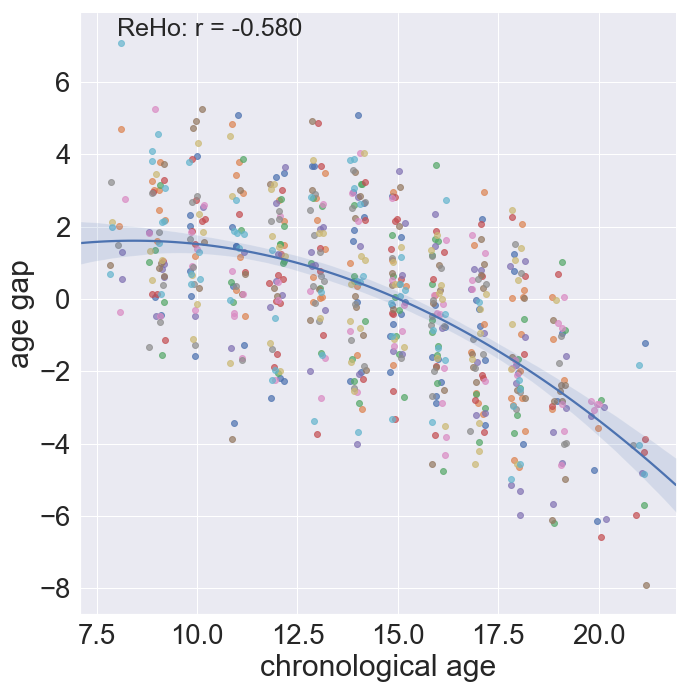

In [7]:
# plot dnn regression results:
import pandas as pd
from my_fun import plot_result_mergecv
result_table_dnn = pd.read_csv('result/result_table_dnn.csv', header = [0,1], index_col = 0)

result_summary_dnn, result_plot_dnn = summary_result(result_table_dnn)
# to make the plot show up if codes are called in a function.
%matplotlib inline
scatter_data = pd.read_csv("result/scatter_data_dnn.csv", sep = ",", header = 0, index_col = 0)
plot_result_mergecv(result_summary_dnn, scatter_data)

C:\Users\Xin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'DNN')

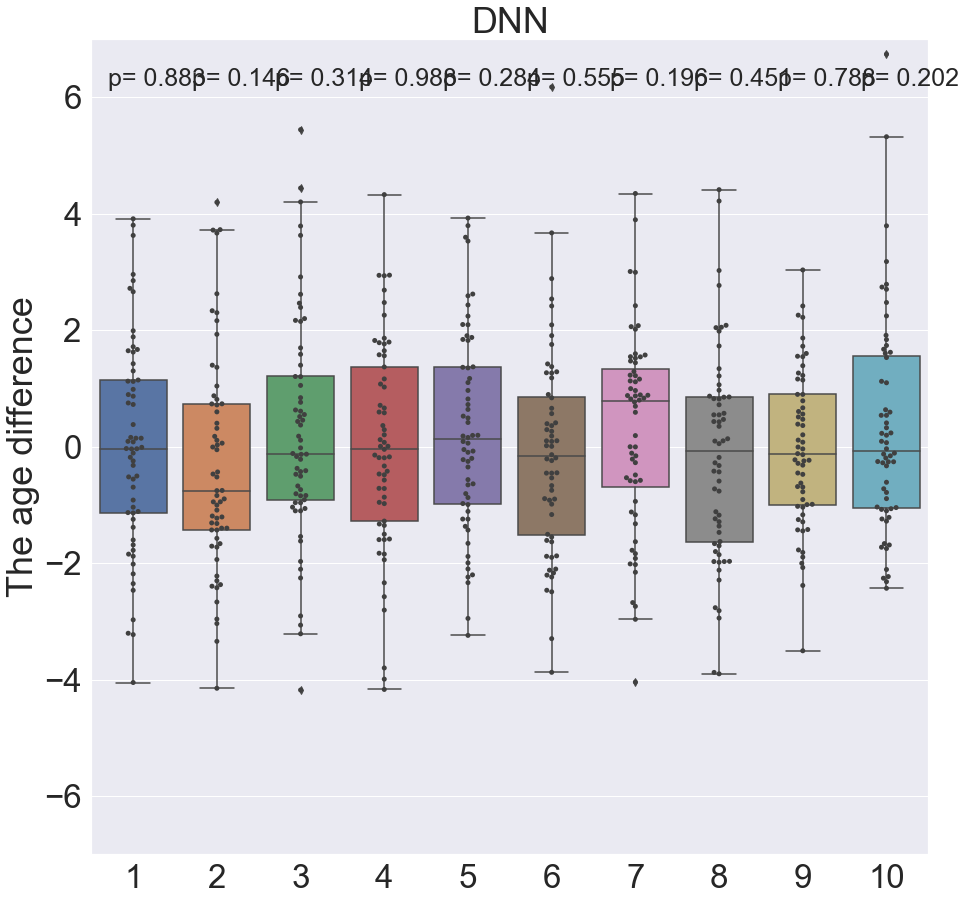

In [8]:
# test residuals from 0 for each CV:
# plot_data_multimodal = plot_data_mi.loc['vbm_dti_alff_reho']
plot_data = scatter_data

plot_data_mi = plot_data.set_index(['feature','CV']).sort_index()
plot_data_multimodal = plot_data_mi.loc['Multi-modal']
# plot_data_multimodal.loc[:,'residual'] = plot_data_multimodal.loc[:,'chronological age'] - \
#                                     plot_data_multimodal.loc[:,'brain age']
plot_data_multimodal['residual'] = plot_data_multimodal.loc[:,'chronological age'] - \
                                    plot_data_multimodal.loc[:,'brain age']

plot_data_multimodal2 = plot_data_multimodal.reset_index(level = 0)
#print(plot_data_multimodal)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.set(rc={'figure.figsize':(30, 15)}, font_scale = 3)

ax = sns.boxplot(y = "residual", x = "CV", data = plot_data_multimodal2)
ax = sns.swarmplot(y = "residual", x = "CV", data=plot_data_multimodal2, color=".25")
ax.set_ylim(-7,7)

from mlxtend.evaluate import permutation_test


for i in range(nfold):
    residual = plot_data_multimodal.loc[i+1, 'residual']
    p = permutation_test(residual, np.zeros(residual.shape[0]), method='approximate',num_rounds=1000,seed=0)
    
    txt = "p= %.3f" % p 
    ax.text(i-.3, 6.2, txt, fontsize = 25)

ax.set(ylabel="The age difference", xlabel="")
plt.title("DNN")